### This notebook explains variational autoencoder from scratch :

`Components of a variational autoencoder `:
1. Encoder : encodes inputs into latent d dimentional space 
2. Sampler : samples variance and std from d/2 dimentional mean and logvar 
3. Decoder : takes a random sample from latent space with mu and sigma and reconstructs the input 


    
    * Input x through Encoder 
    * Sample eps from a standard normal distribution (mean 0 , varience 1 )
    * reparameterise ( mean + eps*varience ) 
    * feed sampled latent vector through the decoder 
    * Add the recontruction loss (BCE) and KL Divergence Loss 
    * update the parameters , including mean and varience 

`Difference between autoencoder and VAE `\
    while autoencoders map each input to a point and reconstruct from that point 
    VAE is capable of mapping an input to a set of points , like a region.
    unlike AE VAE has a continous latent space such that we can sample from a standard normal distribution.
    Due to this property the VAE decoder is also a generative network.


`How does sampling from a normal distribution change latent space ?`\
    When we only account for reconstruction error we are essentially just creating clusters of space in the 
    latent dimention which are far apart from one another so that two regions don't overlap and confuse           reconstruction. sampling from normal distribution allows the latent space to be continious space and
    yet clustered in regions.
    Values close to each other in latent region get reconstructed as very similar output.
    
`Why take the log varience and not just varience `\
    parameters from the encoder output can also be negative but varience cannot be negative , therefore we         take the log varience instead so as to have only positive value ** clarity needed
    
    # add to it the loss function reason 
    
`How does the loss function work`\
    The objective fucntion in a VAE is to find the PDF of z given x for the encoder and to find the PDF of 
    x' given z for the decoder. 
    There are essentially two loss values in VAE 
    The reconstruction loss + KL divergence 
    KL divergence essentilly gives the amount of information lost when approximating one distribution with         other.
    Reconstruction loss is the loss captured for deviation in input and reconstruction pixel by pixel.
    

In [12]:
import torch.nn as nn
import torch
import numpy
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
# Define data loading step

batch_size = 128

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784 , 512)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(512, 256)
        
    def forward(self , x):
        out = self.linear2(self.relu(self.layer1(x.view(-1 , 784))))
        return out
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(128 , 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256 , 784)
        # convert output back to input range between [0 to 1 ]
        self.sigmoid = nn.Sigmoid()
        
    def forward(self , x):
        out = self.sigmoid(self.linear2(self.relu(self.layer1(x))))
        return out

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def reparameterize(self , mu, log_var):
        #tensor from standard normal distribution 
        eps = torch.randn(mu.size(0), log_var.size(1))
        #get standard deviation from log varience 
        z = mu + eps * torch.exp(log_var/2.) 
        return z
    
    def forward(self , x):
        # split the encoder output into two parts and get each for mean and varience 
        out = self.encoder(x.view(-1 , 784)).view(-1, 2, 128)
        out_mu = out[: , 0 , :]
        out_var = out[: , 1 , :]
        latent = self.reparameterize(out_mu , out_var)
        out = self.decoder(latent)
        return out , out_mu , out_var
        
   


In [6]:

model = VAE()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
)


In [7]:

def loss_function(output_x, input_x, mu, logvar, β=1):
    BCE = F.binary_cross_entropy(
        output_x, input_x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    return BCE + β * KLD

In [8]:
# # Training and testing the VAE
def train():
    epochs = 50
    for epoch in range(0, epochs):
        model.train()
        train_loss = 0
        test_loss = 0
        for x, _ in train_loader:
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("Average loss" , train_loss / len(train_loader.dataset))

        with torch.no_grad():
            model.eval()
            for x, y in test_loader:
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                test_loss += loss_function(x_hat, x, mu, logvar).item()

        test_loss /= len(test_loader.dataset)
        print(f'====> Test set loss: {test_loss:.4f}')
train()

Average loss 266.9191719075521
====> Test set loss: 208.7846
Average loss 193.0651869140625
====> Test set loss: 179.7278
Average loss 173.80189248046875
====> Test set loss: 167.8486
Average loss 164.8877627766927
====> Test set loss: 160.3919
Average loss 157.9555795247396
====> Test set loss: 153.8583
Average loss 152.25009650065104
====> Test set loss: 148.8602
Average loss 147.832173828125
====> Test set loss: 144.7616
Average loss 144.23673157552082
====> Test set loss: 141.7465
Average loss 141.36984397786458
====> Test set loss: 138.9747
Average loss 138.931762109375
====> Test set loss: 136.7543
Average loss 136.6777043294271
====> Test set loss: 134.6416
Average loss 134.68451748046874
====> Test set loss: 132.4048
Average loss 132.80728828125
====> Test set loss: 130.7542
Average loss 130.9724716796875
====> Test set loss: 129.2400
Average loss 129.3846098144531
====> Test set loss: 127.3734
Average loss 127.82330193684896
====> Test set loss: 126.0354
Average loss 126.37198

<ipython-input-9-95e855b49a27>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 4))
<ipython-input-9-95e855b49a27>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))


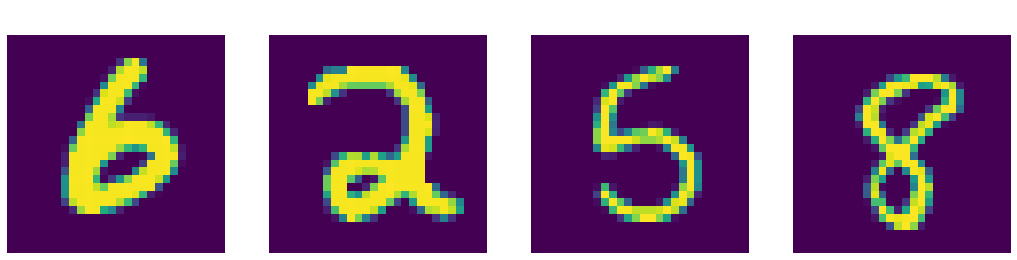

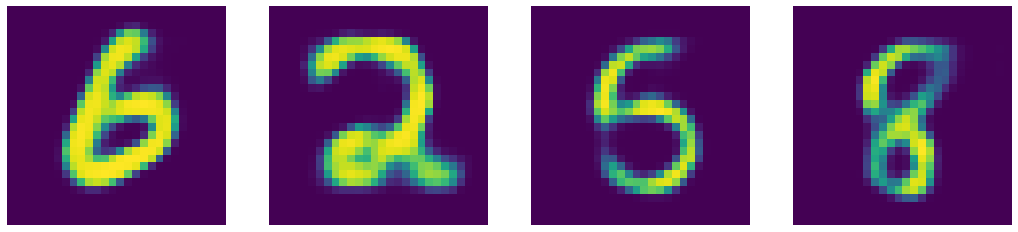

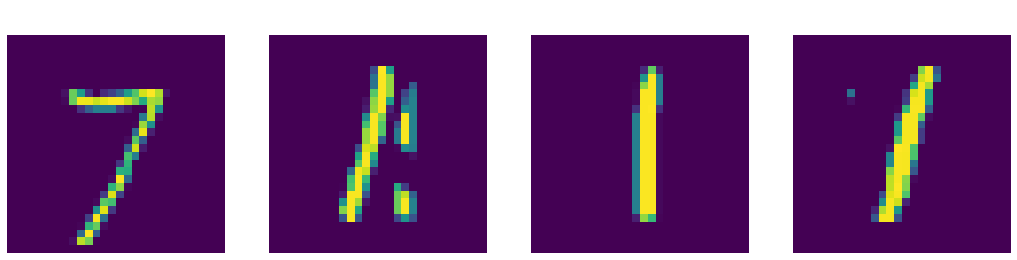

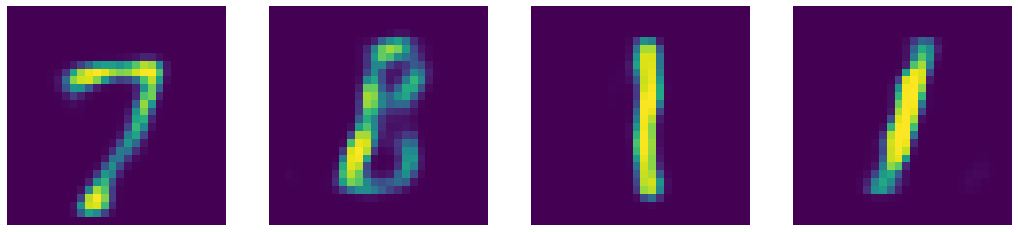

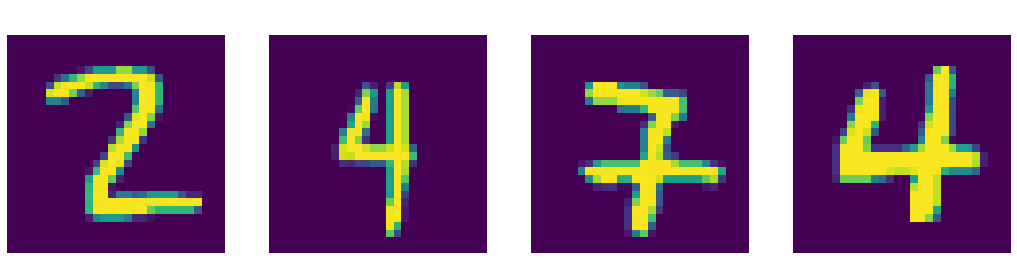

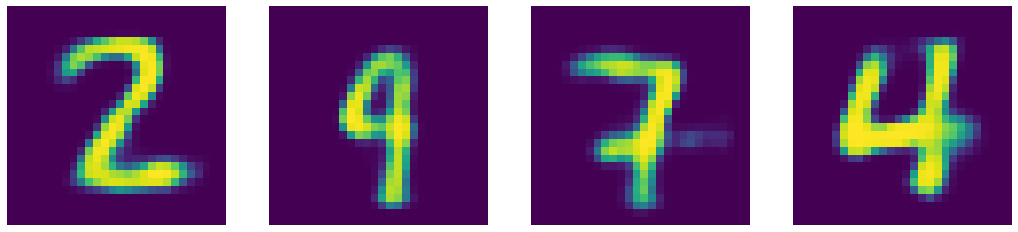

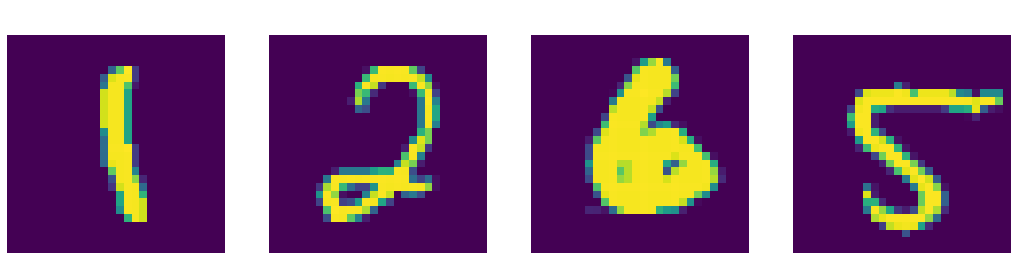

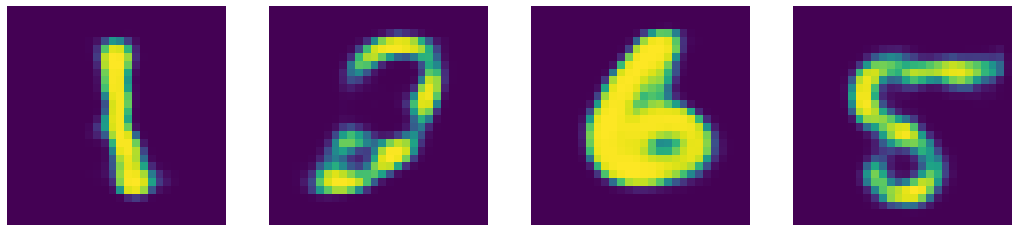

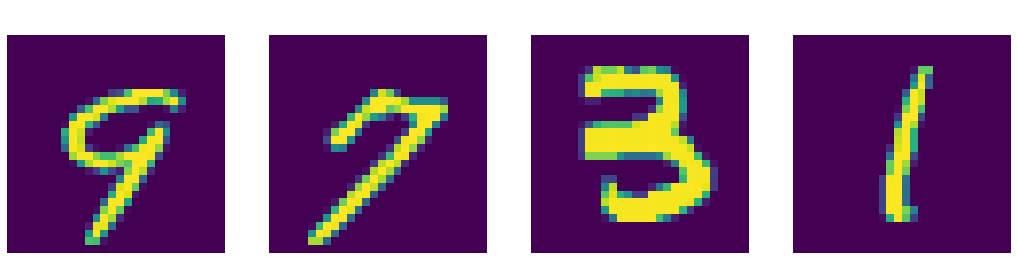

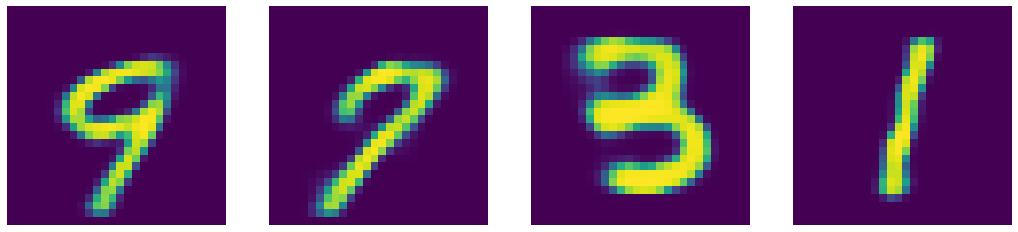

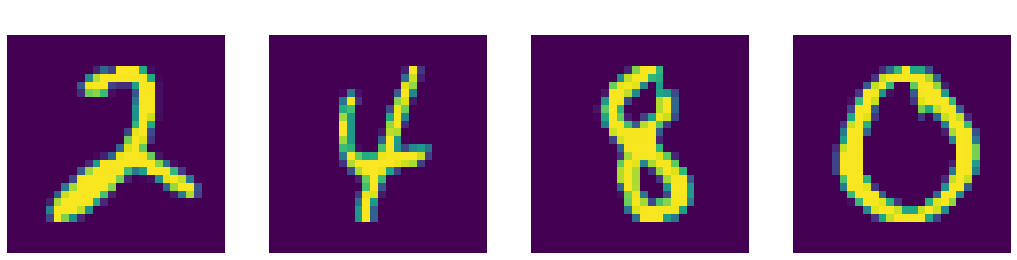

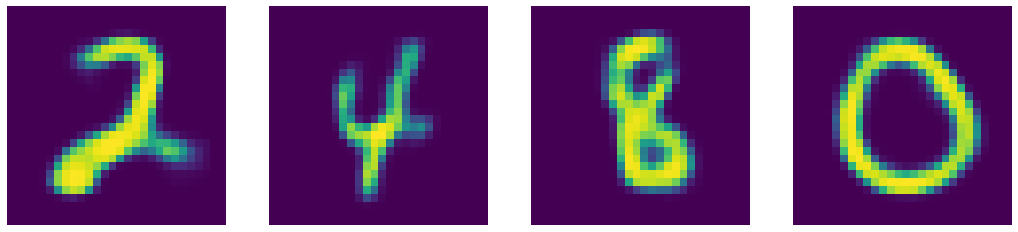

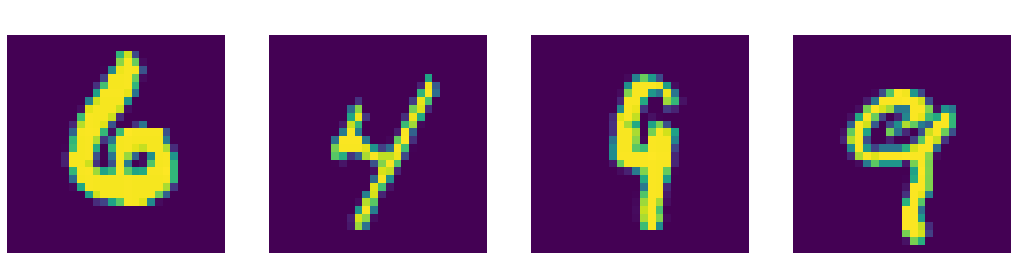

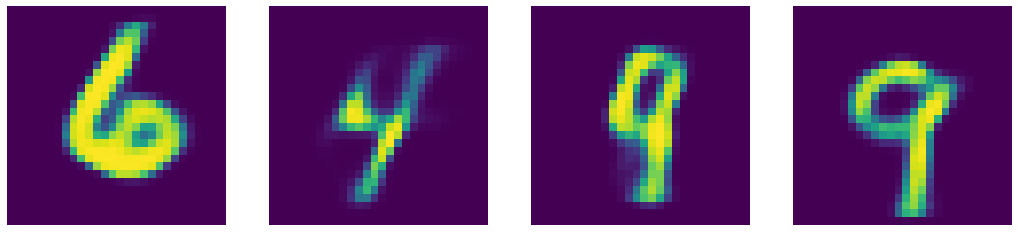

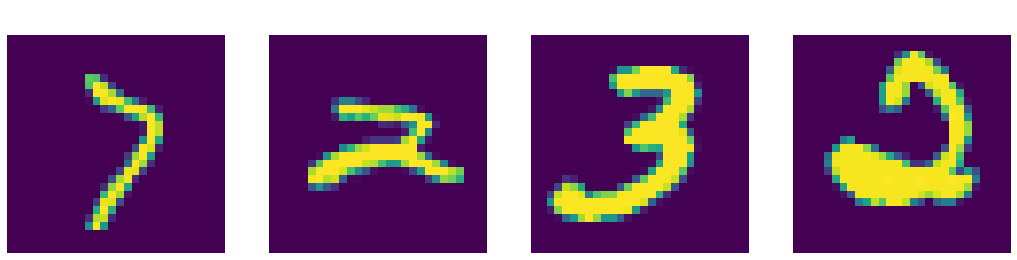

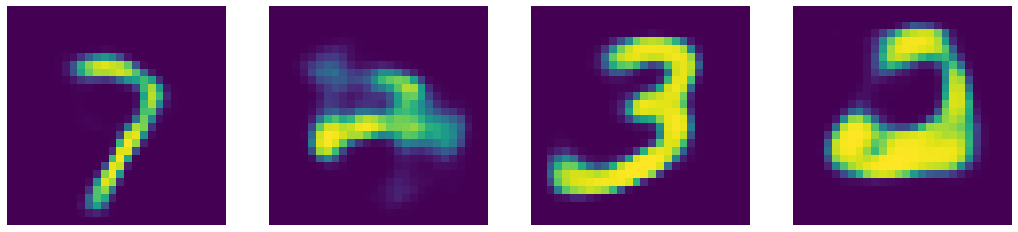

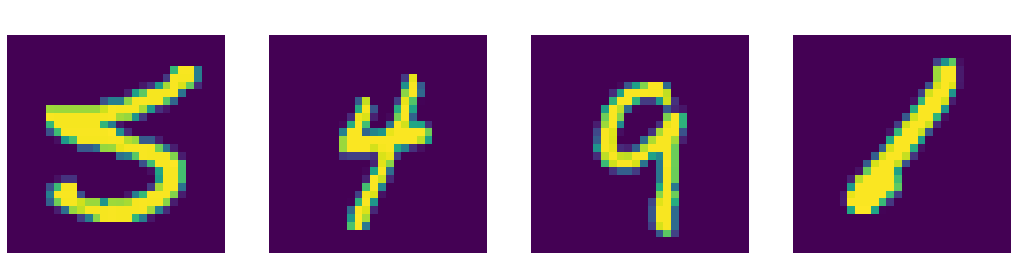

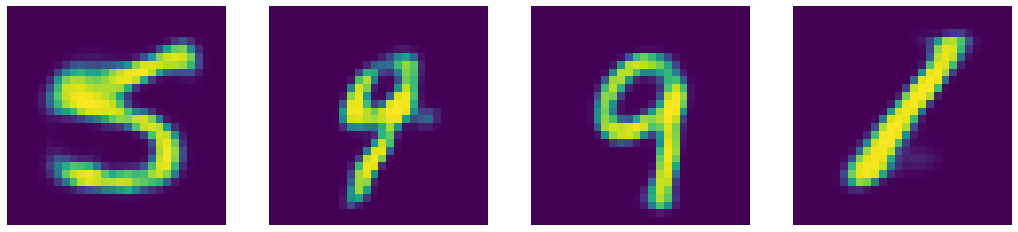

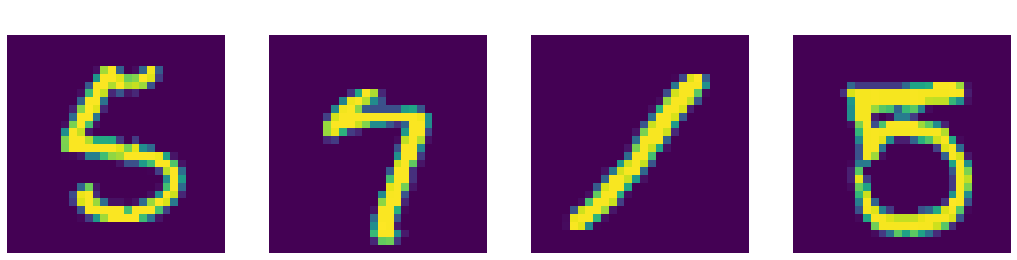

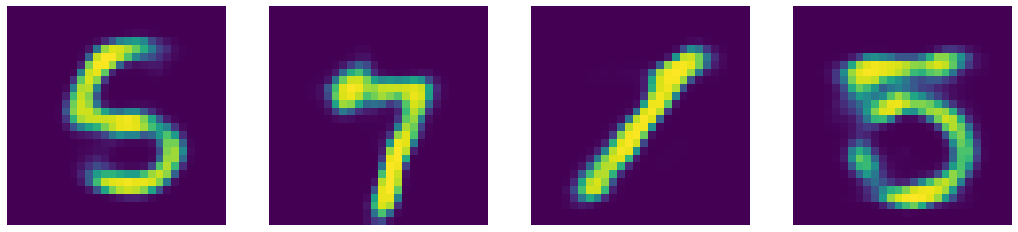

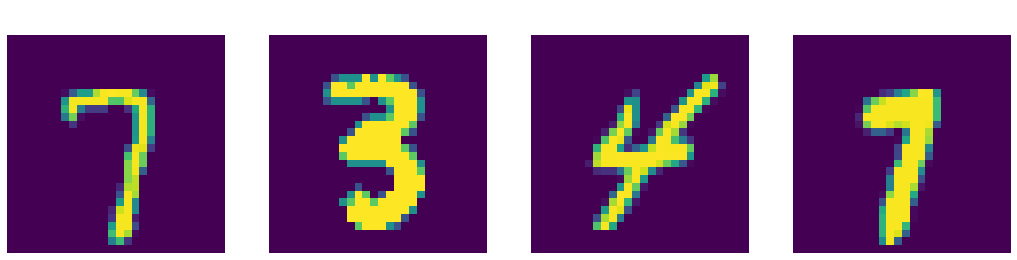

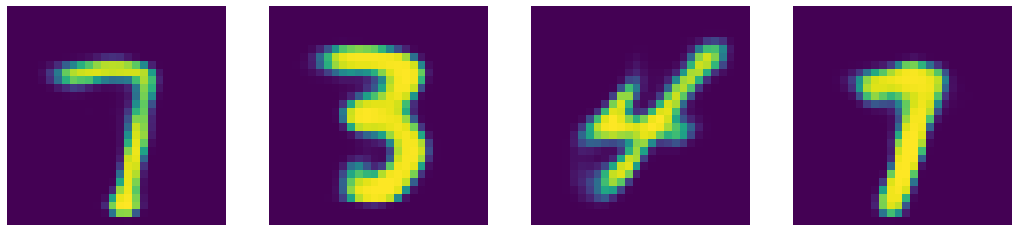

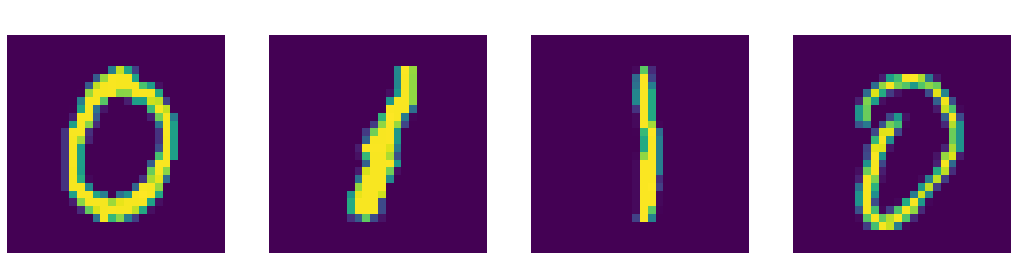

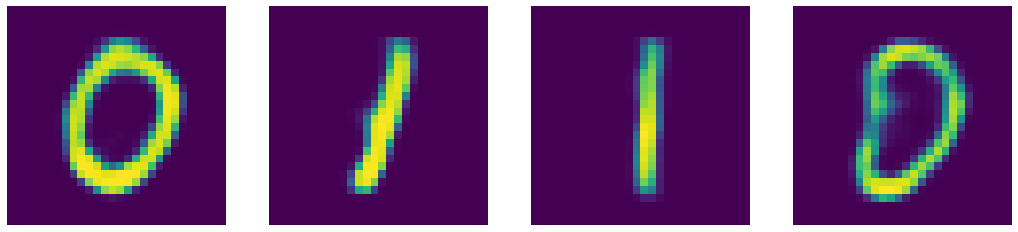

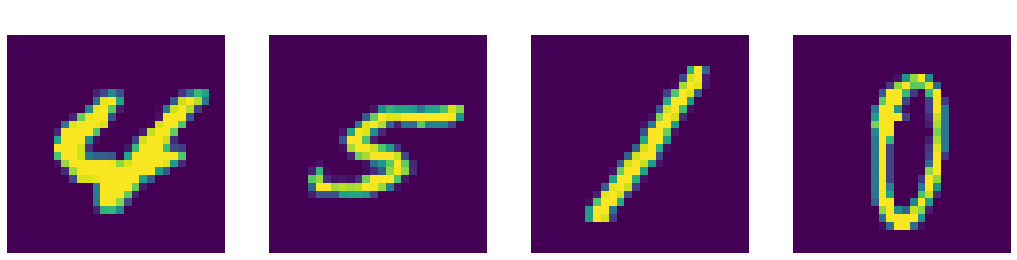

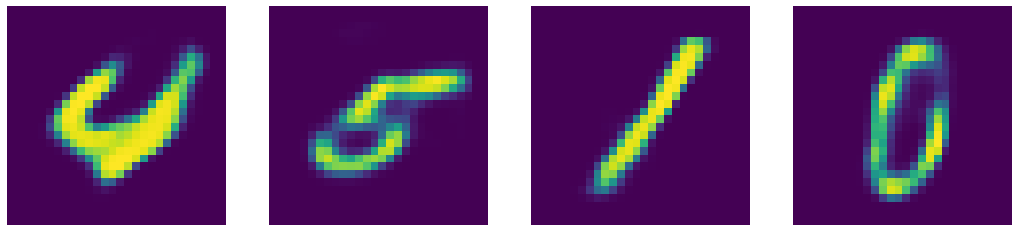

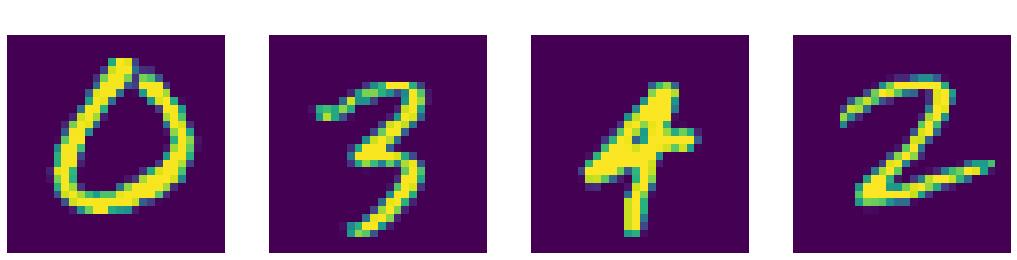

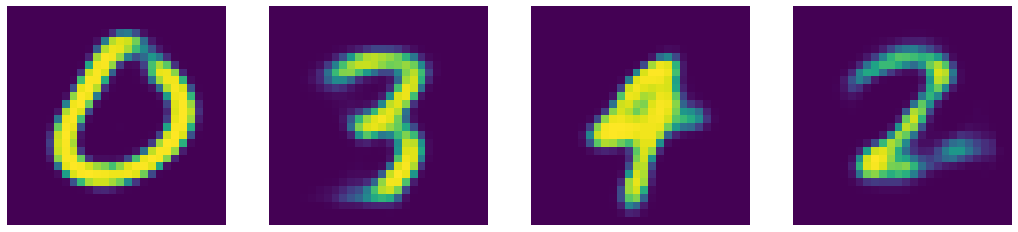

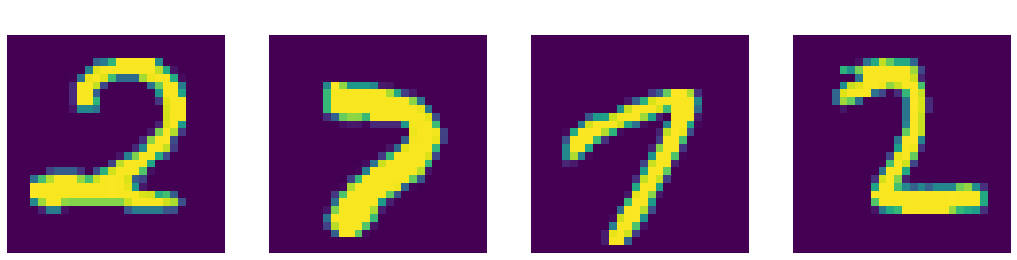

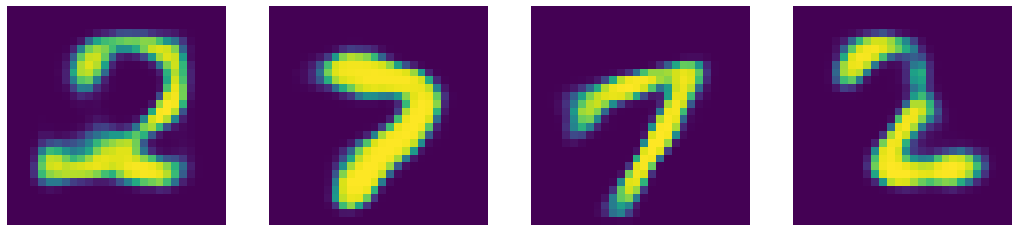

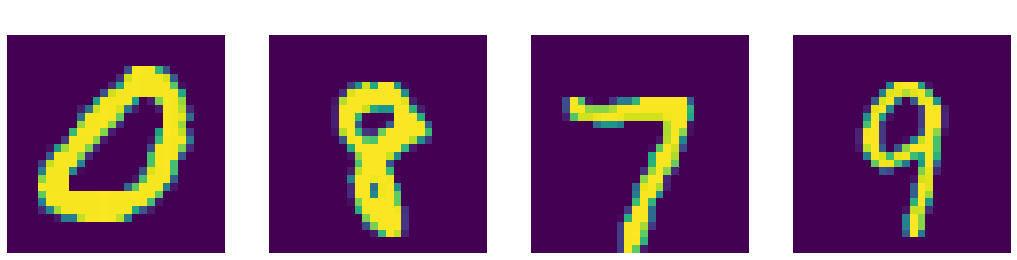

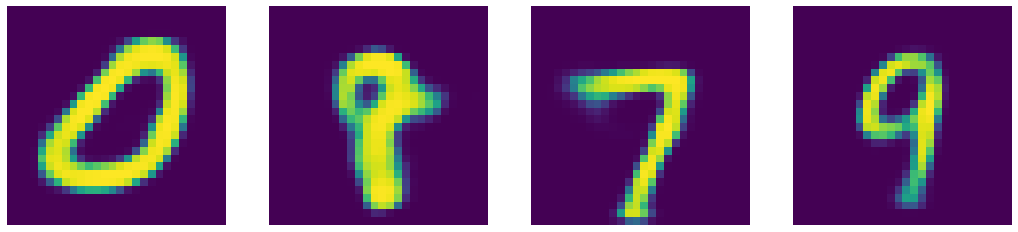

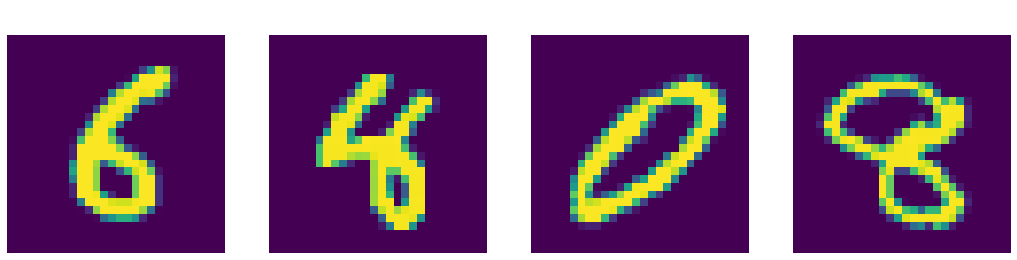

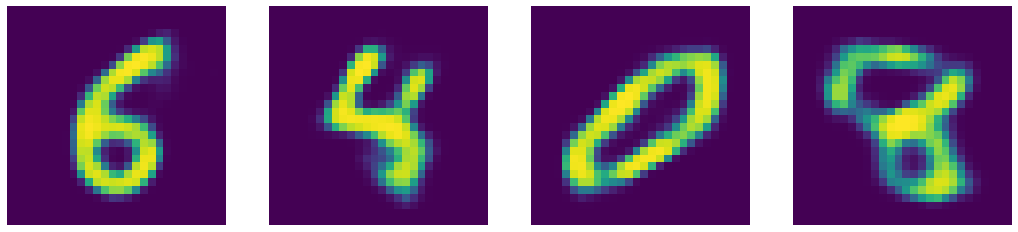

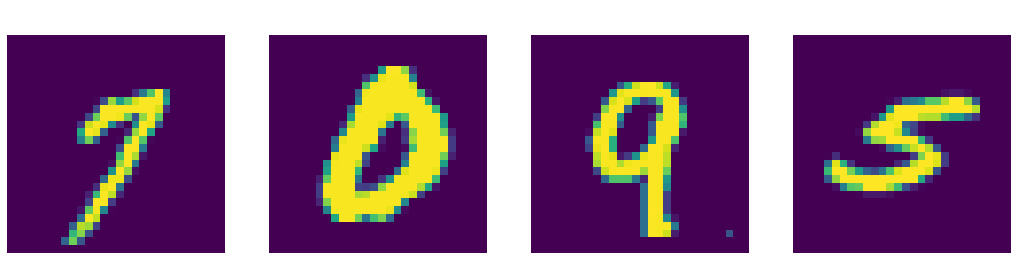

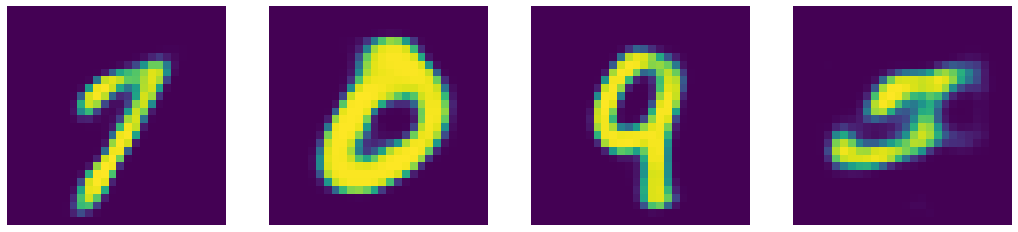

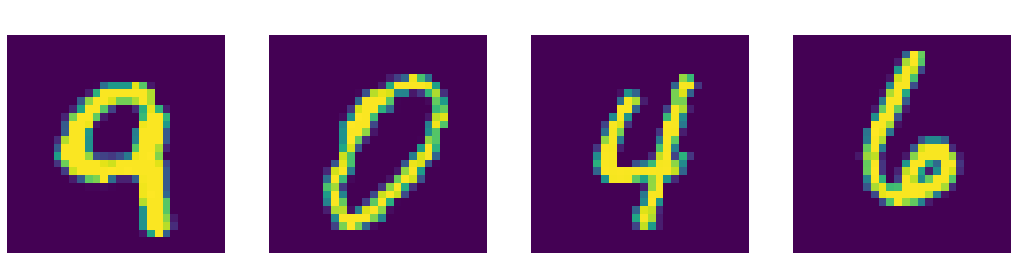

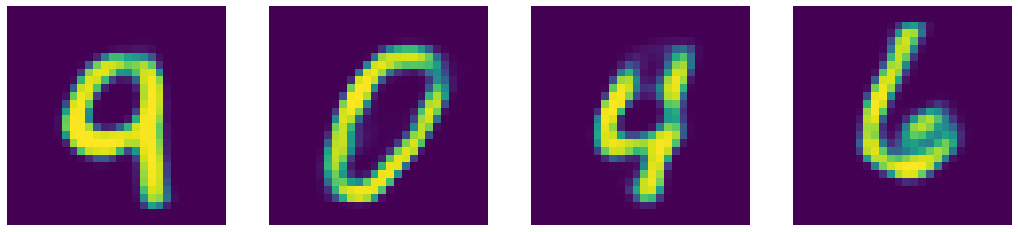

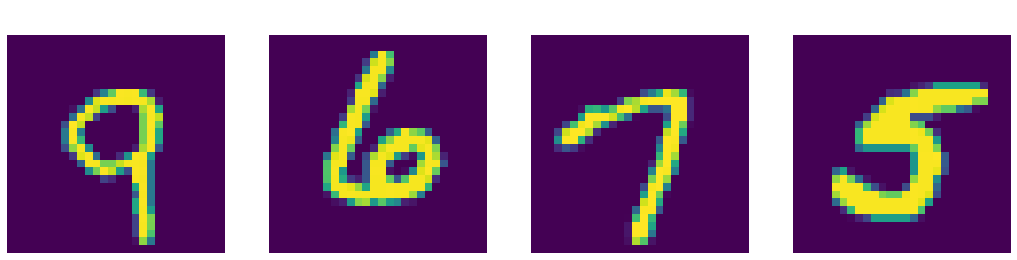

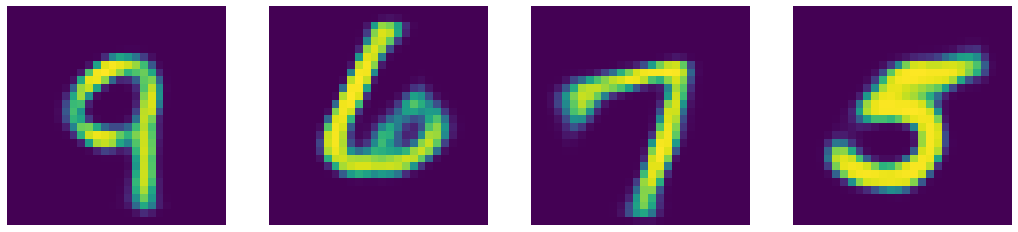

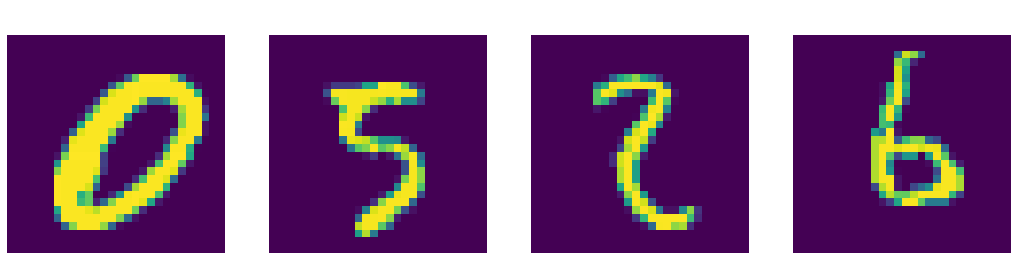

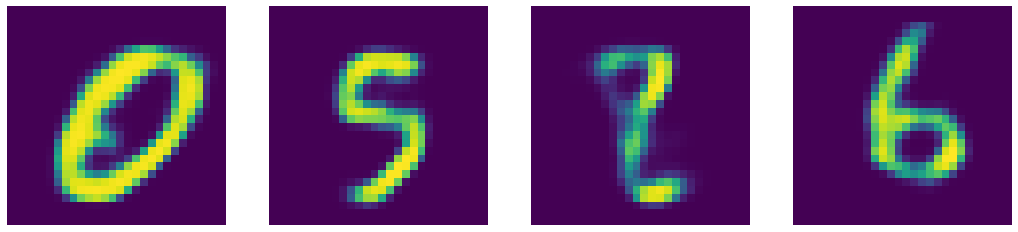

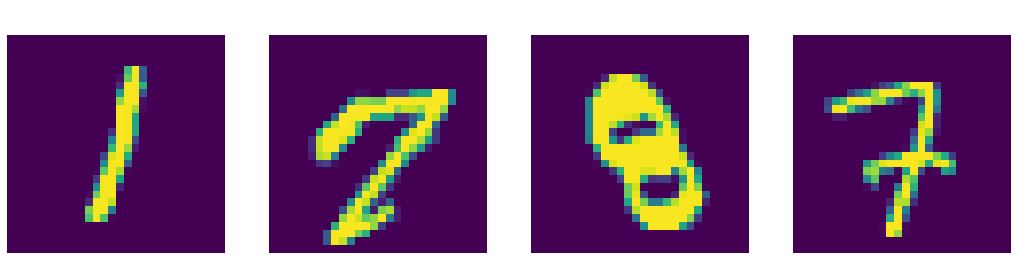

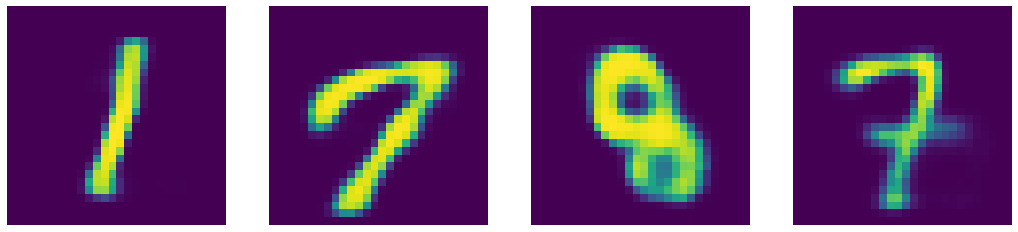

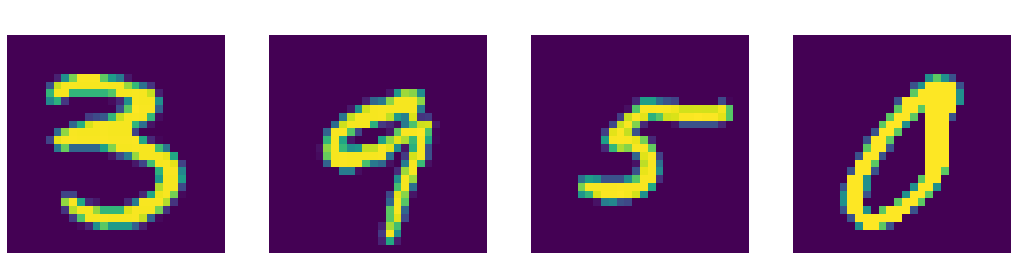

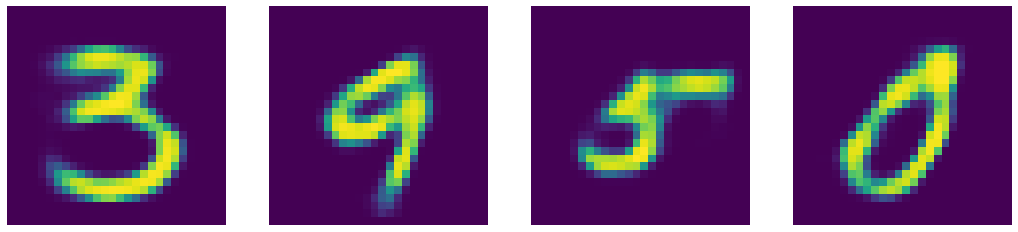

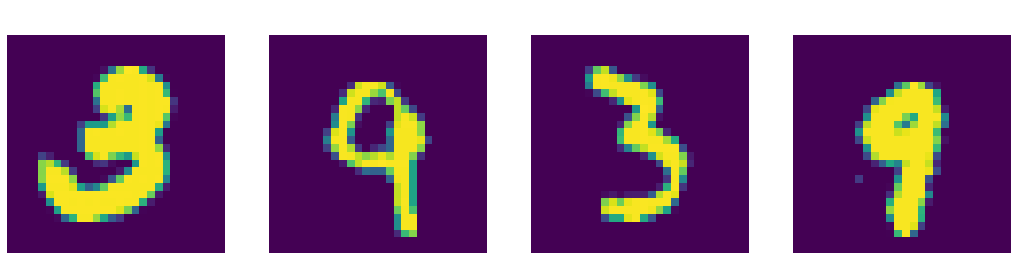

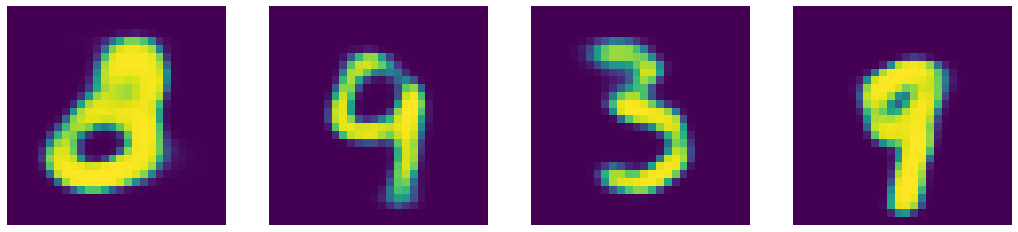

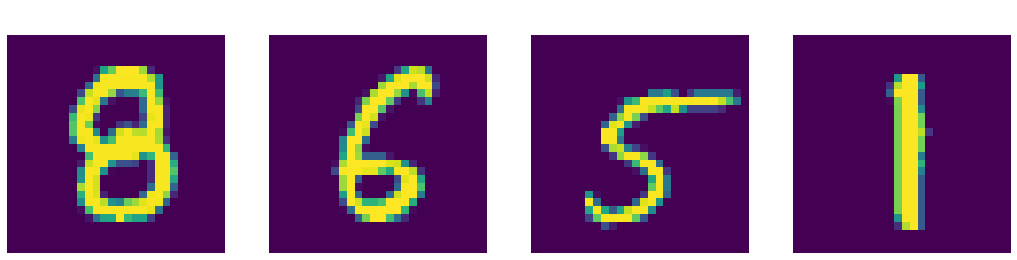

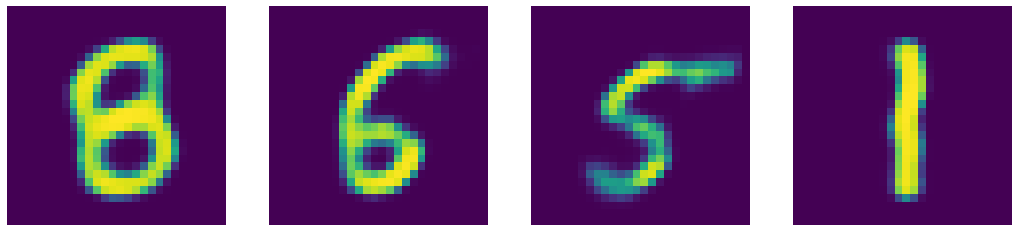

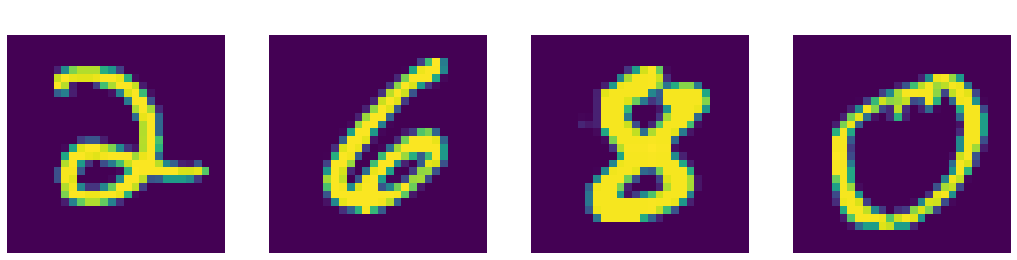

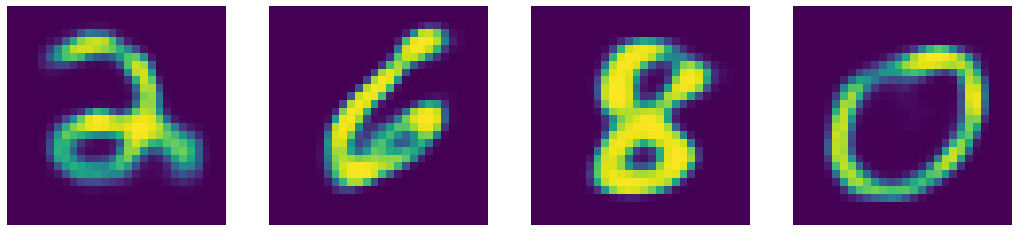

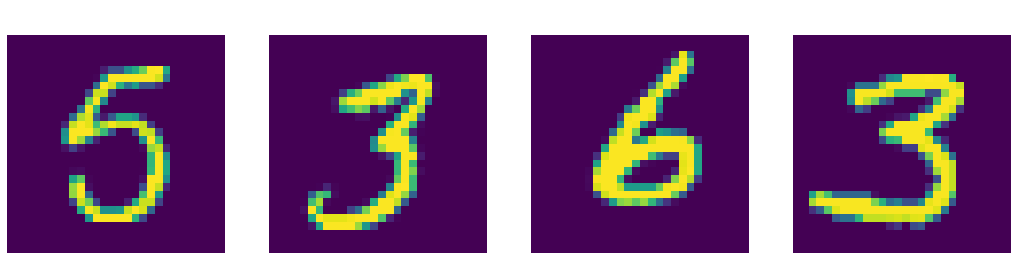

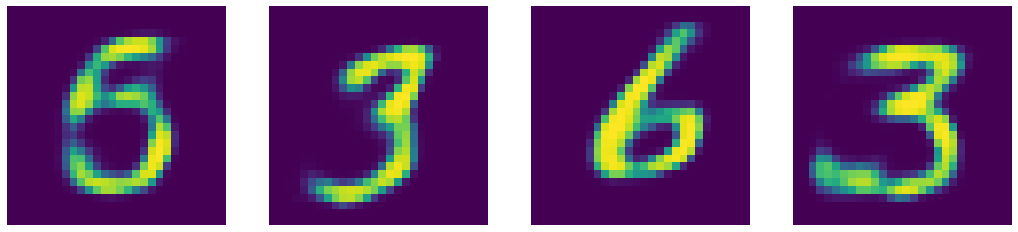

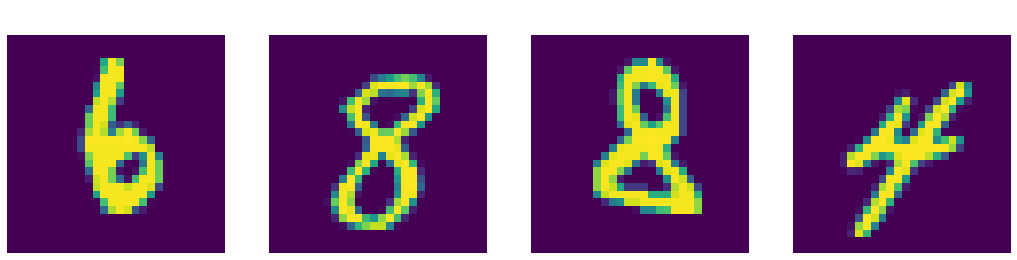

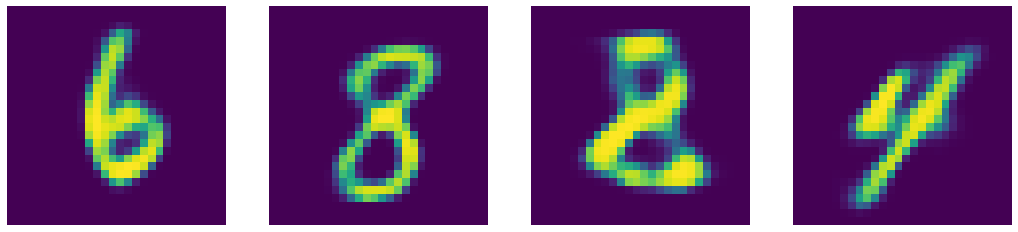

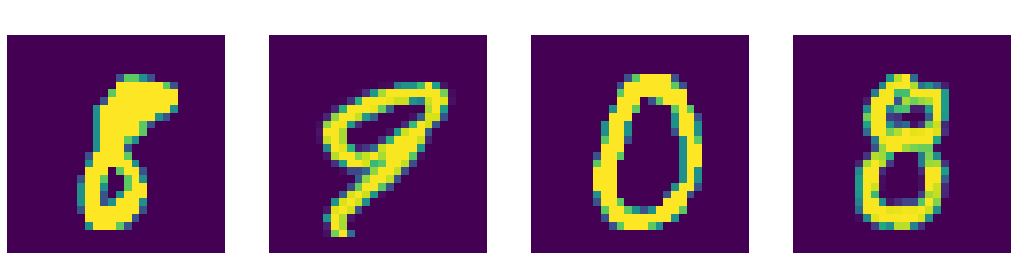

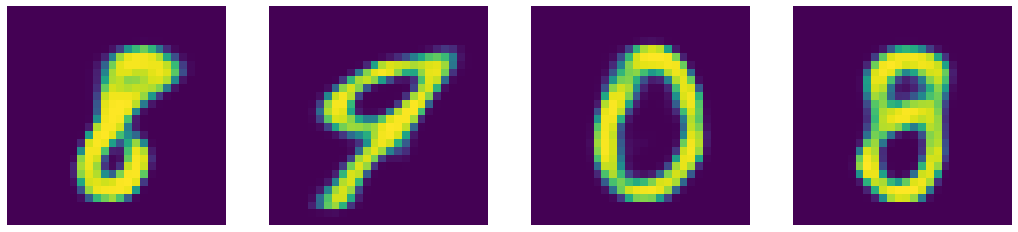

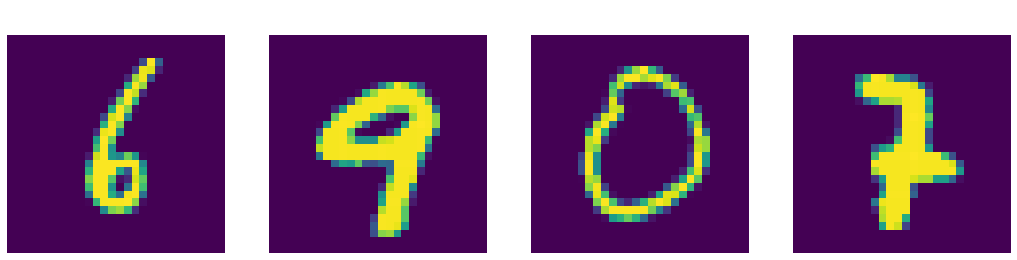

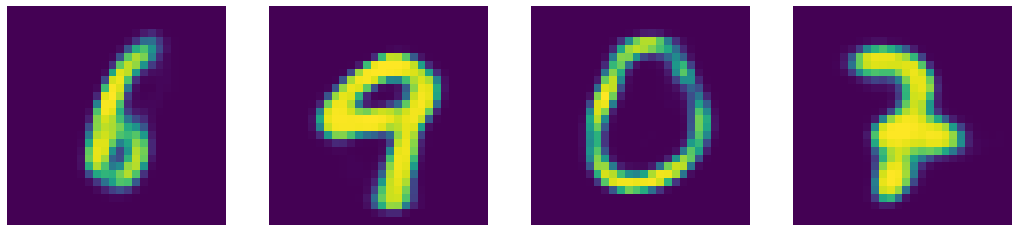

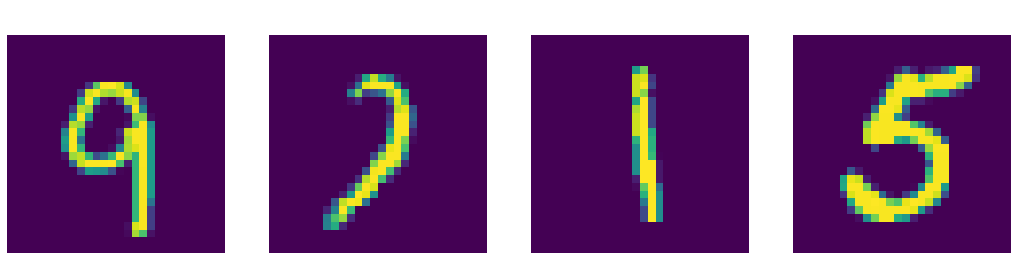

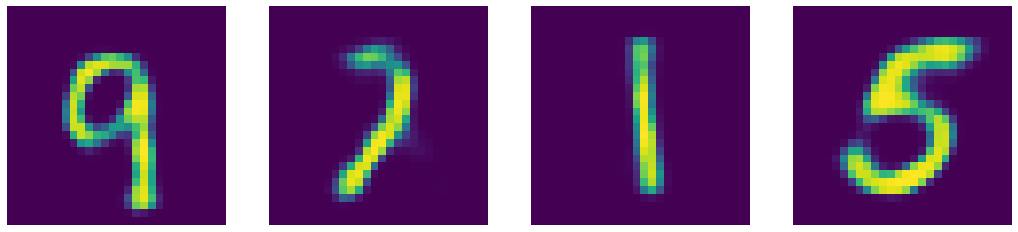

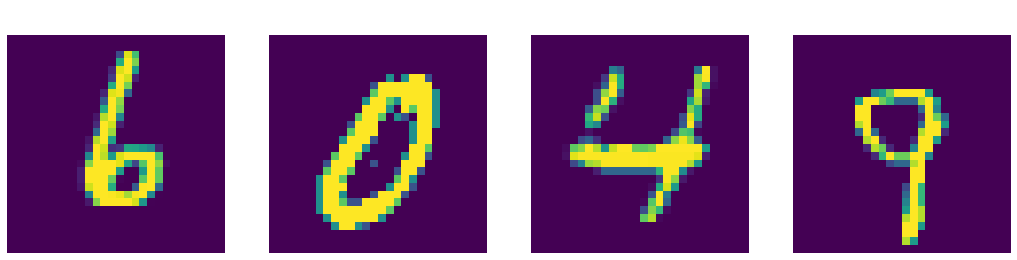

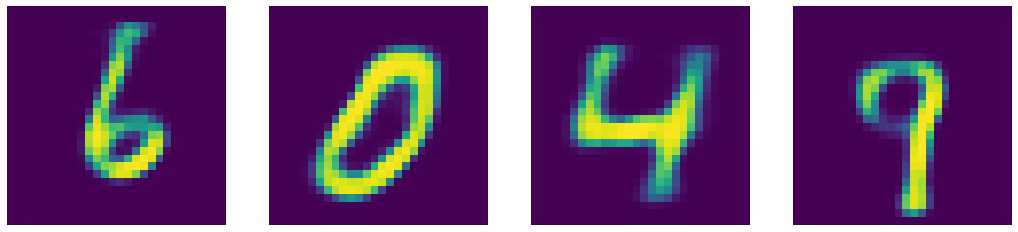

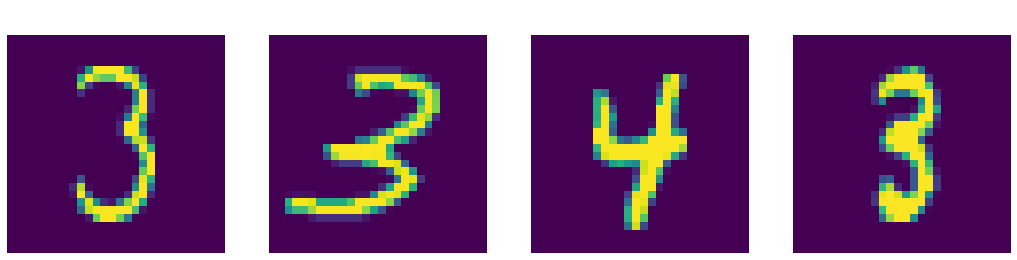

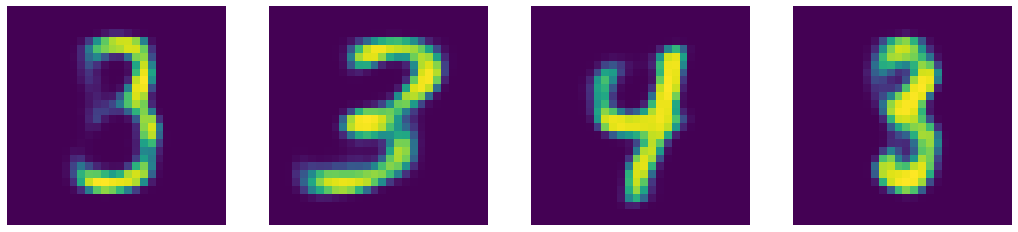

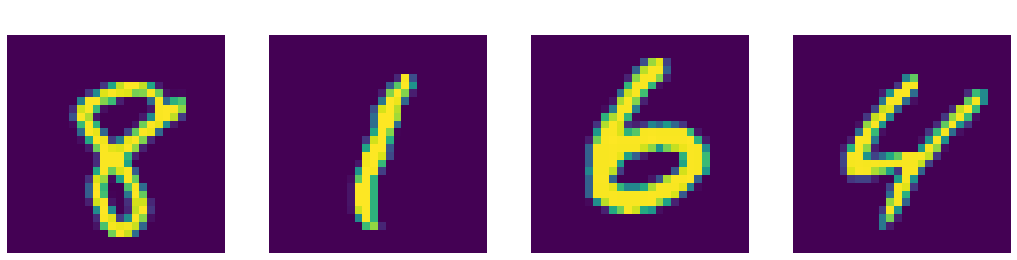

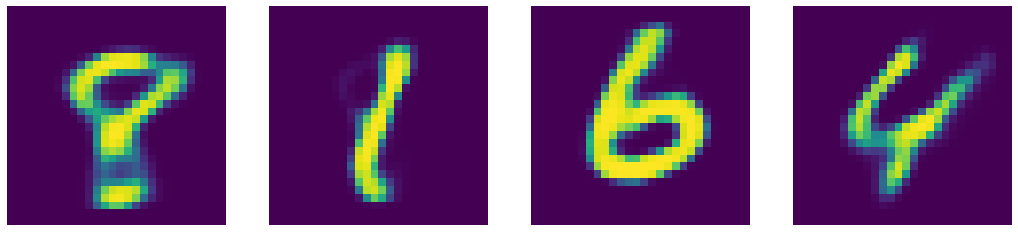

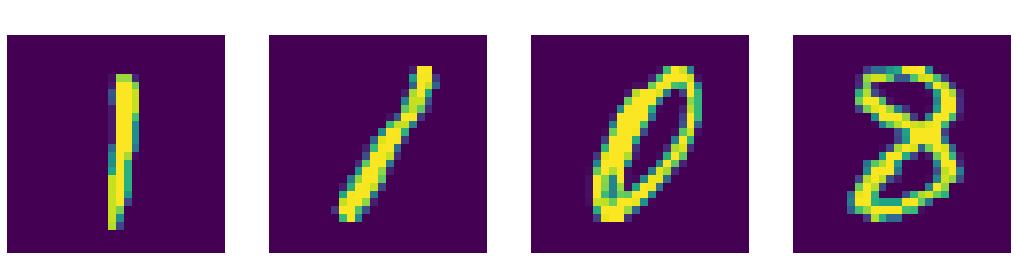

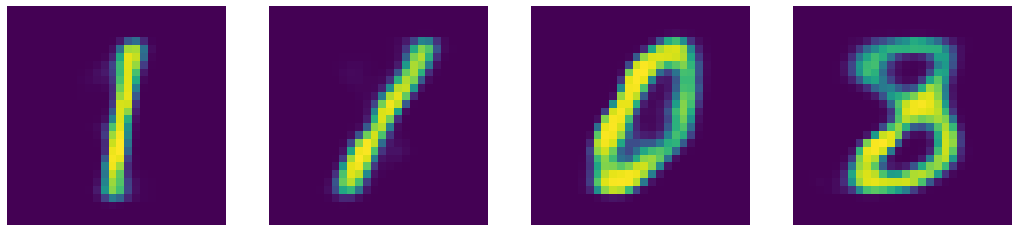

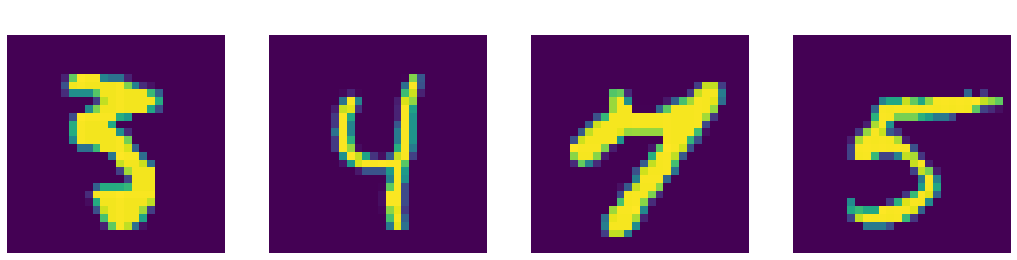

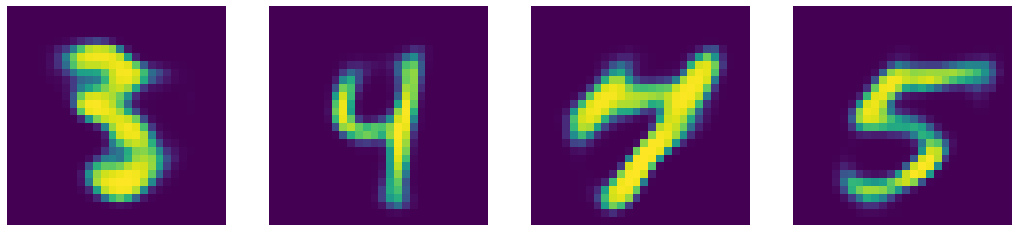

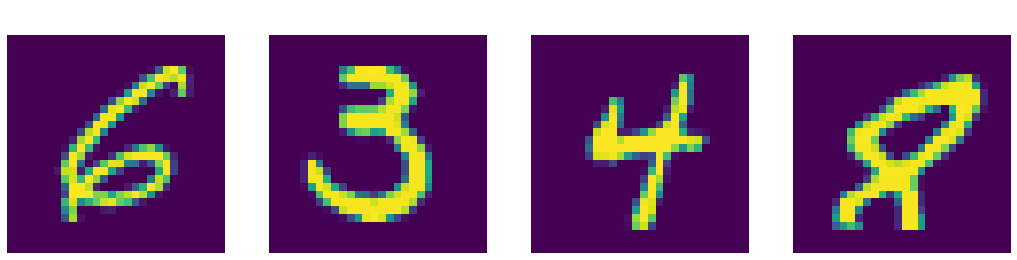

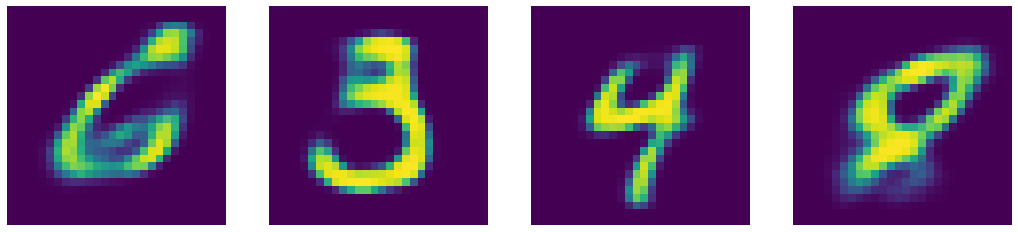

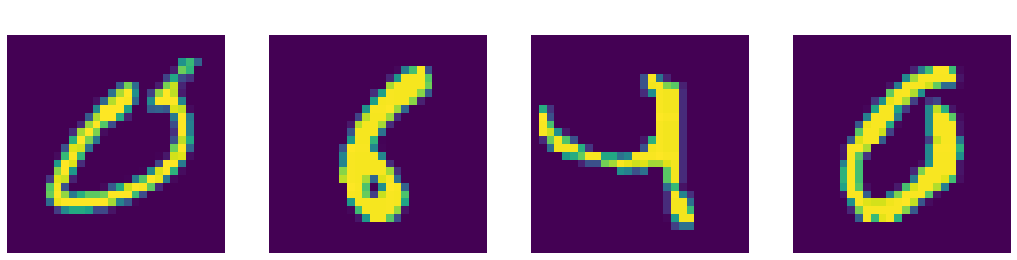

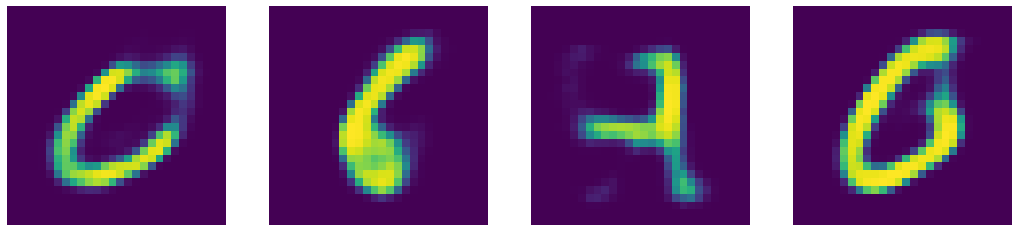

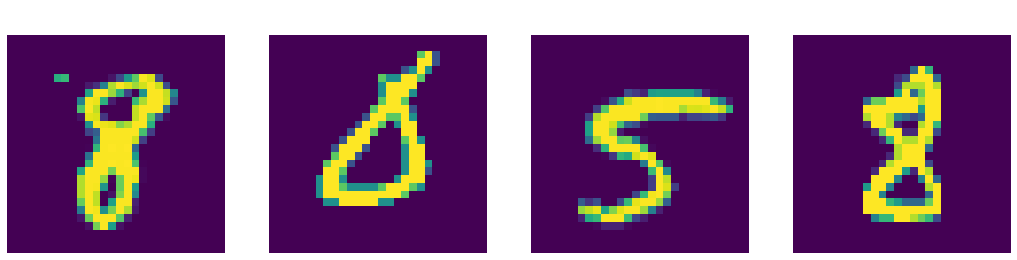

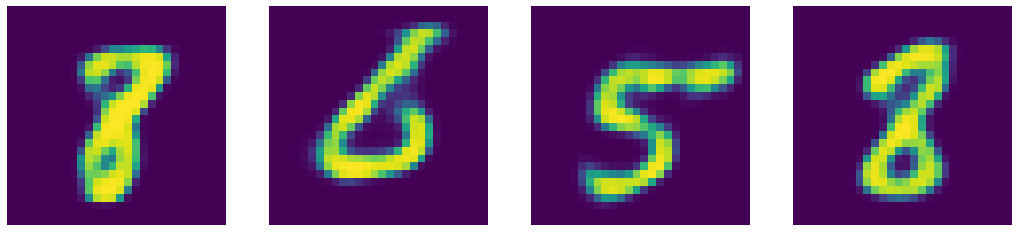

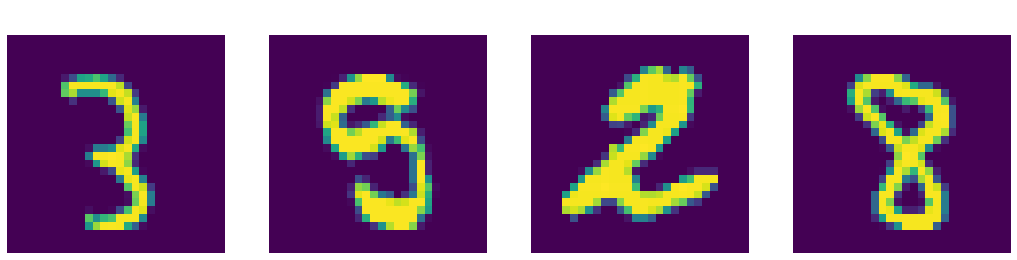

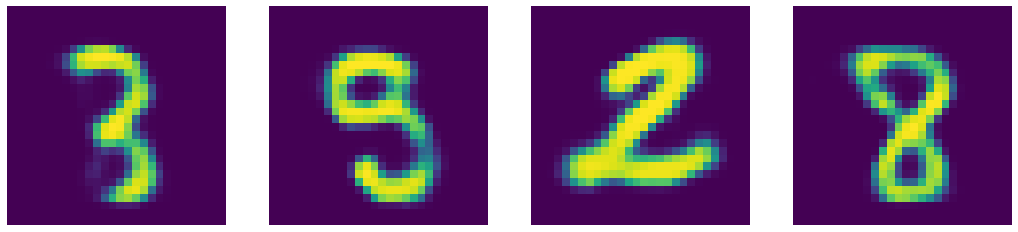

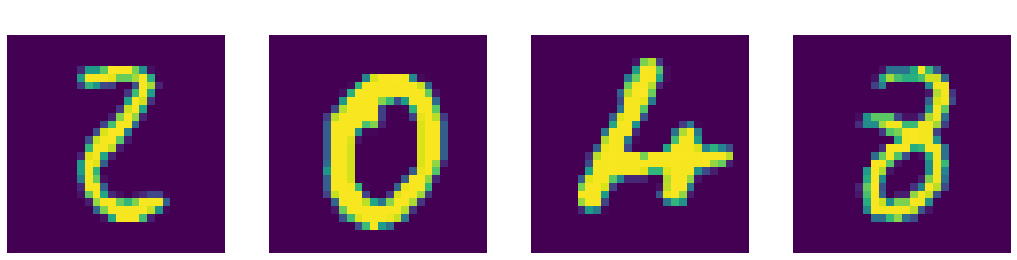

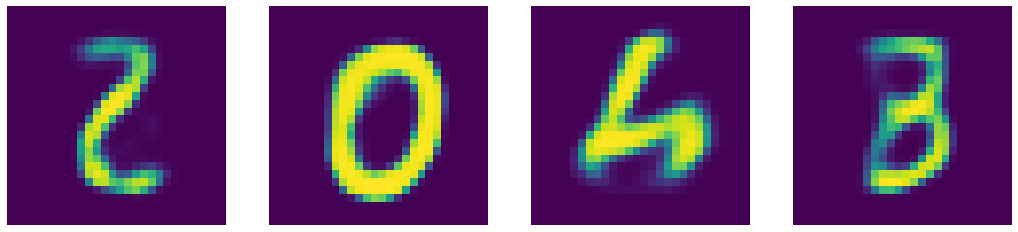

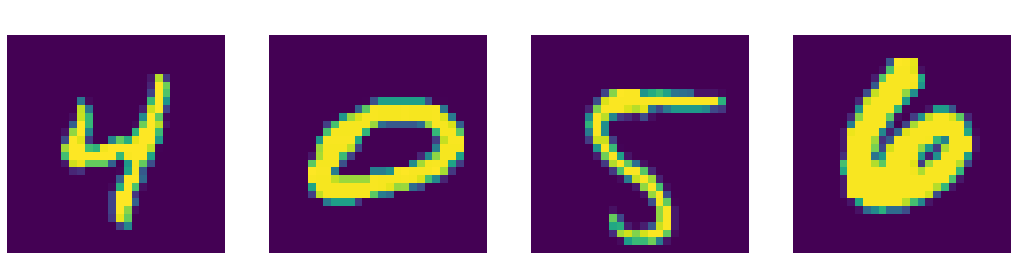

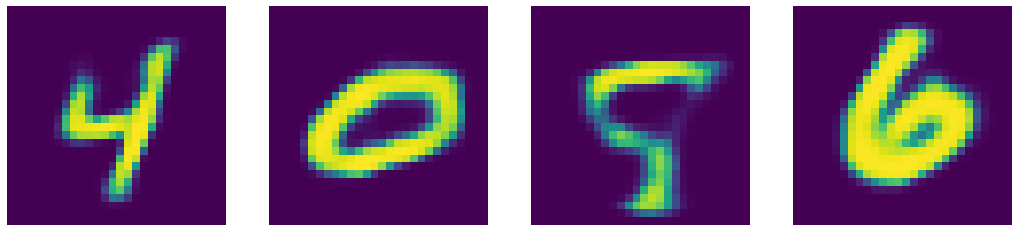

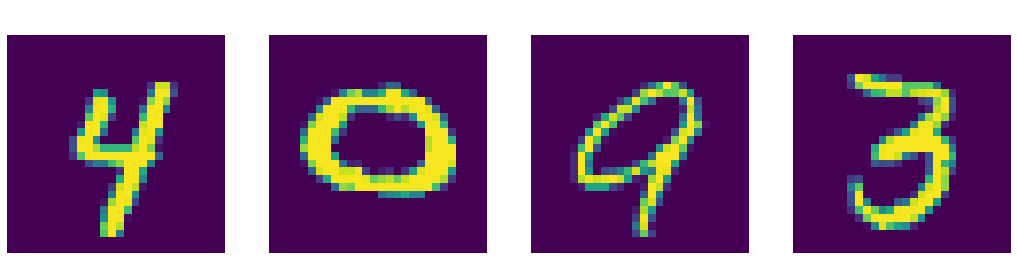

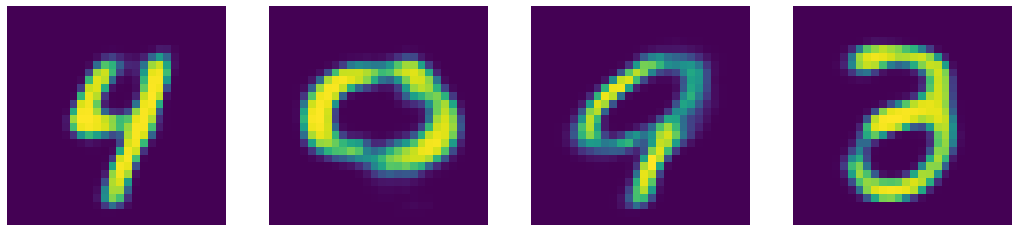

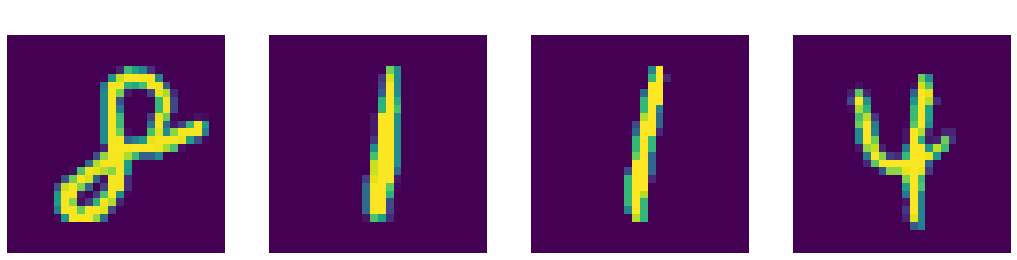

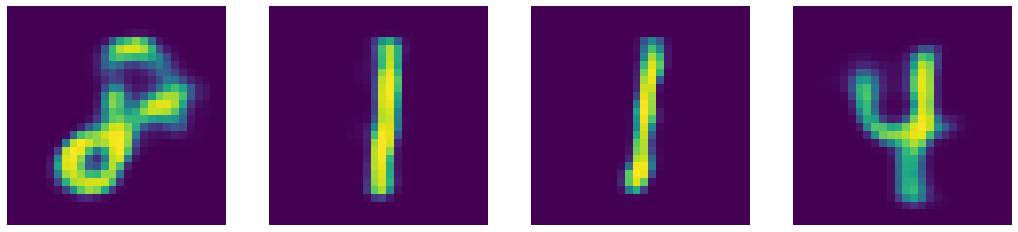

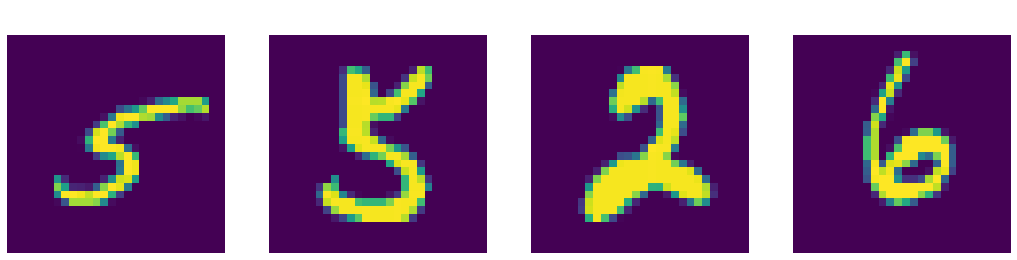

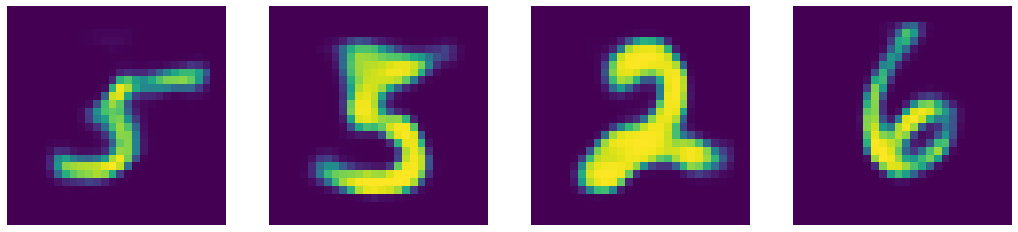

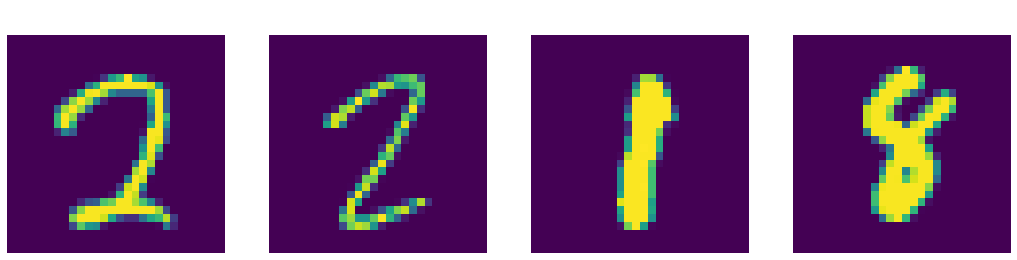

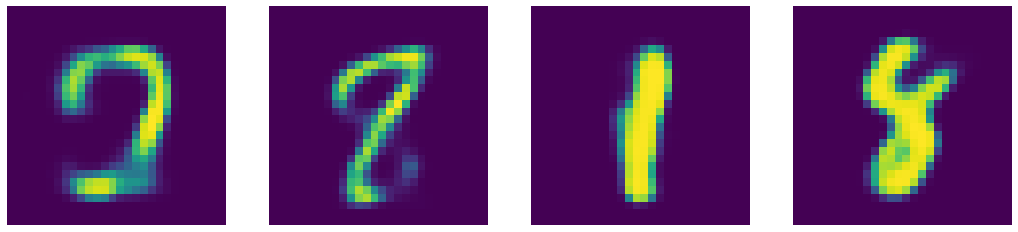

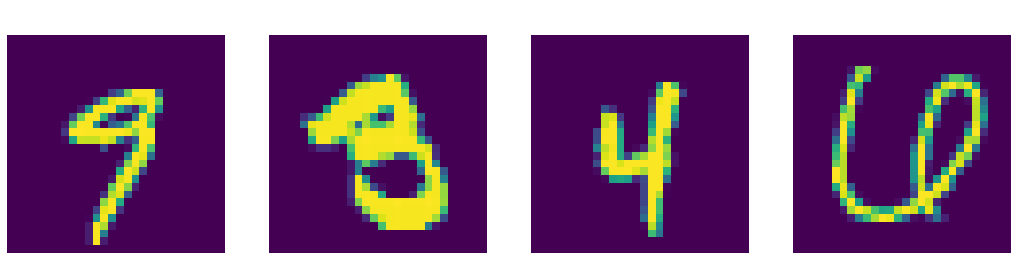

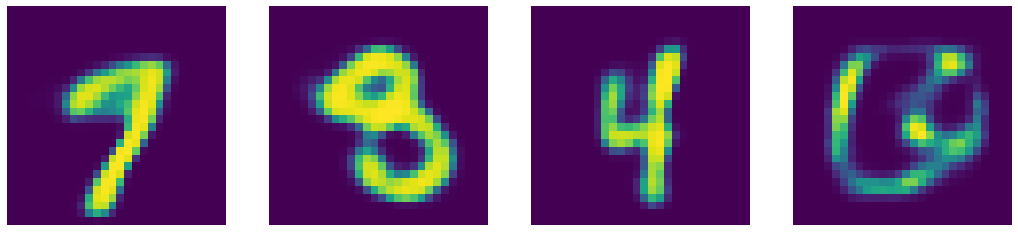

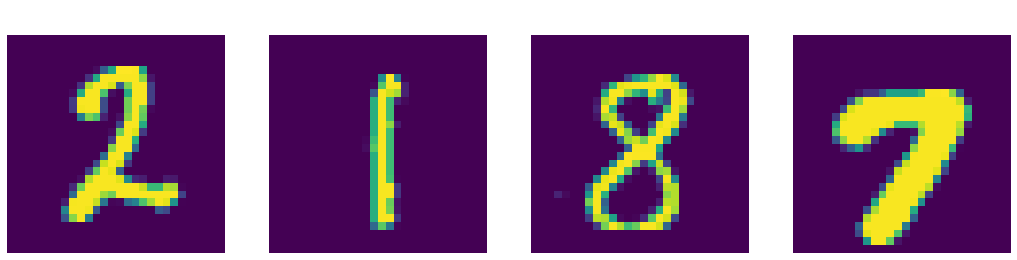

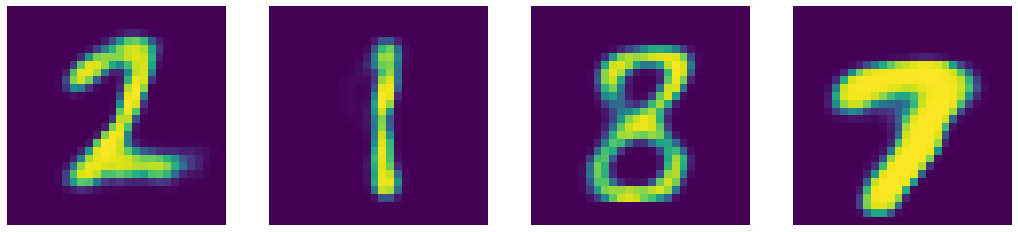

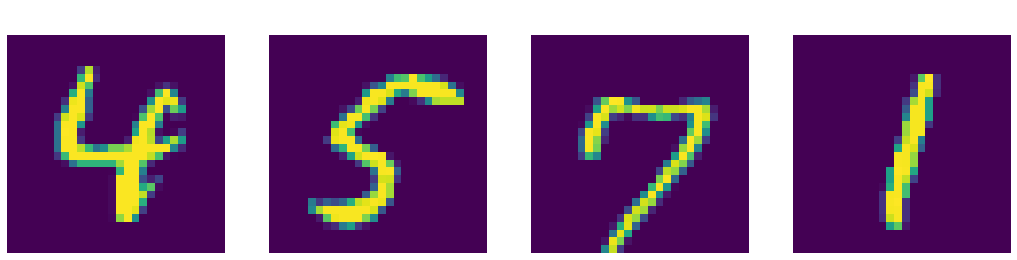

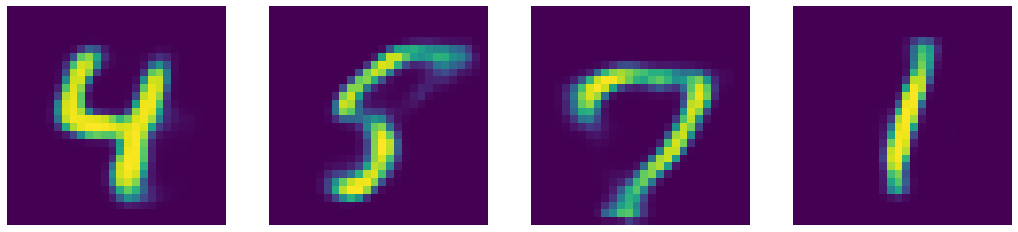

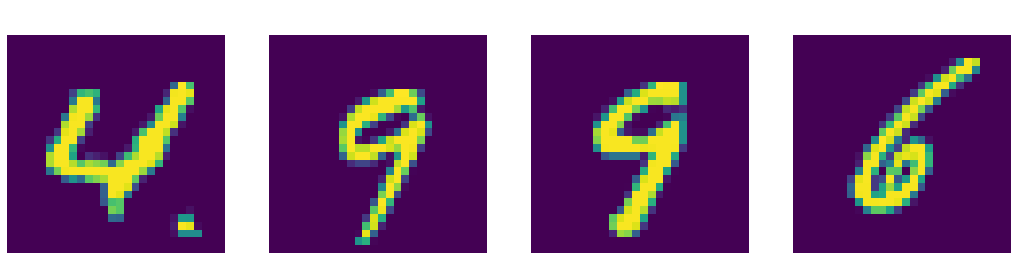

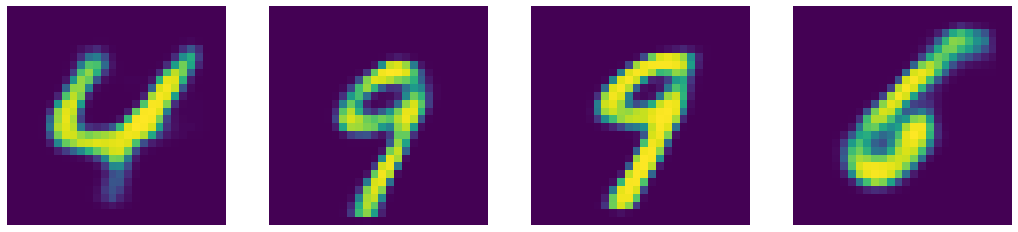

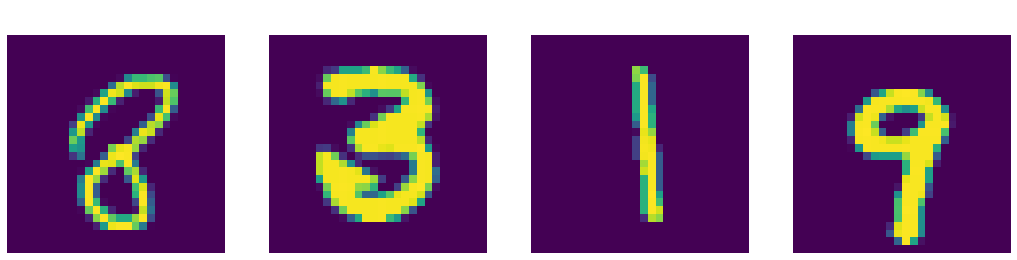

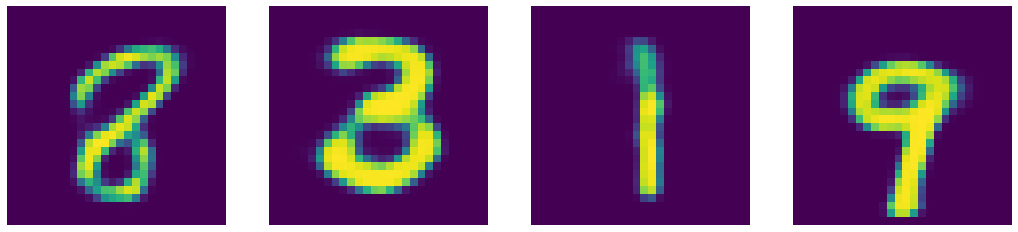

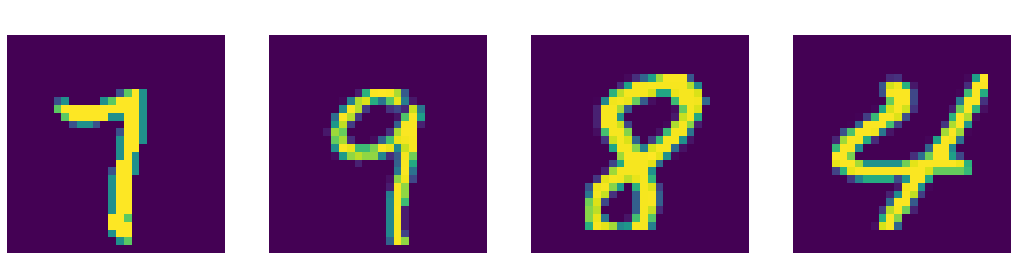

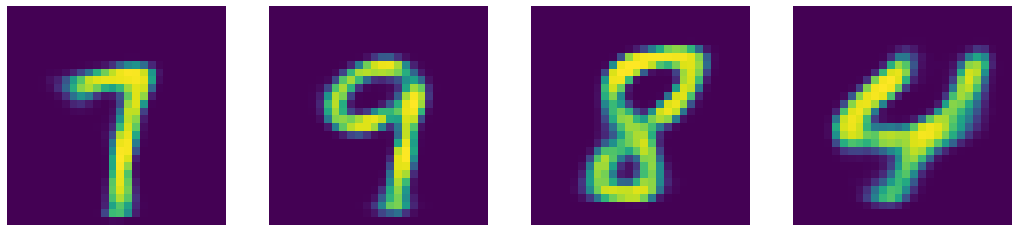

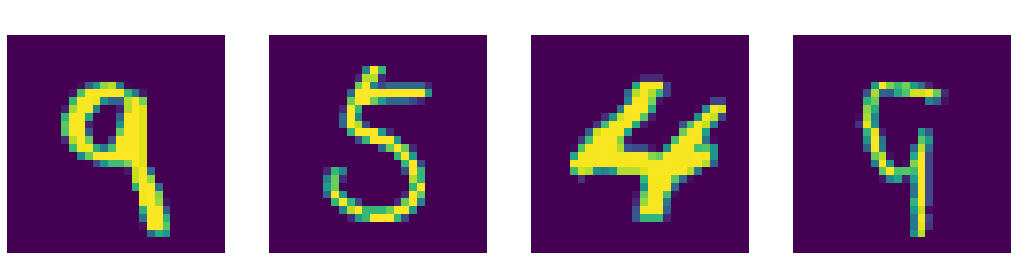

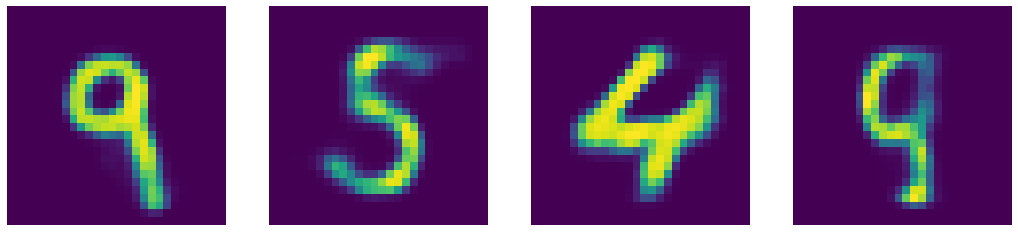

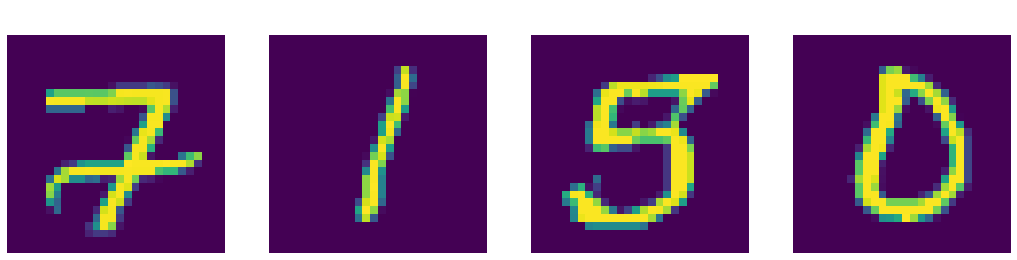

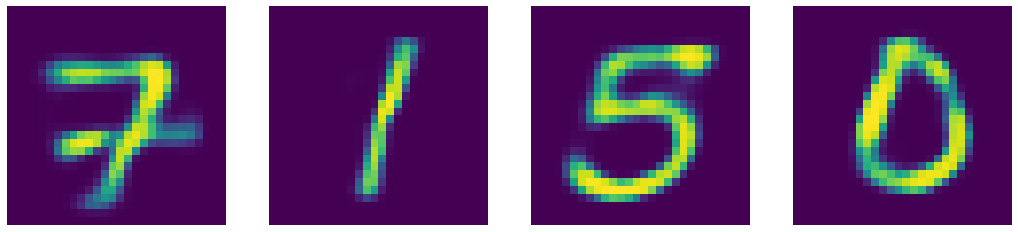

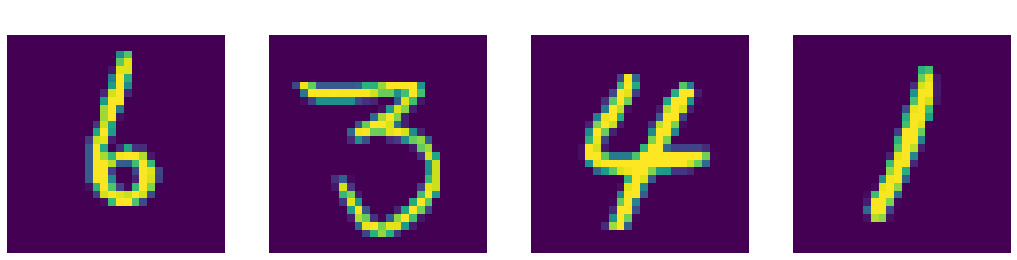

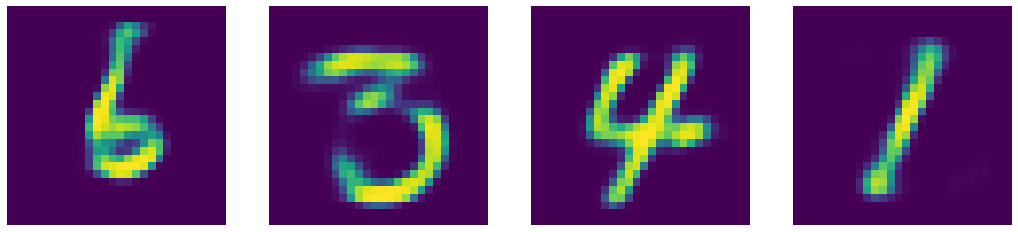

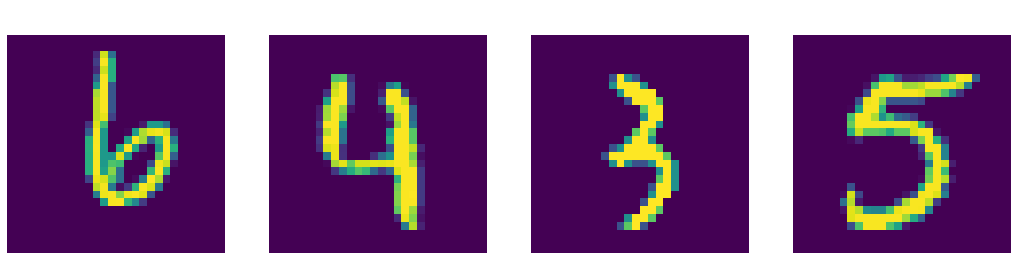

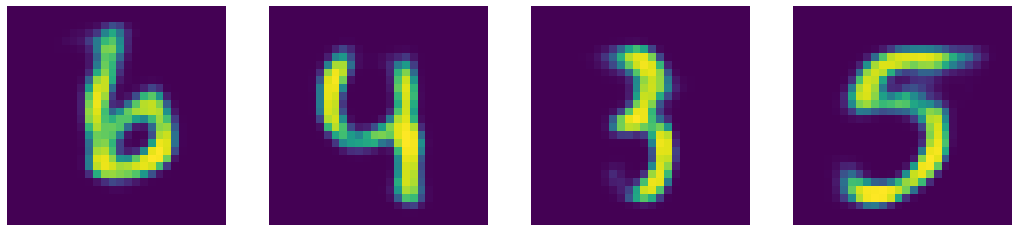

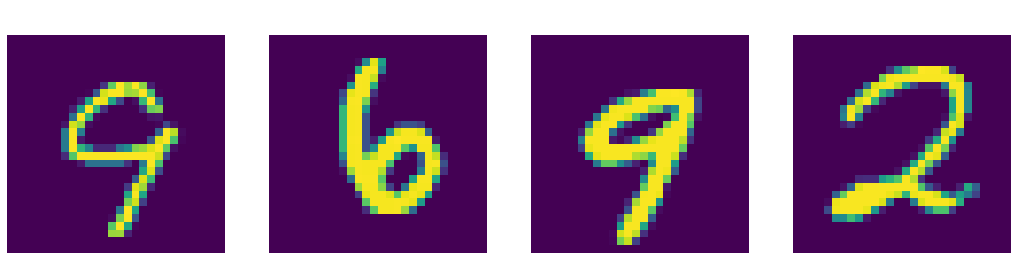

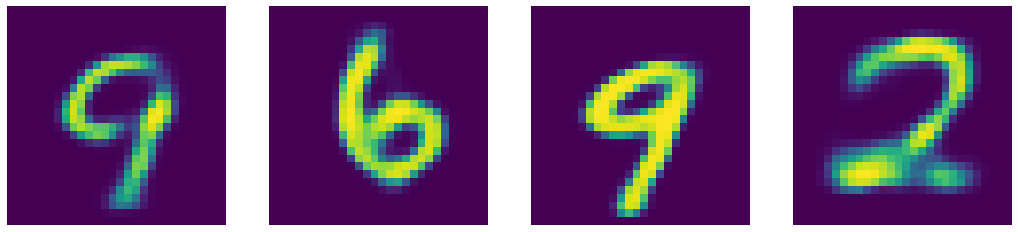

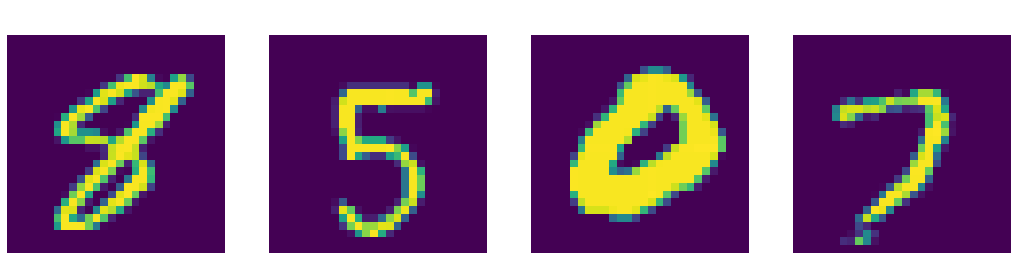

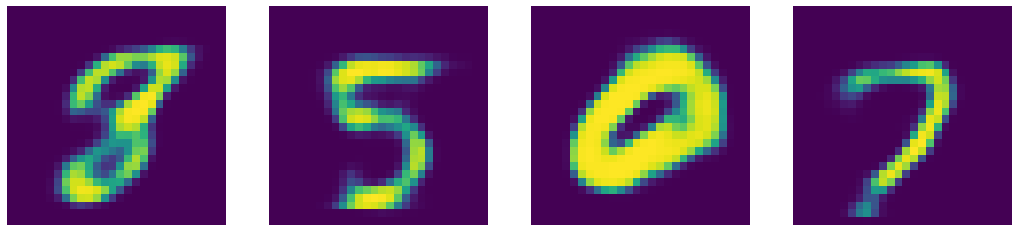

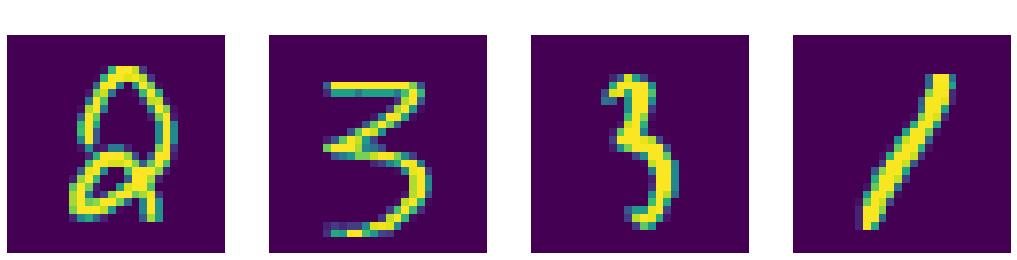

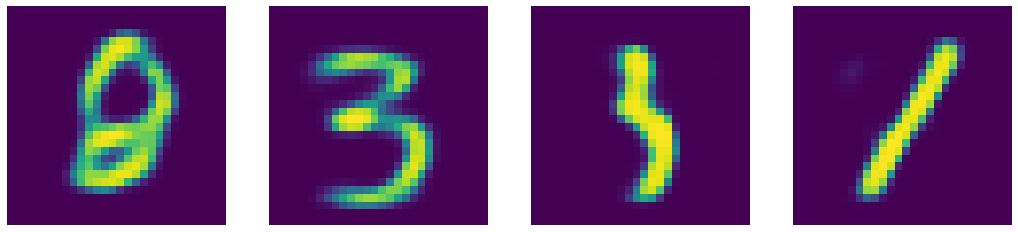

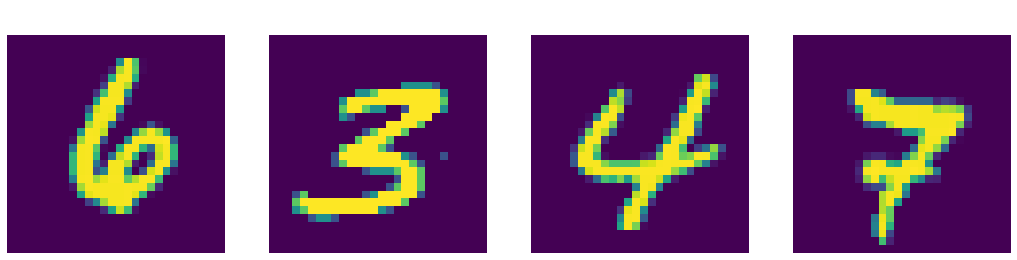

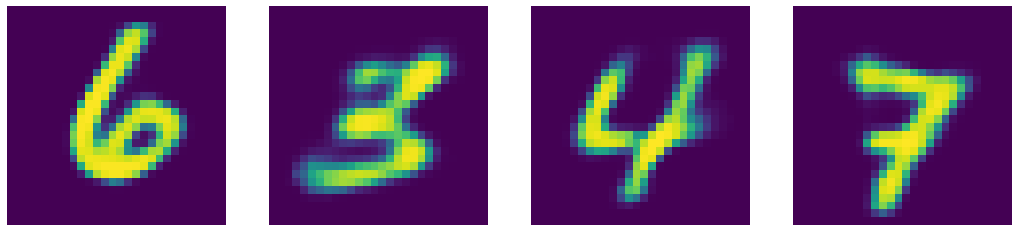

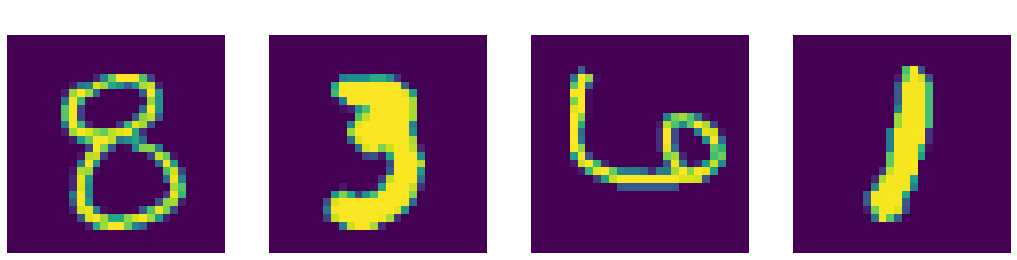

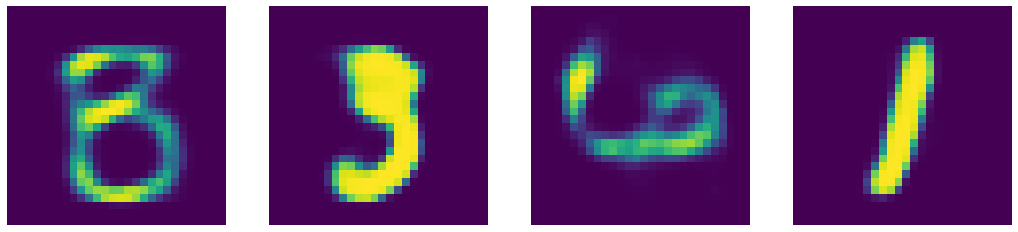

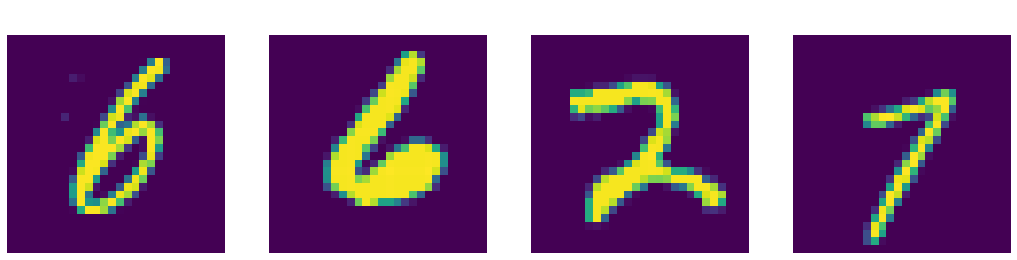

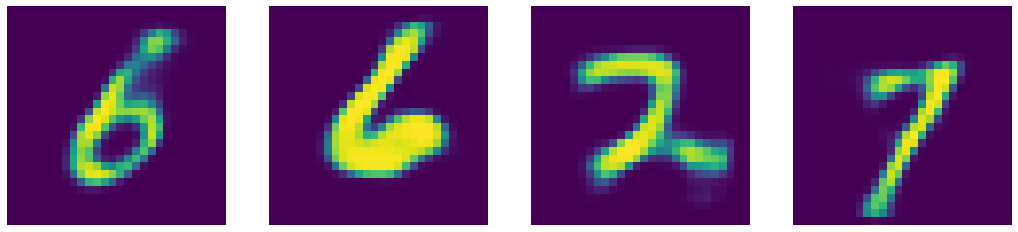

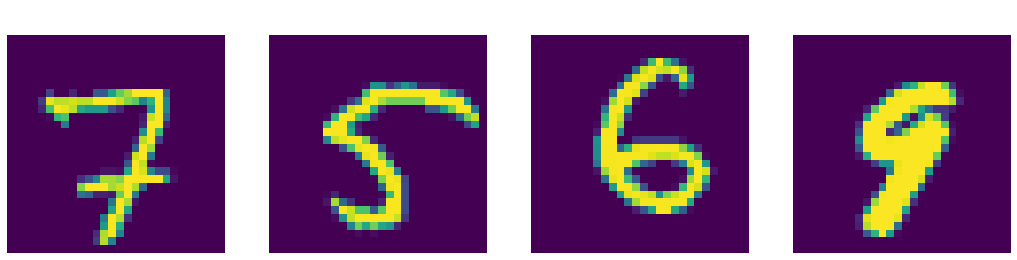

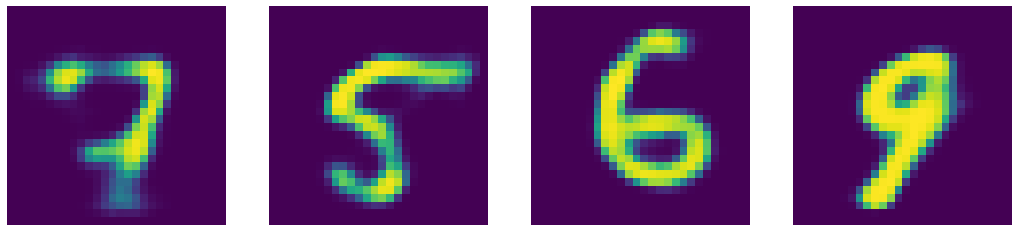

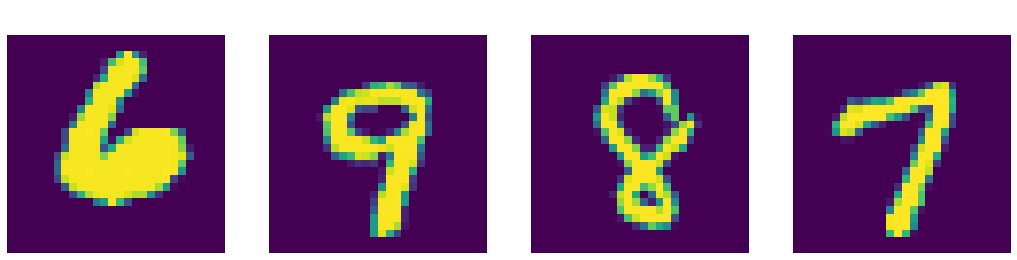

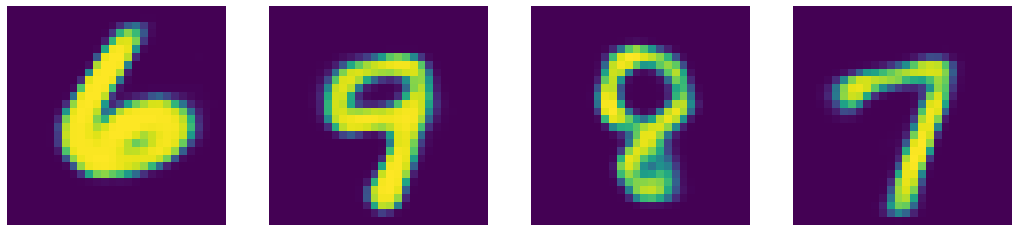

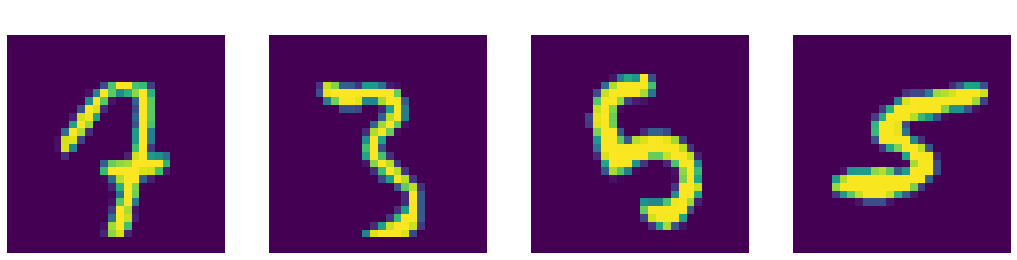

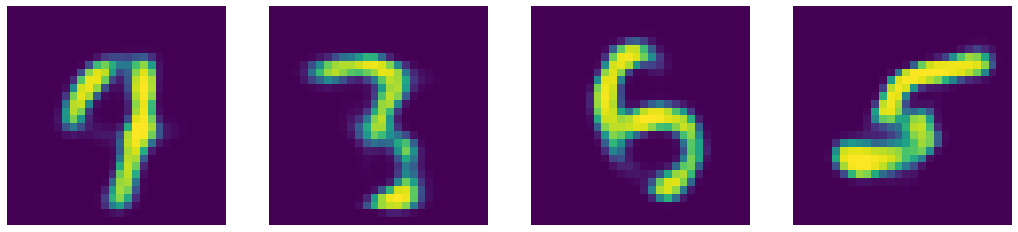

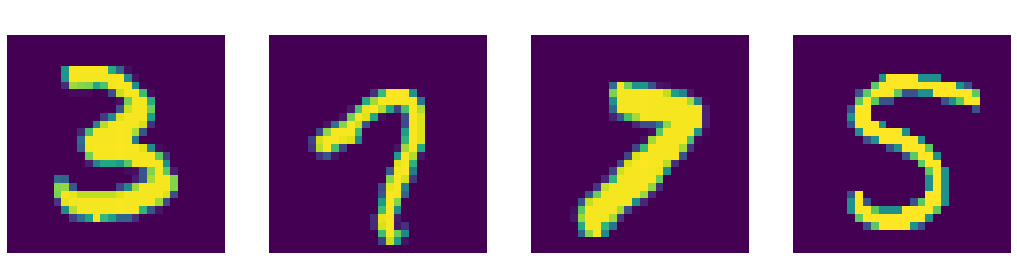

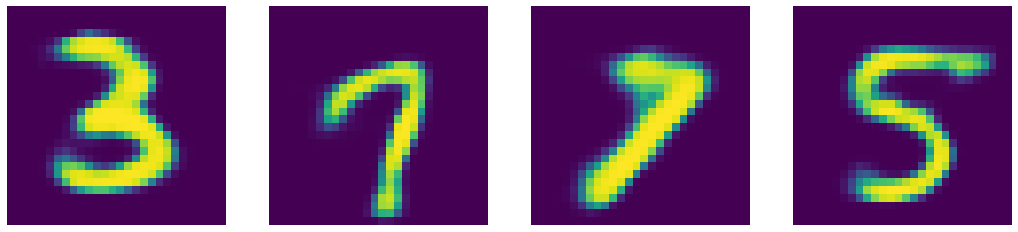

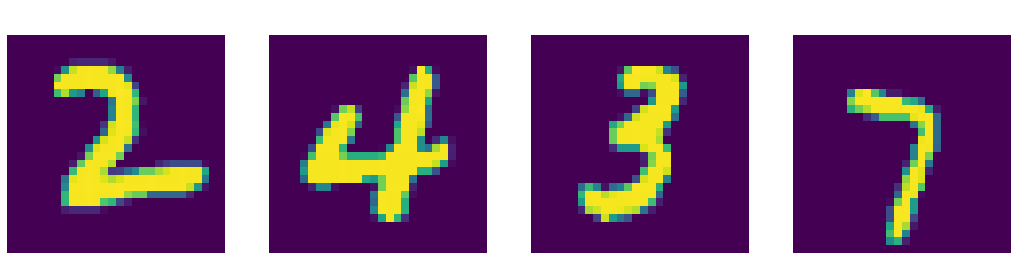

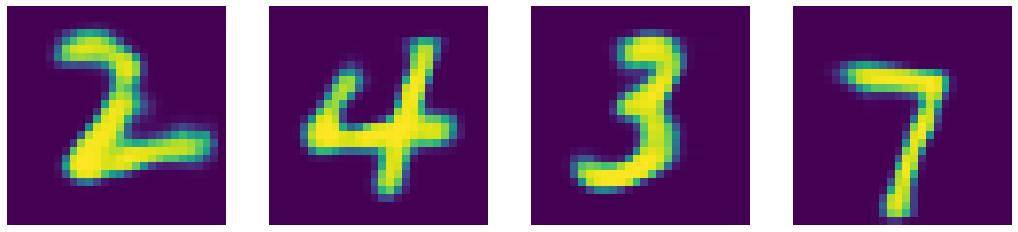

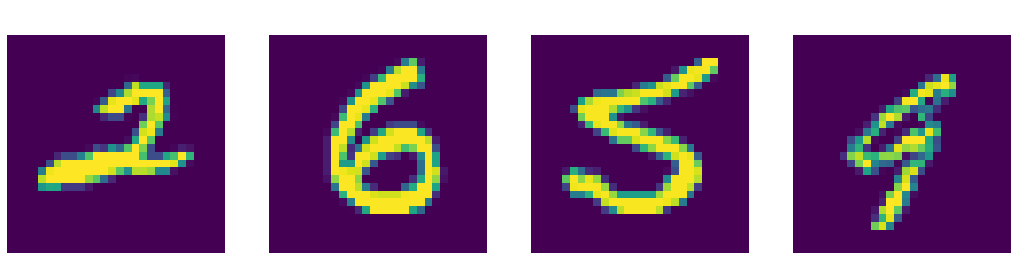

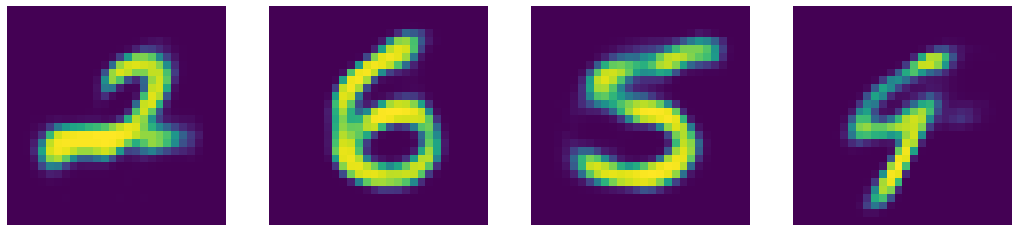

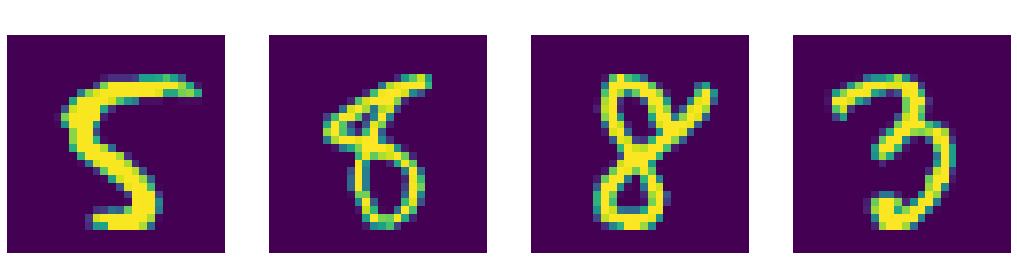

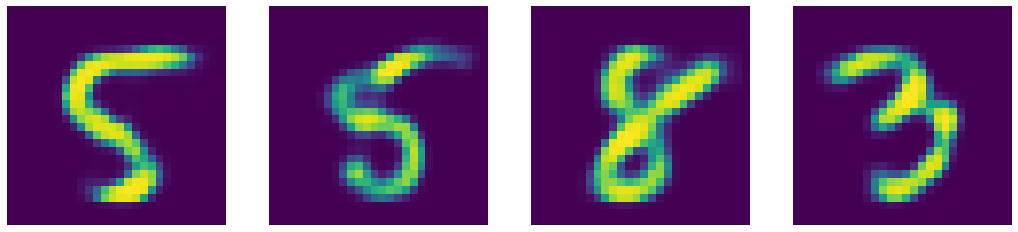

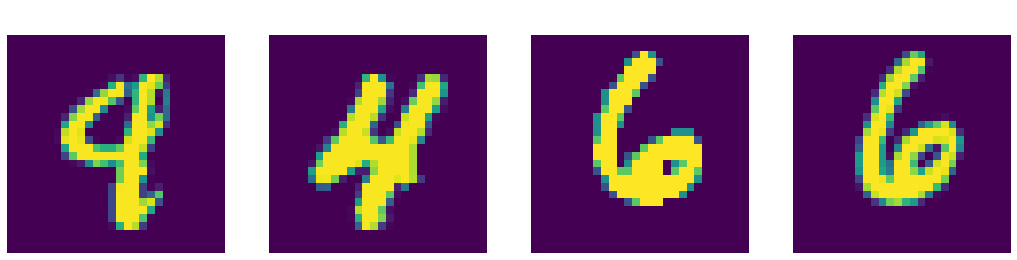

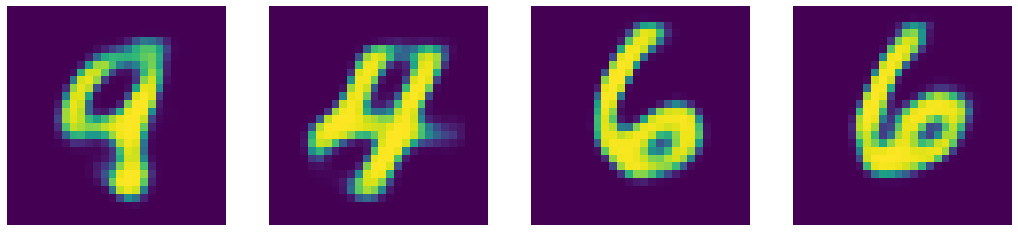

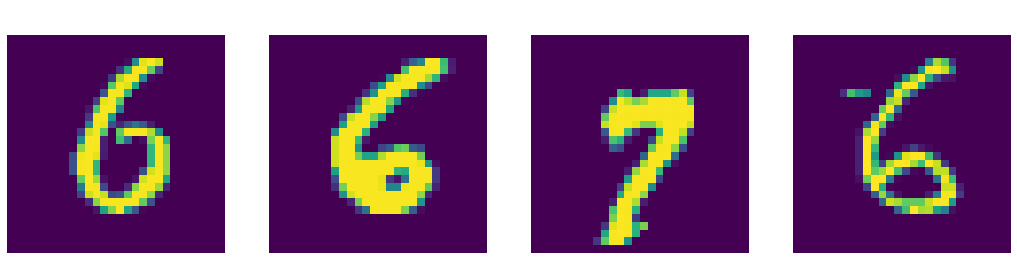

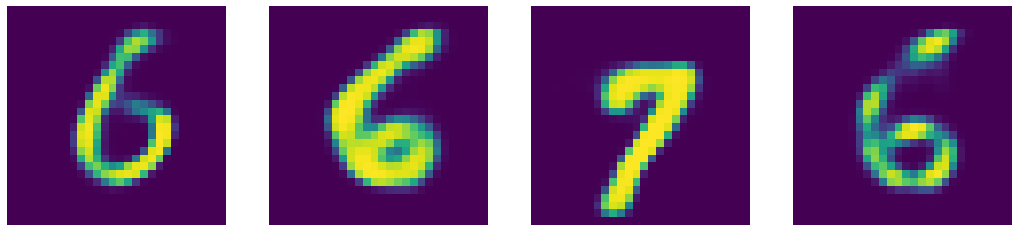

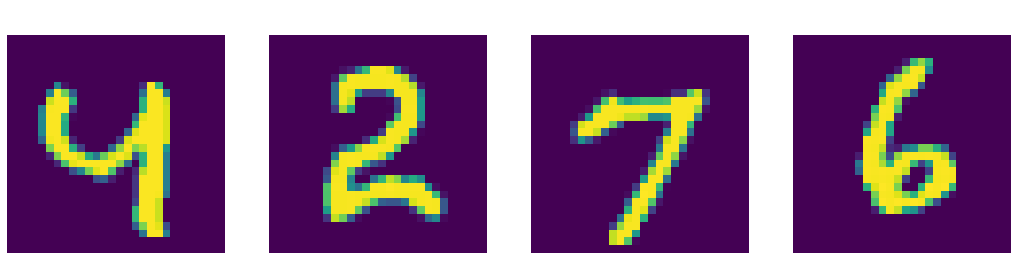

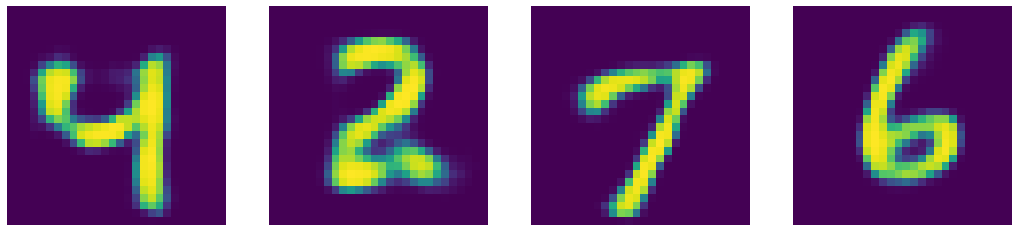

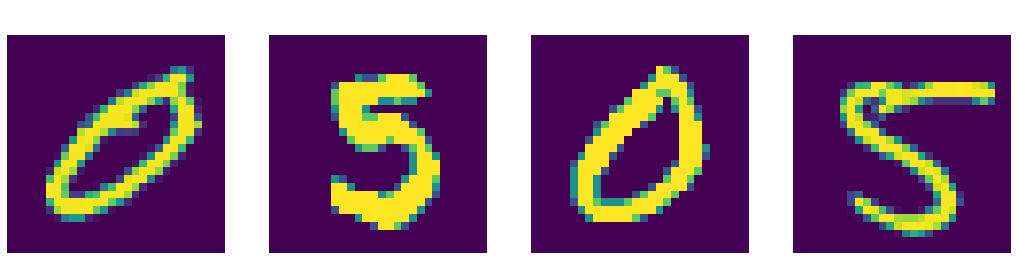

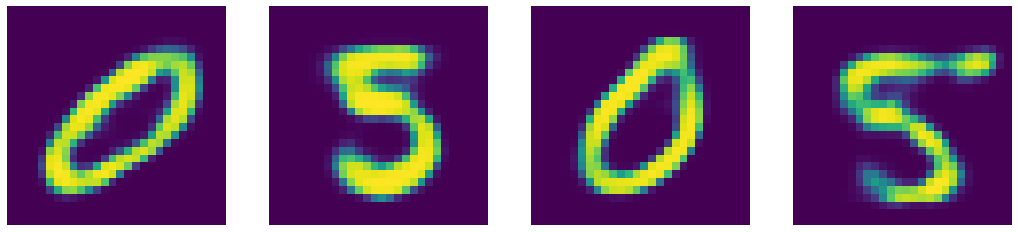

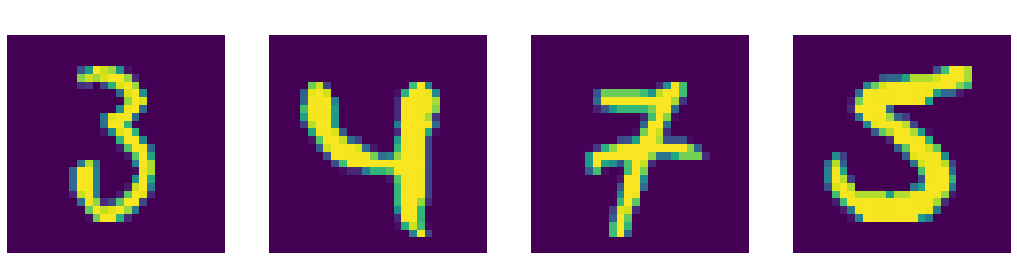

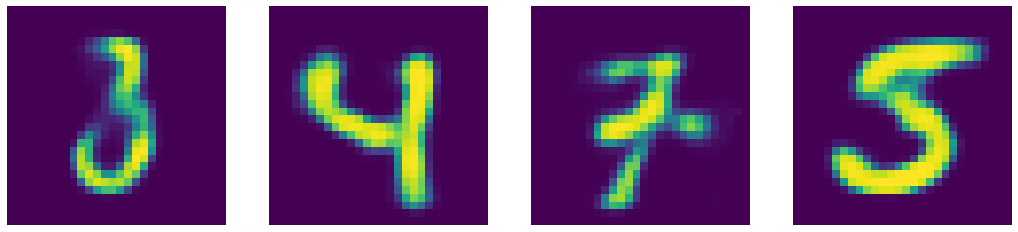

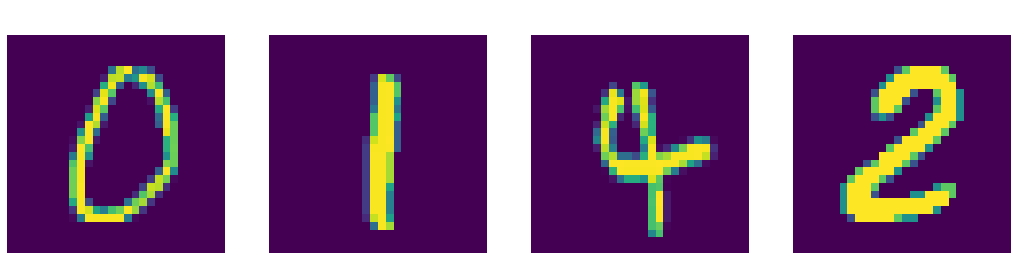

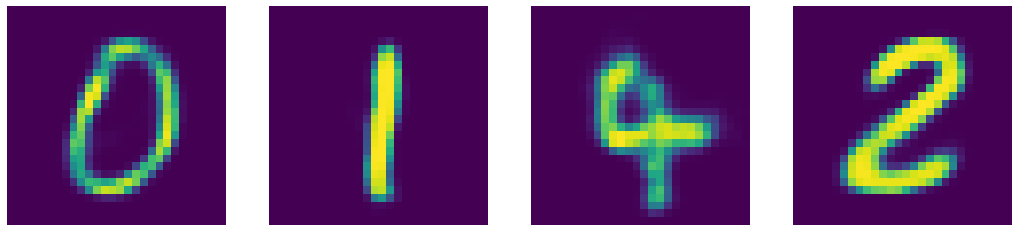

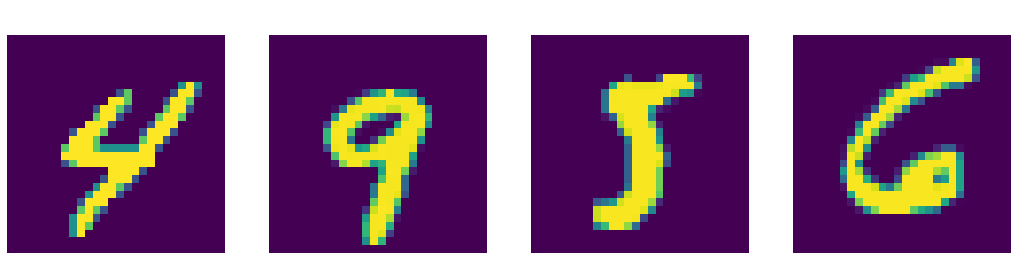

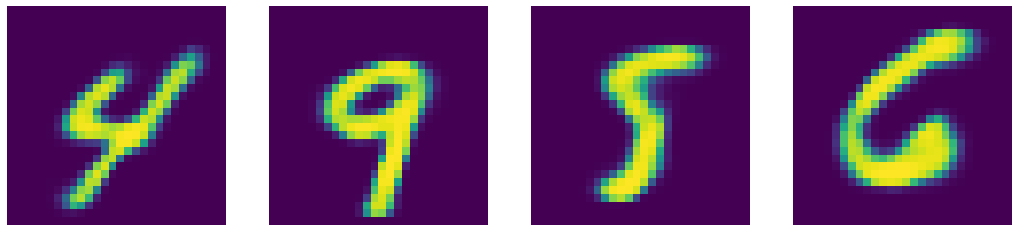

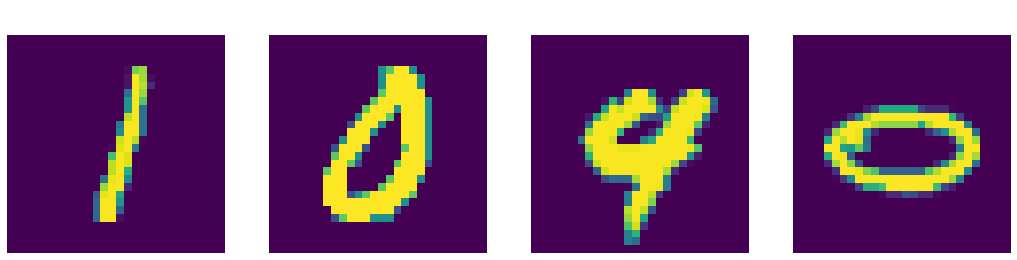

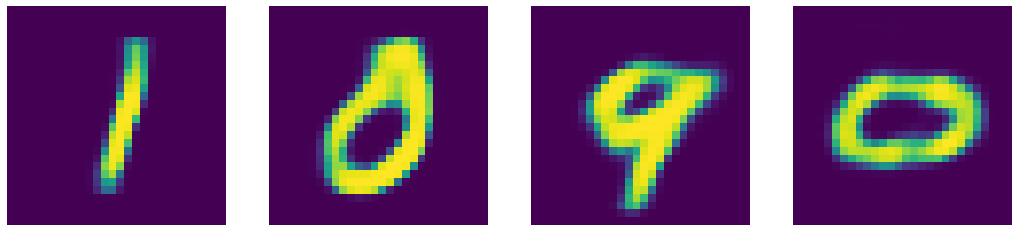

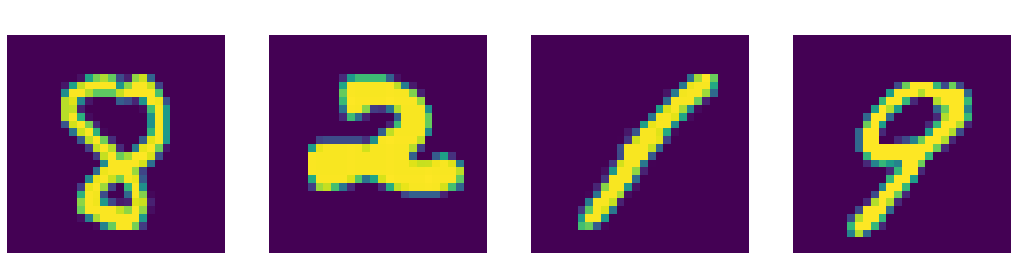

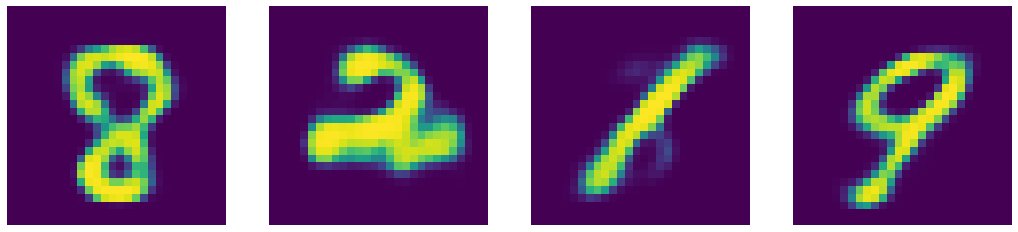

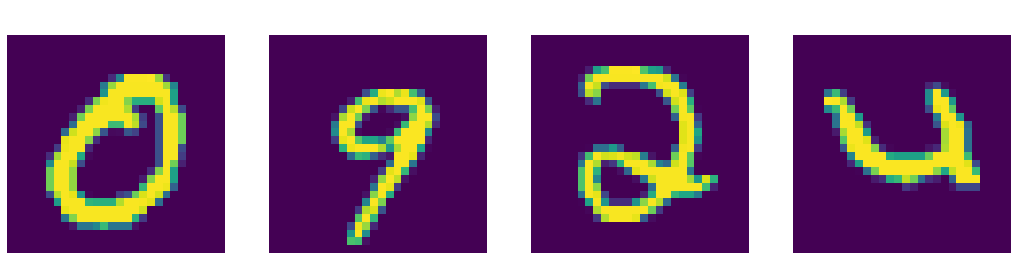

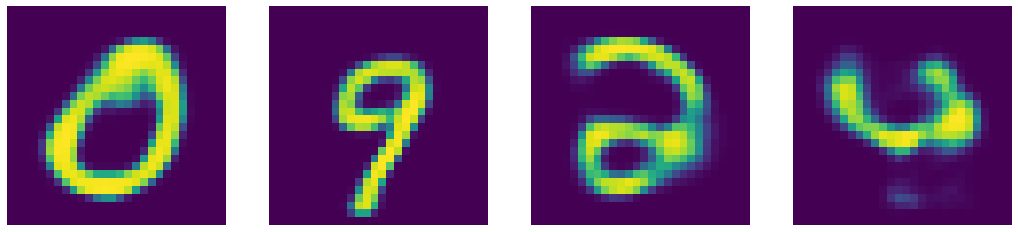

In [9]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')
                
                
with torch.no_grad():
    model.eval()
    for x, y in test_loader:
        # ===================forward=====================
        out, mu, logvar = model(x)
        display_images(x , out , 1 , "images")


<ipython-input-9-95e855b49a27>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 4))
<ipython-input-9-95e855b49a27>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))


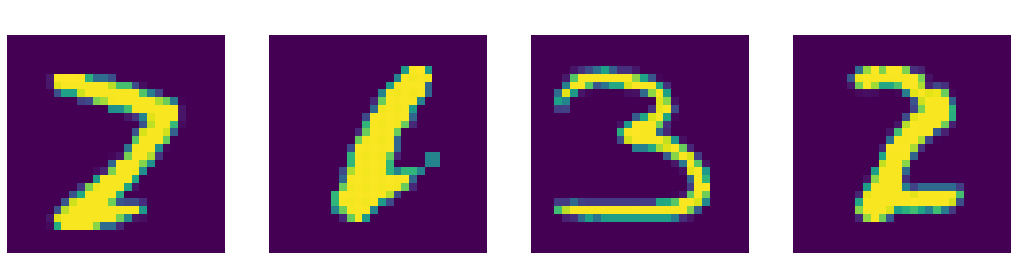

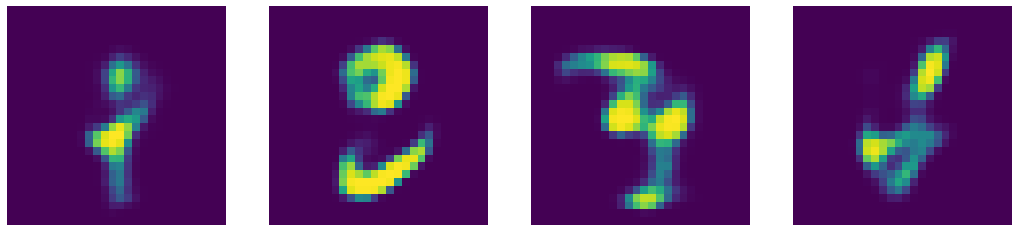

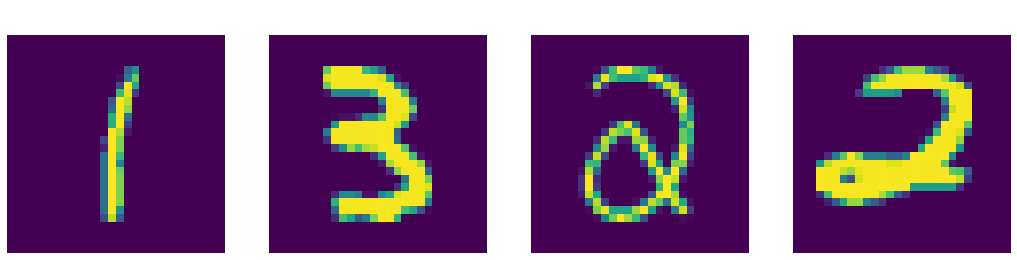

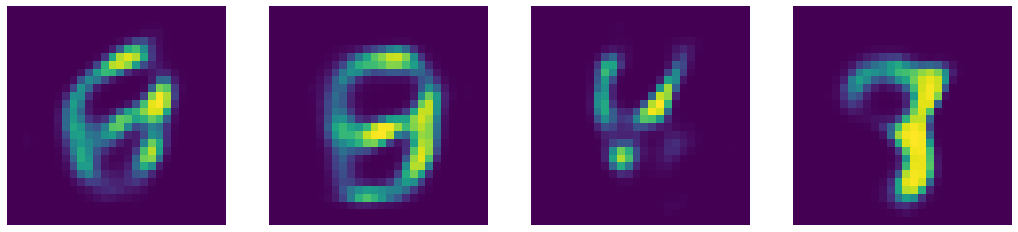

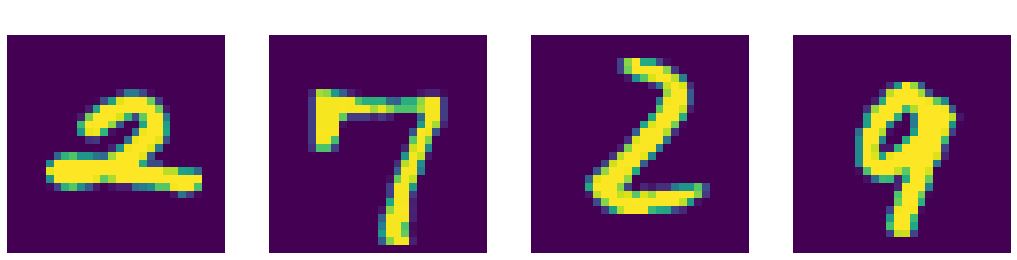

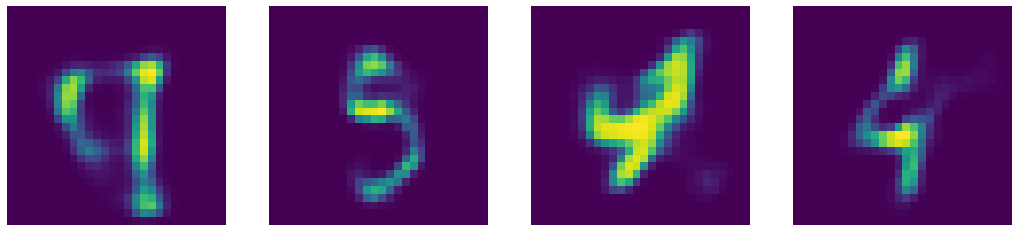

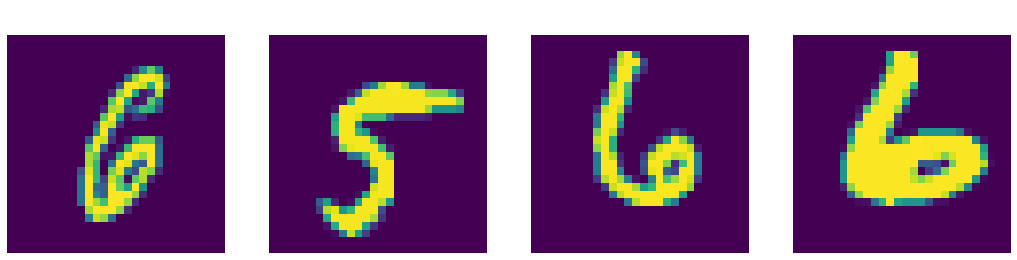

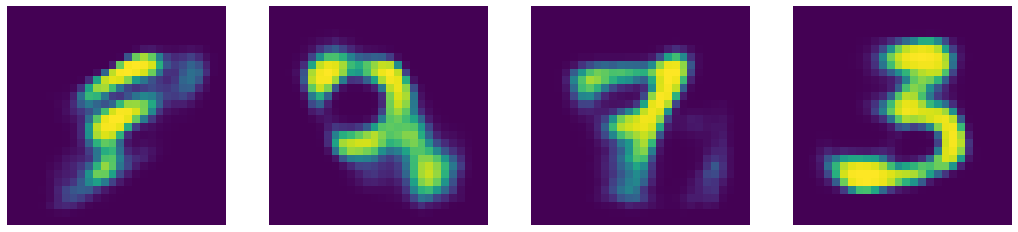

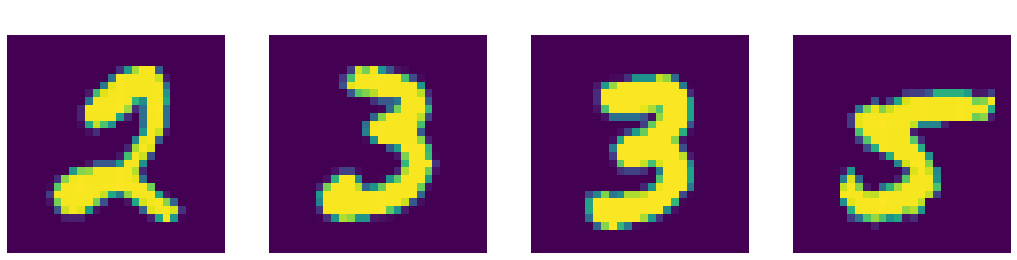

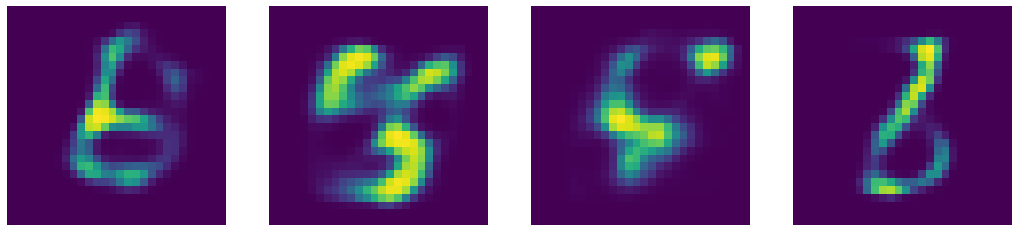

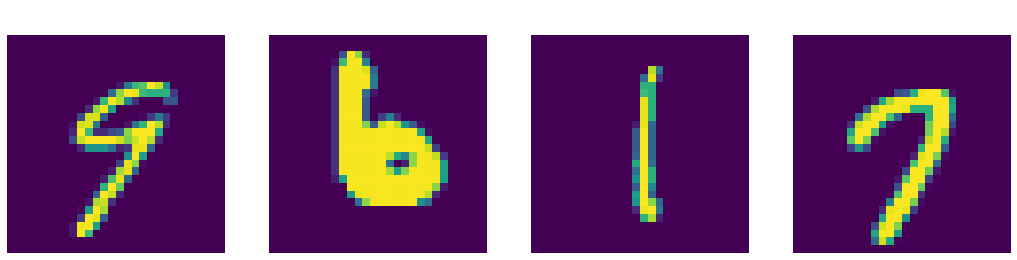

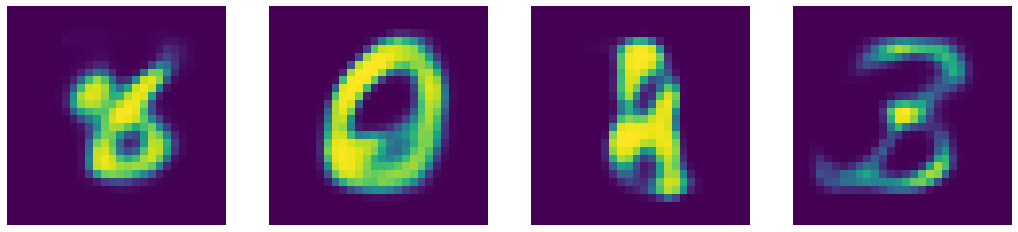

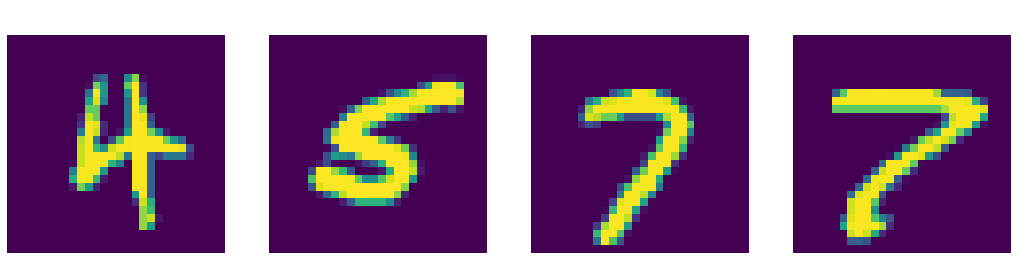

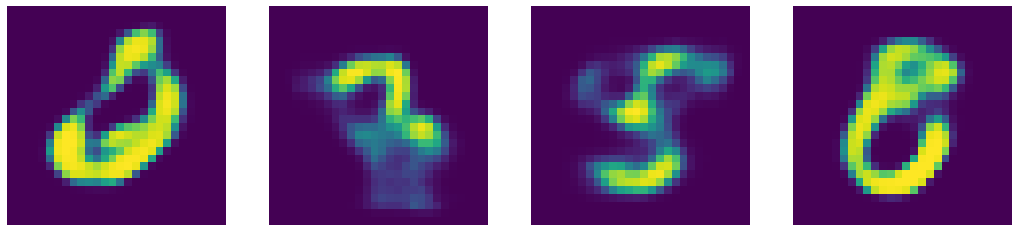

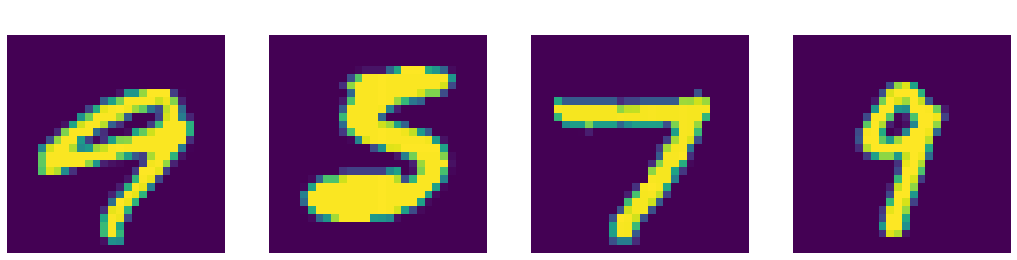

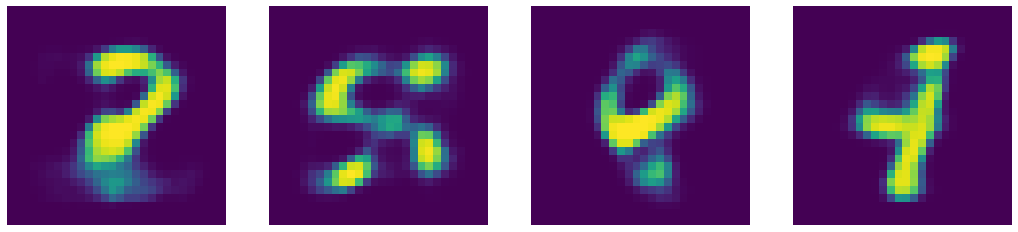

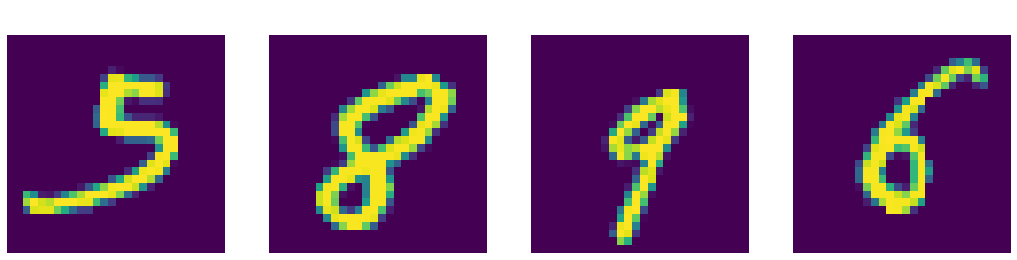

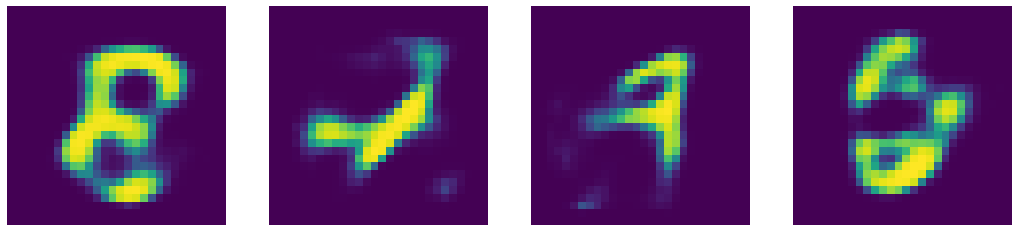

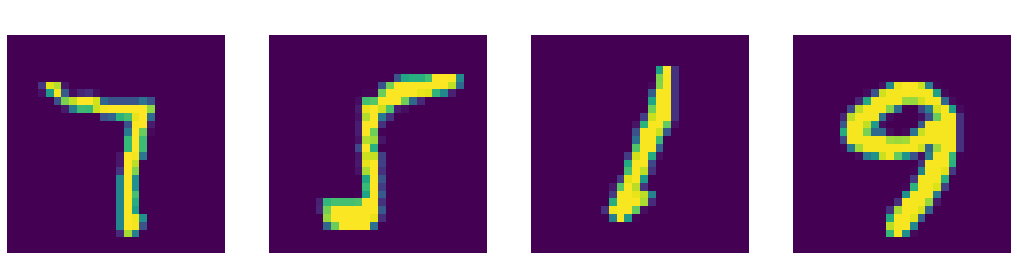

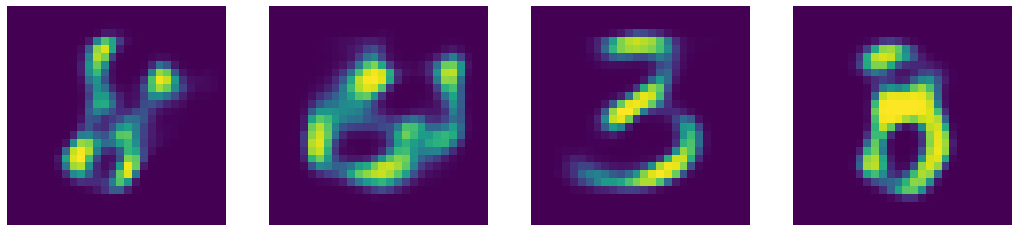

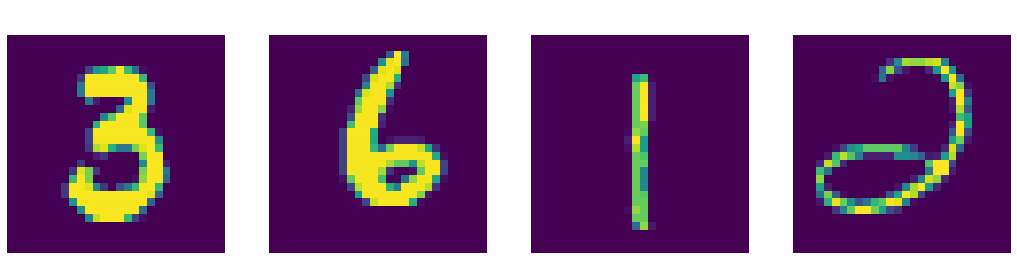

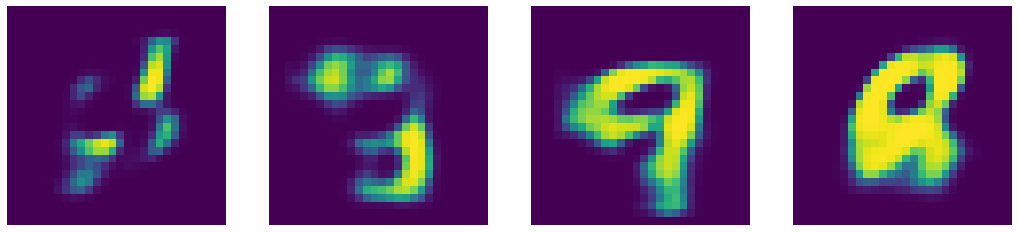

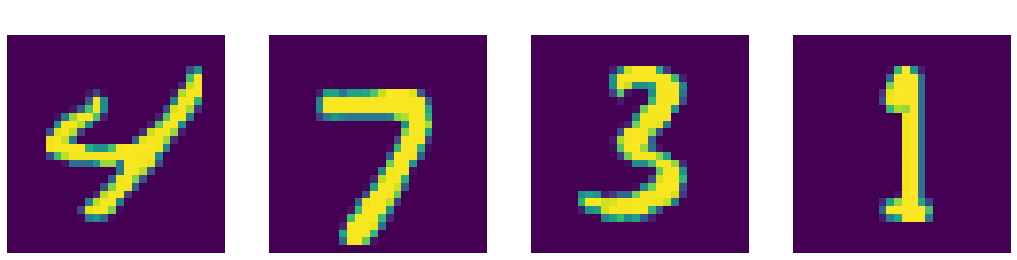

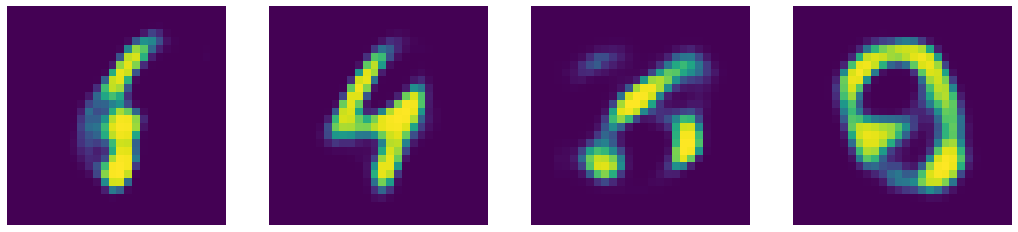

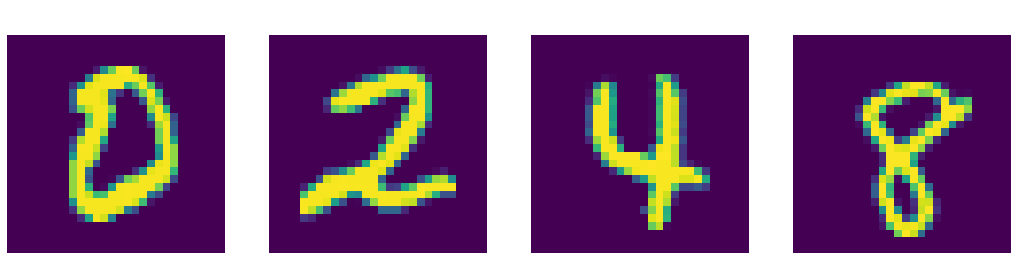

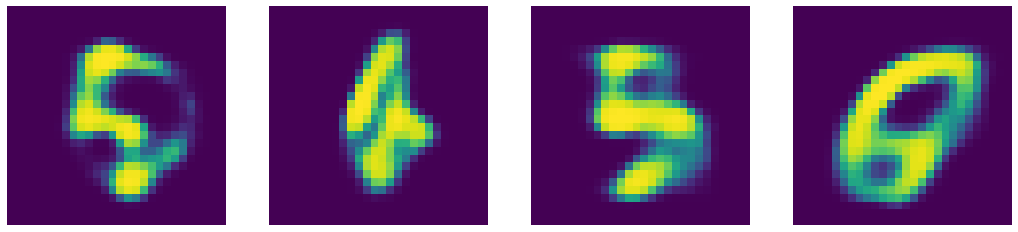

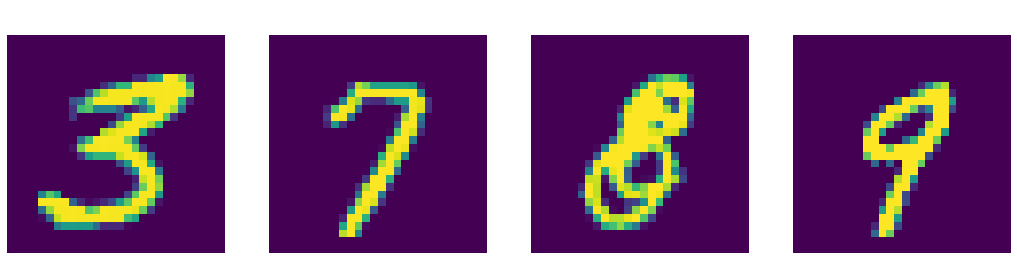

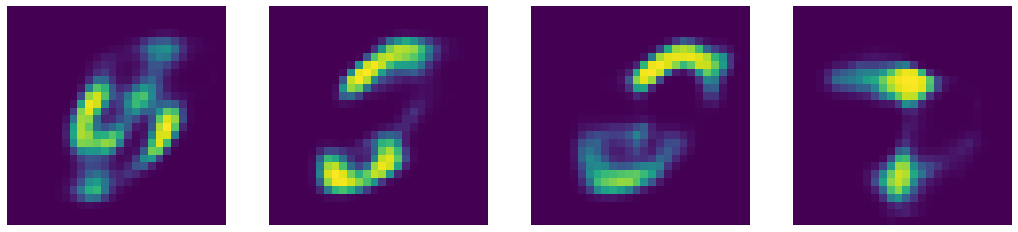

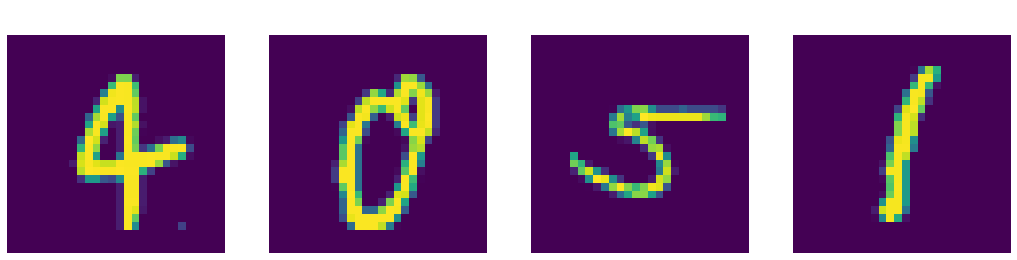

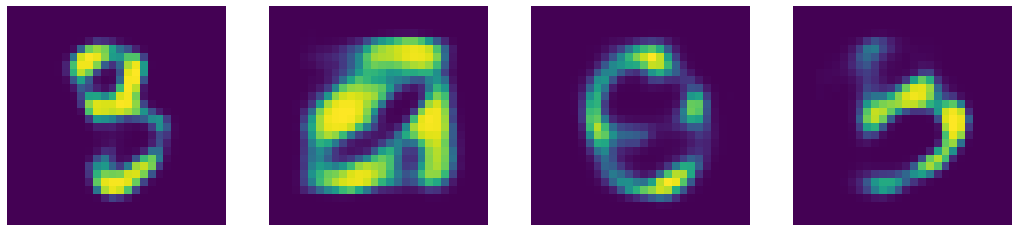

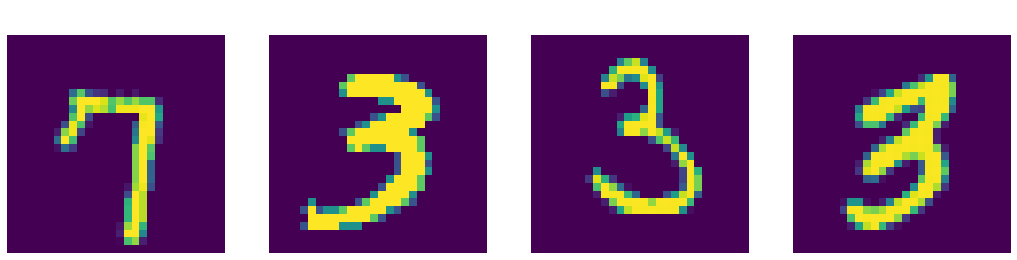

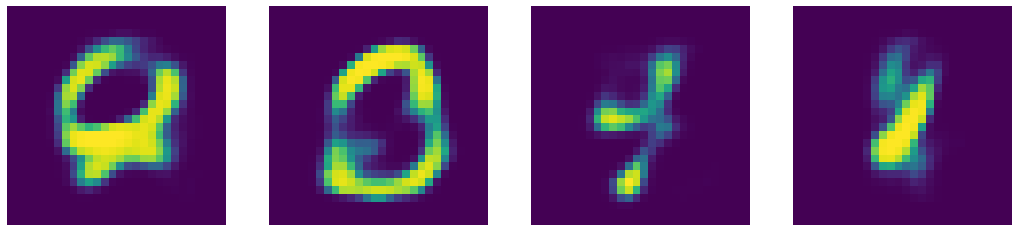

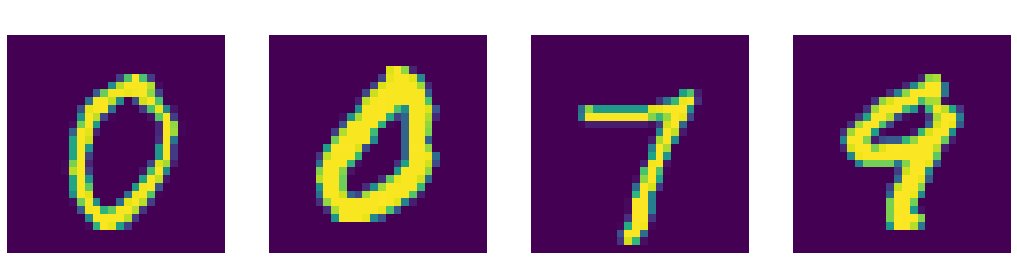

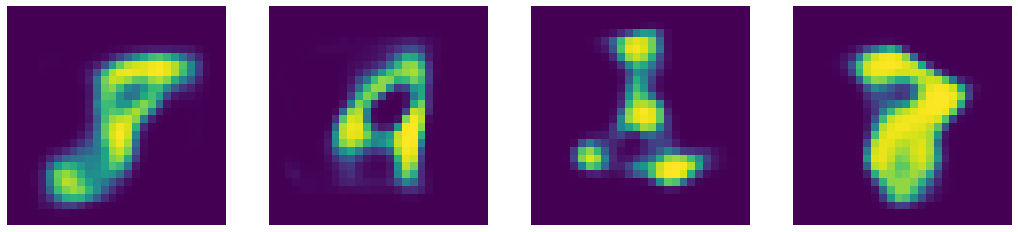

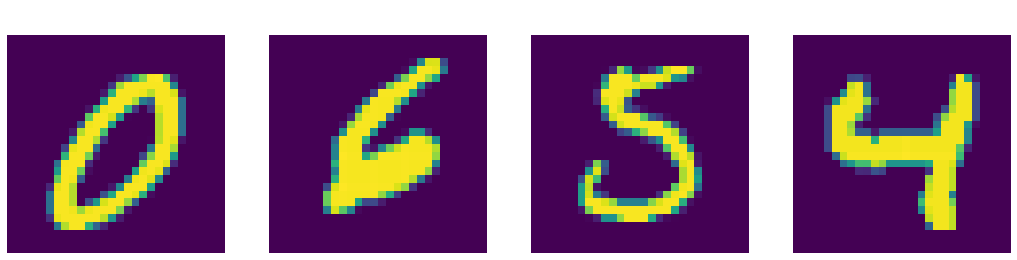

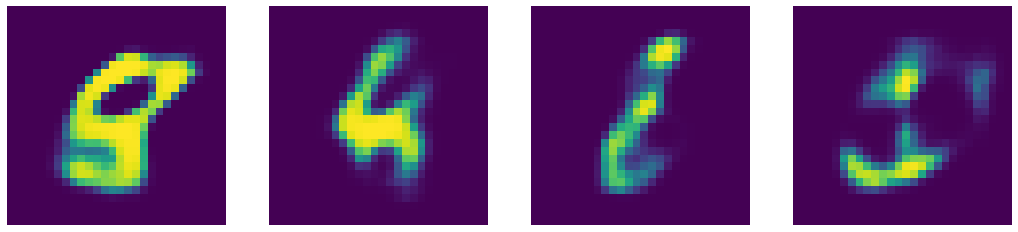

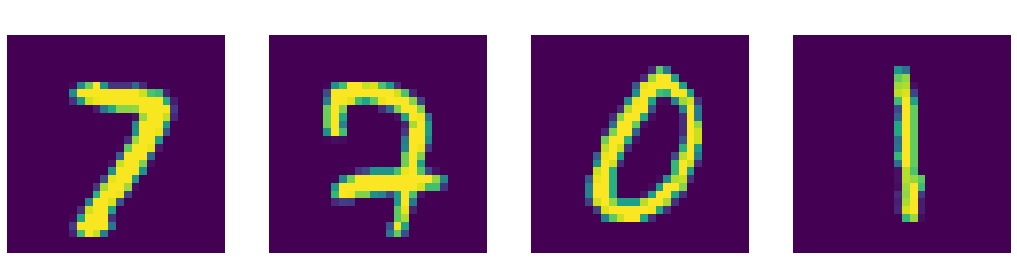

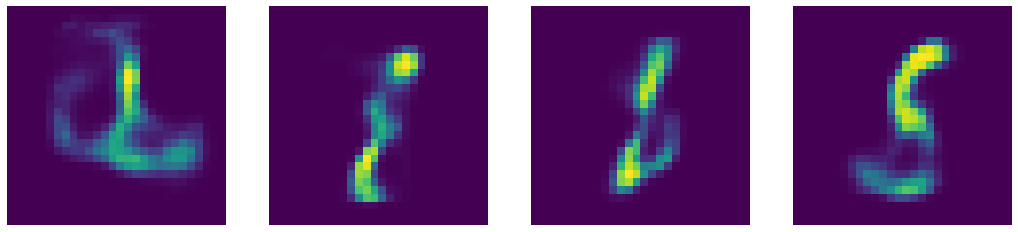

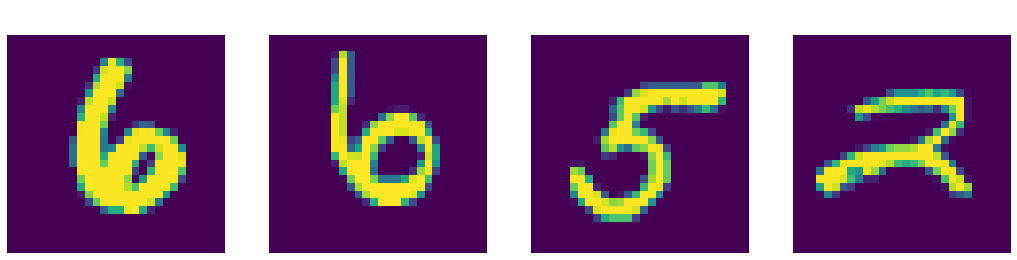

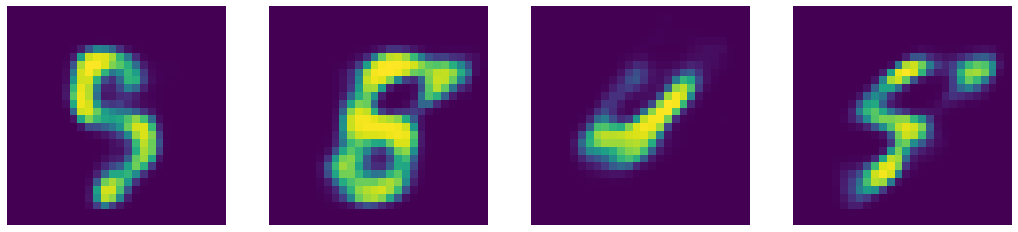

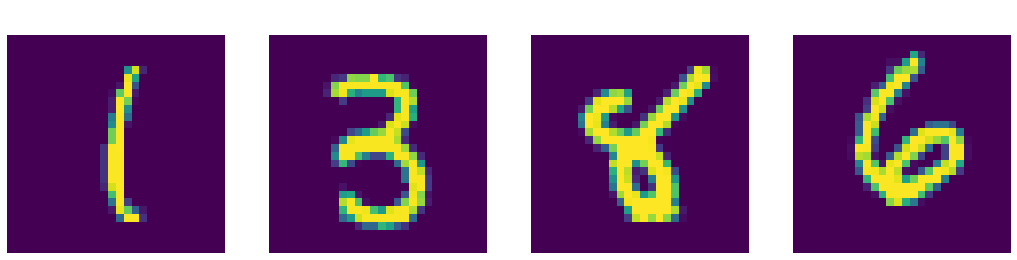

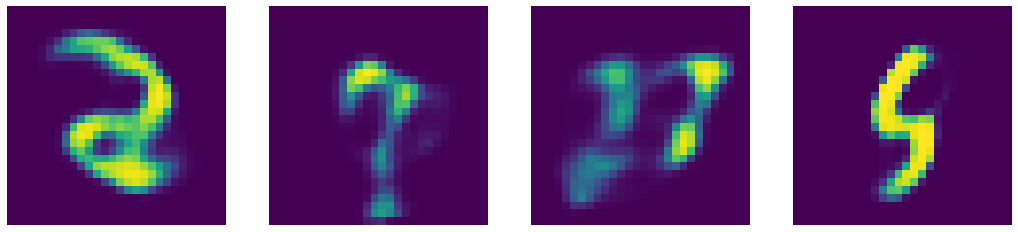

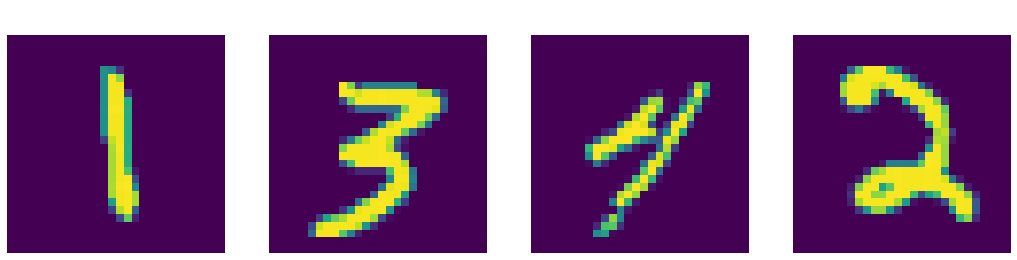

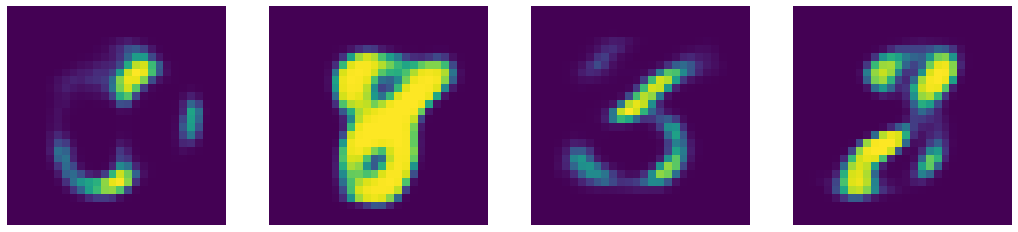

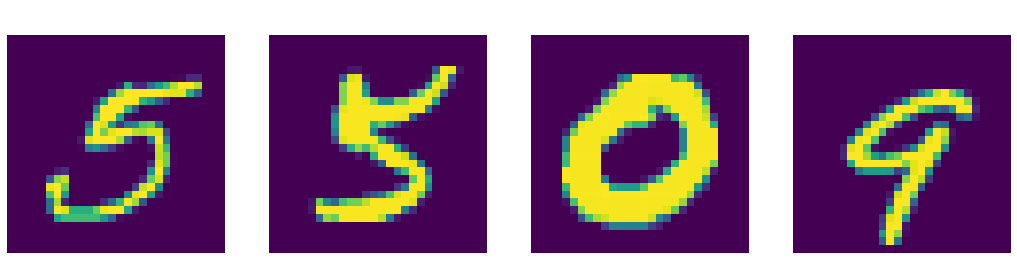

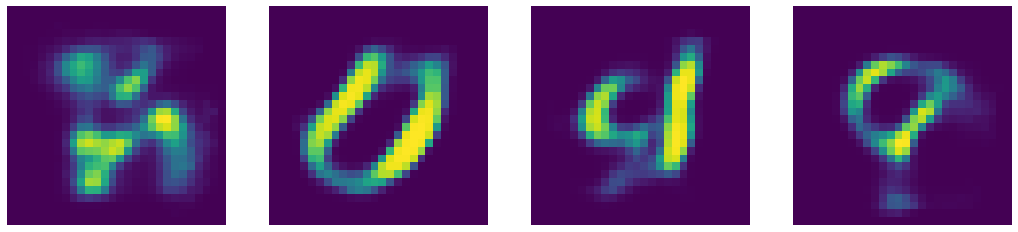

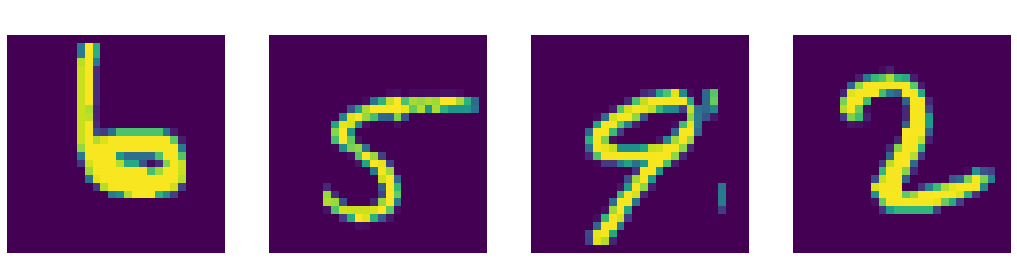

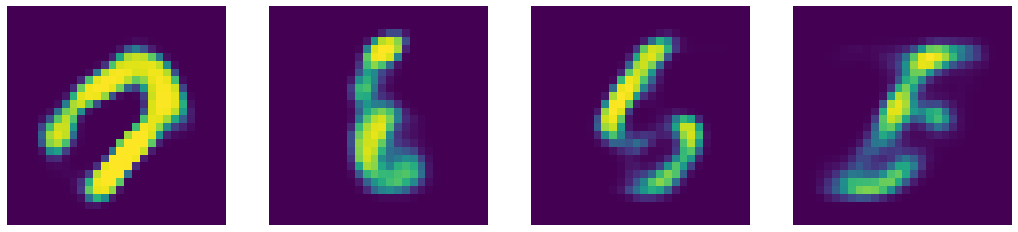

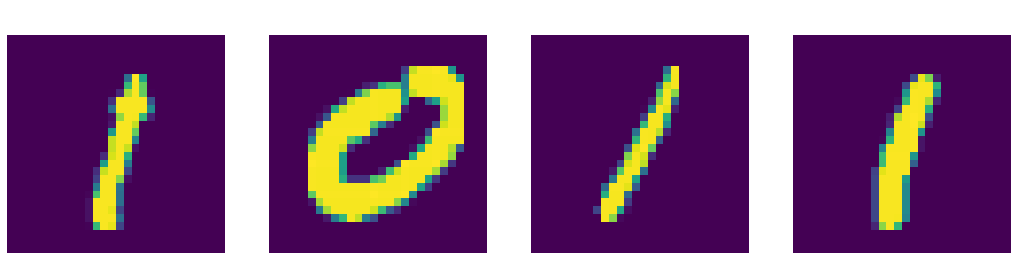

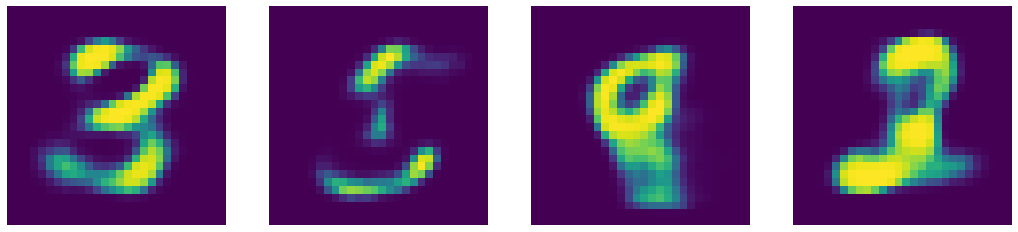

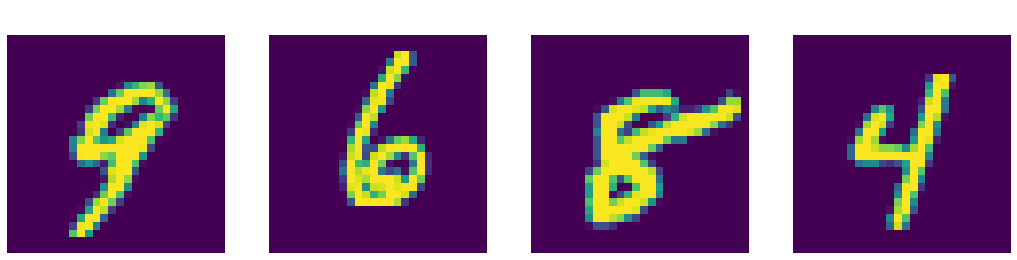

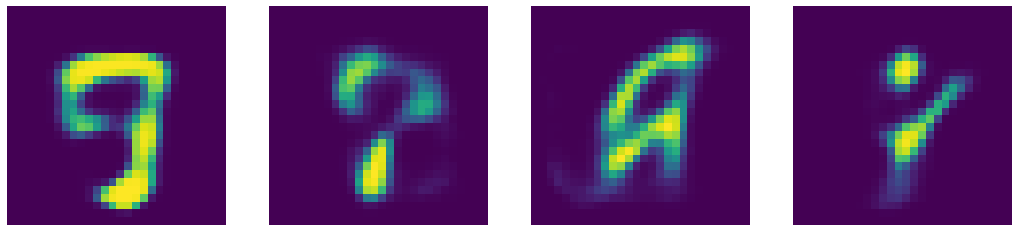

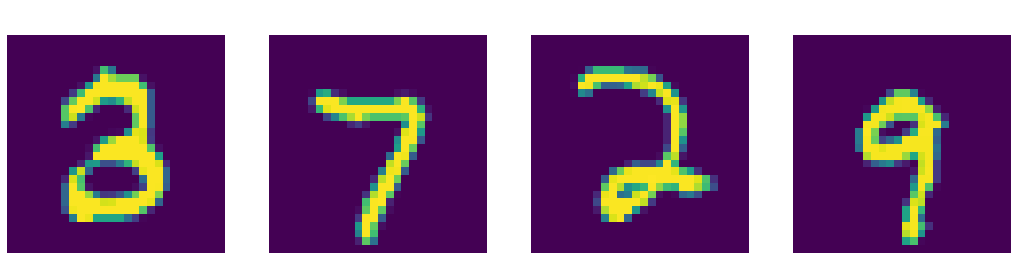

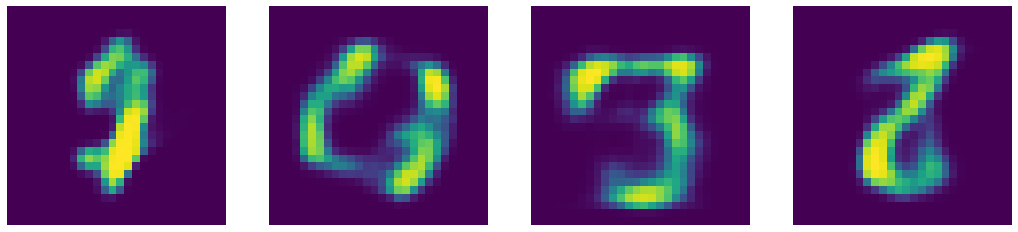

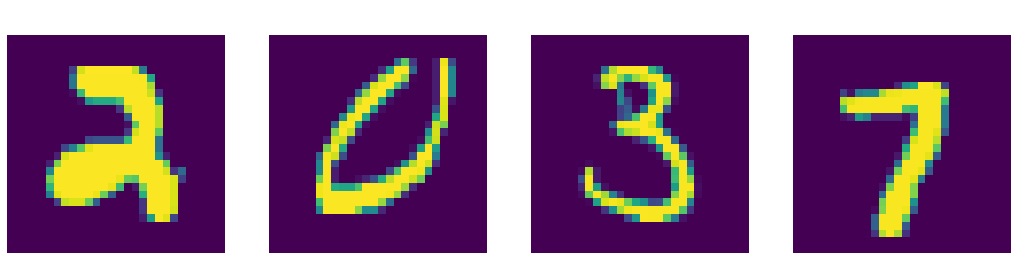

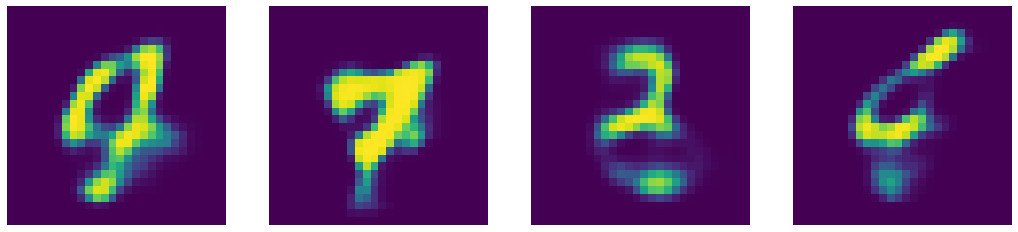

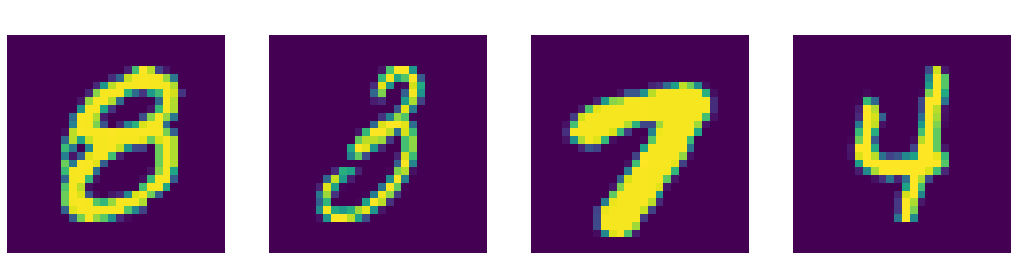

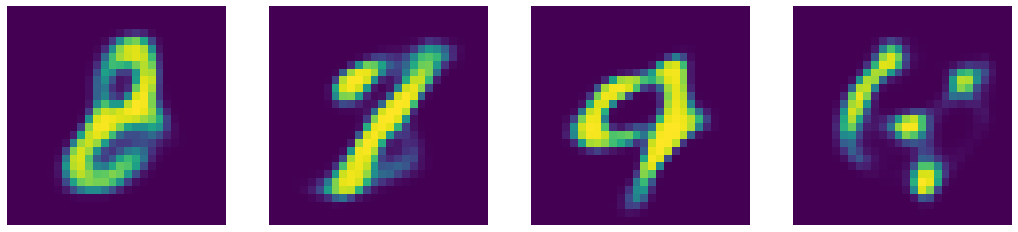

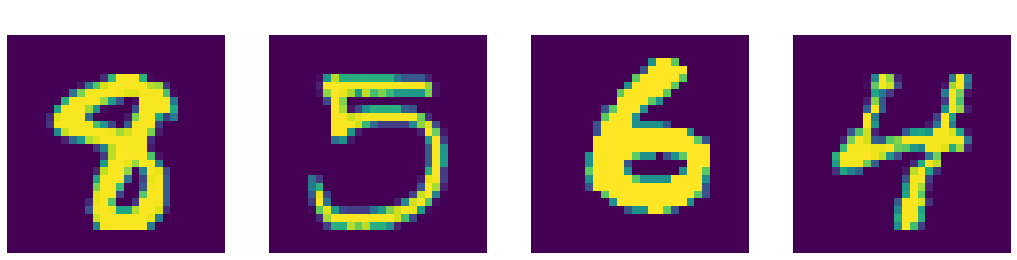

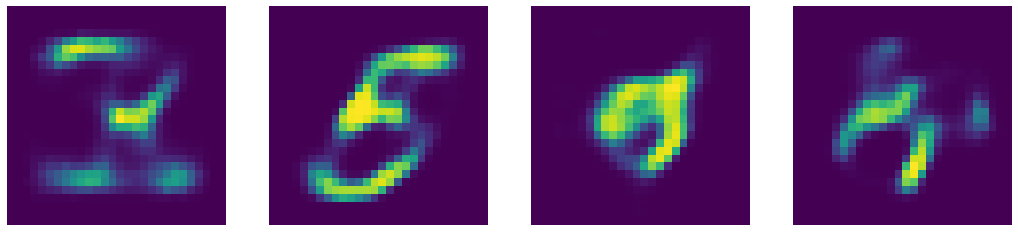

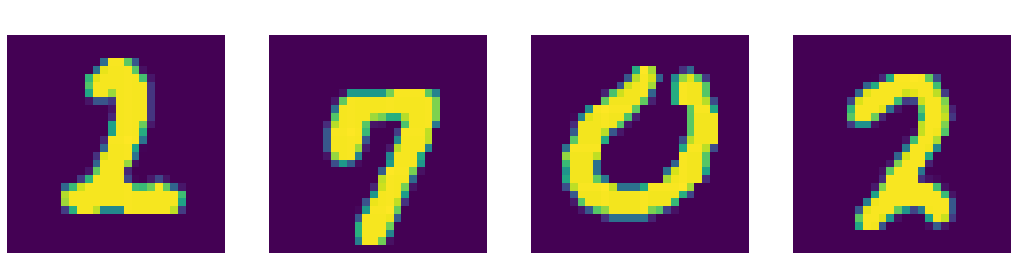

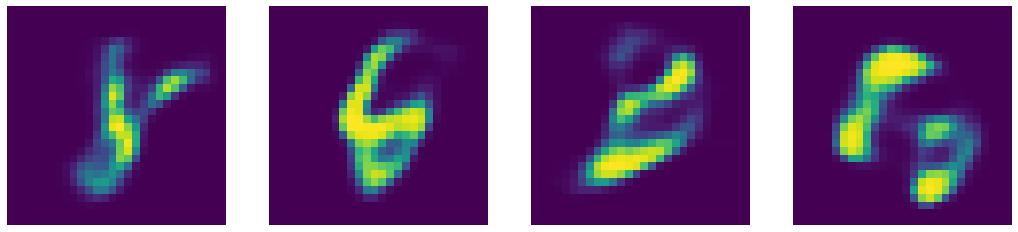

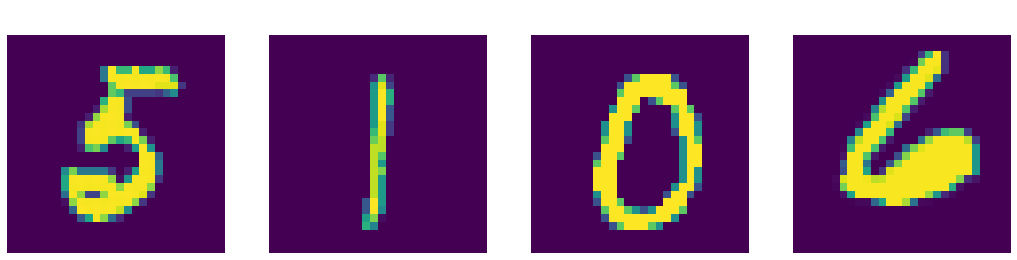

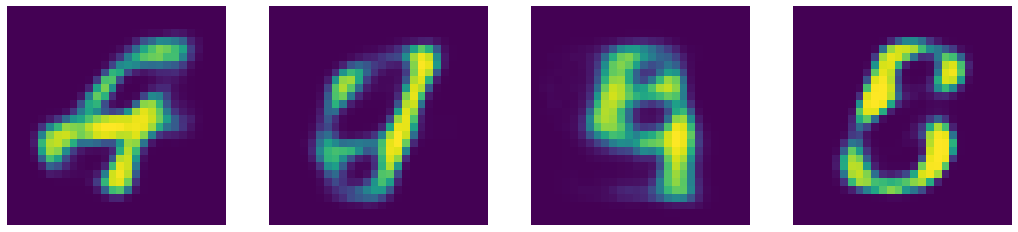

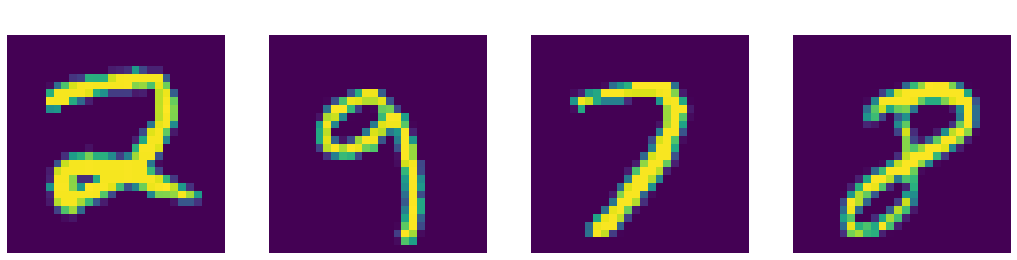

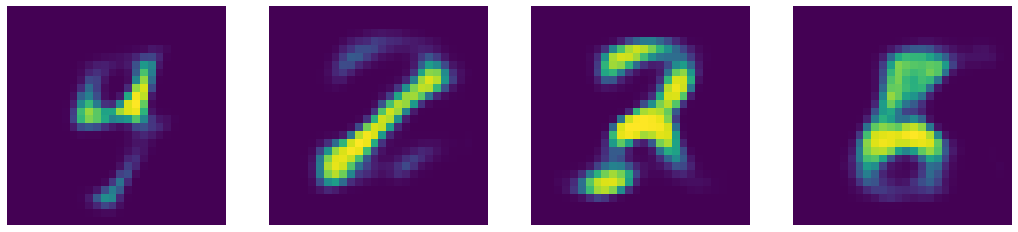

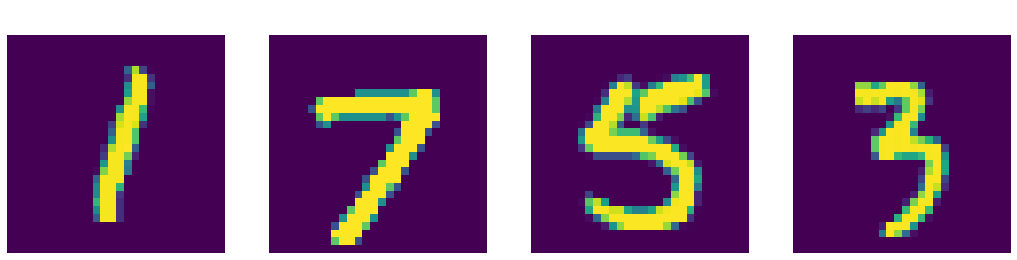

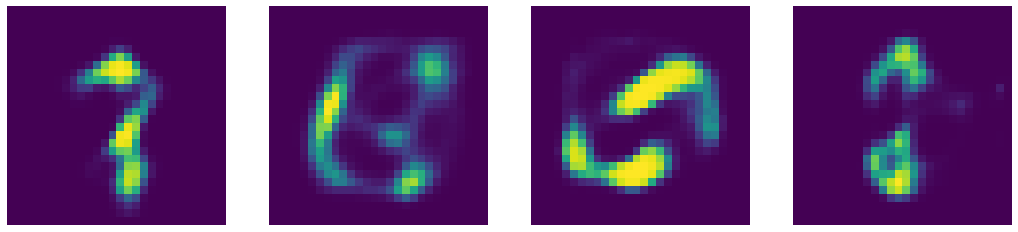

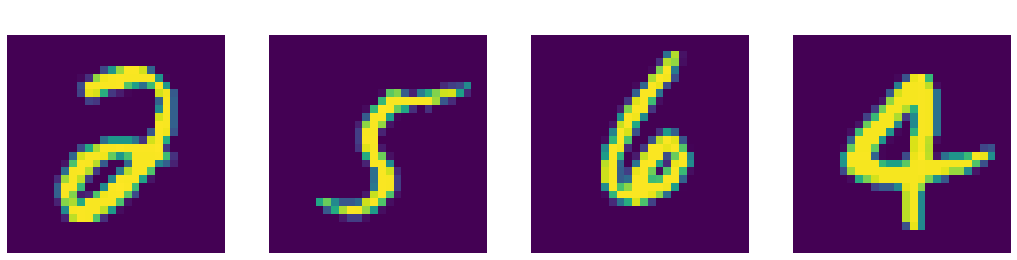

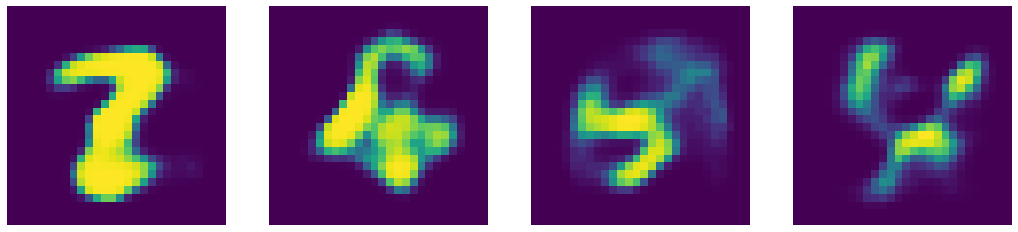

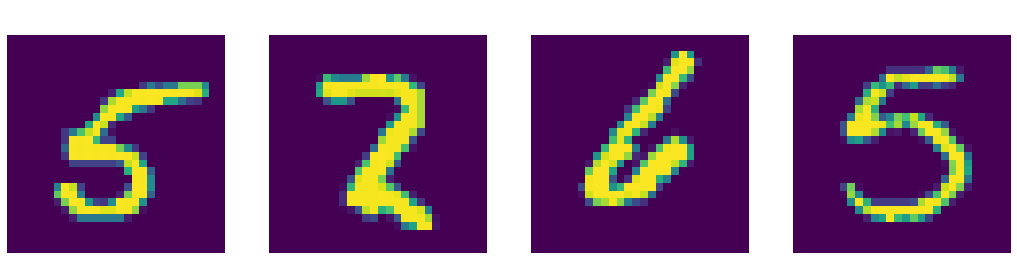

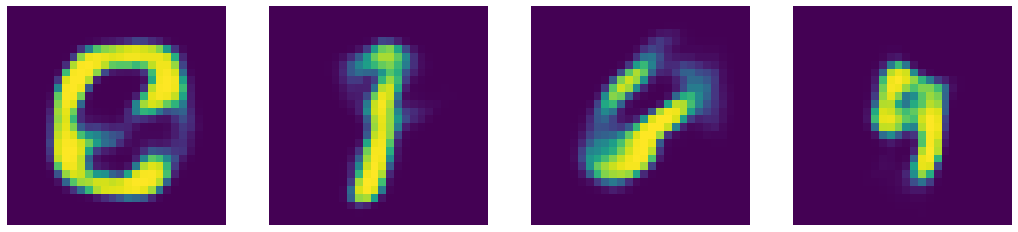

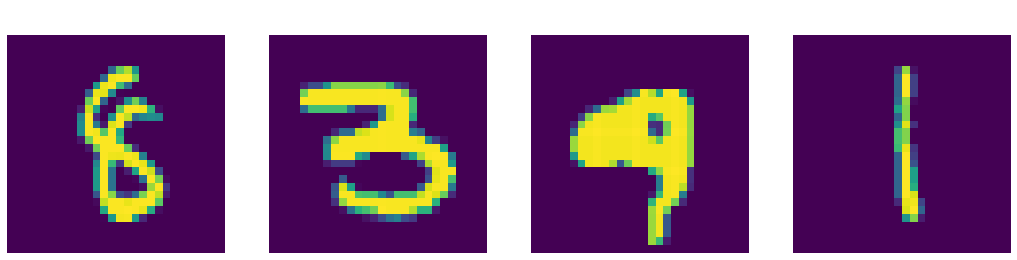

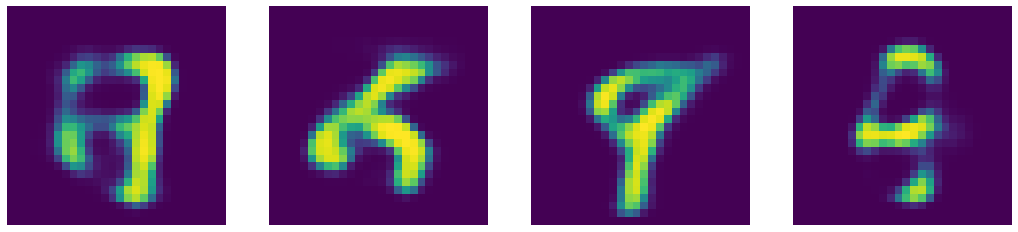

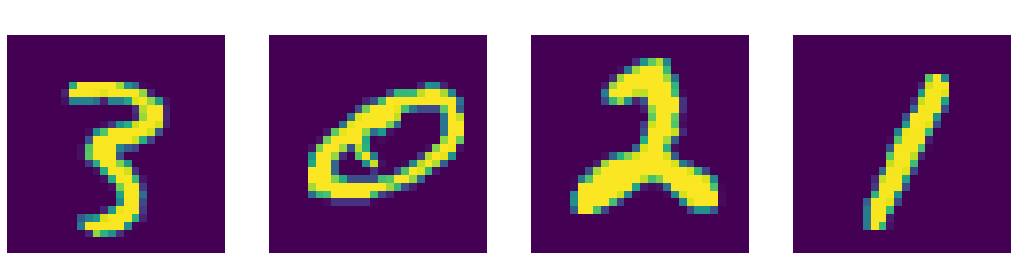

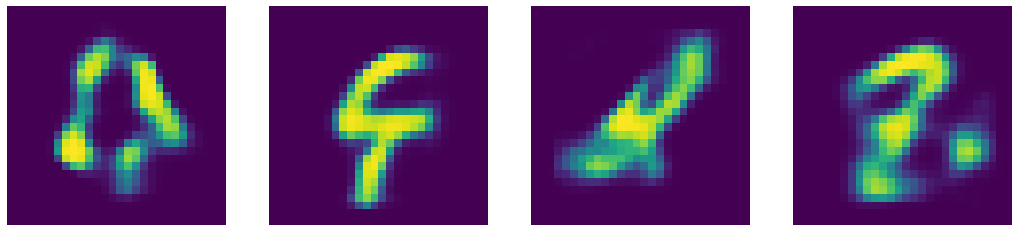

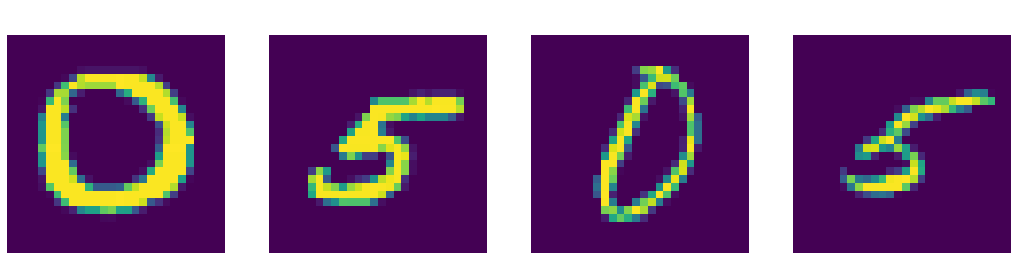

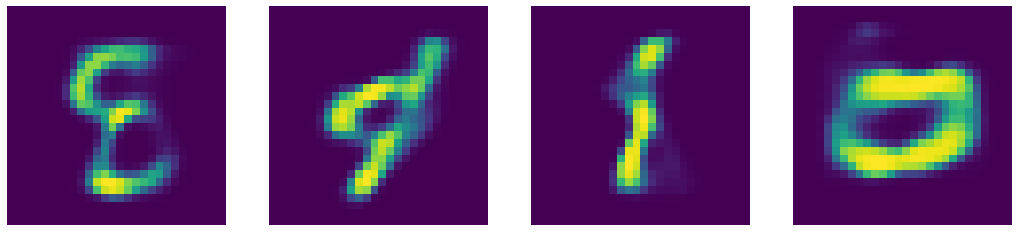

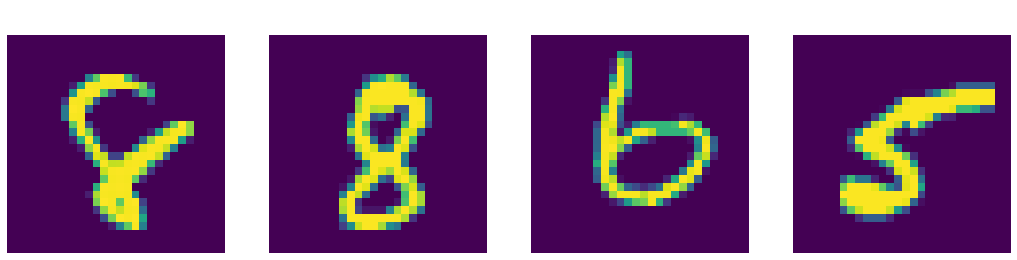

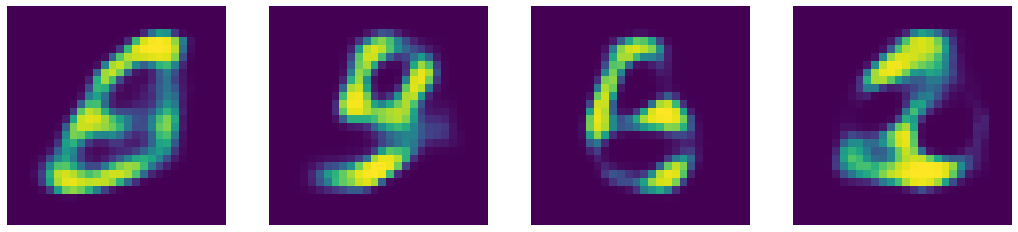

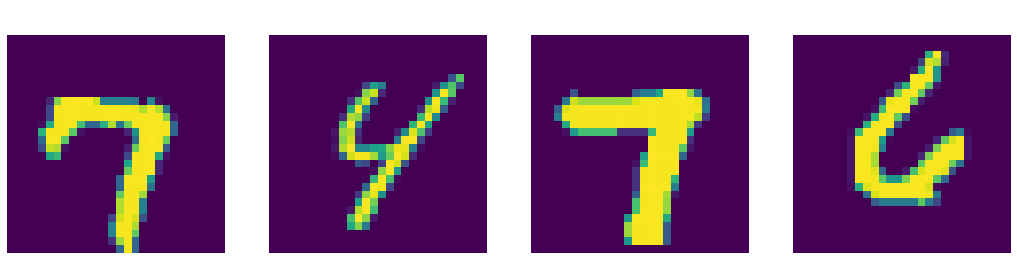

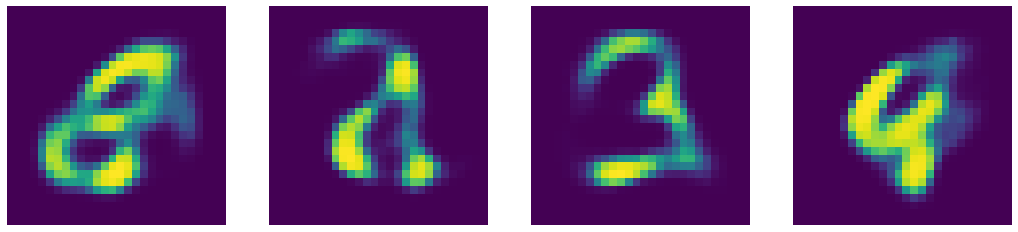

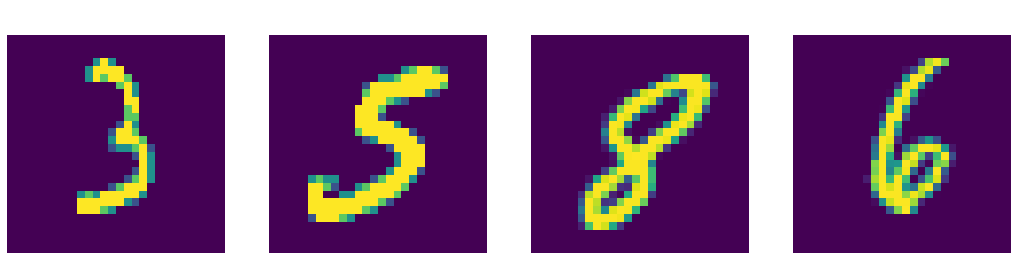

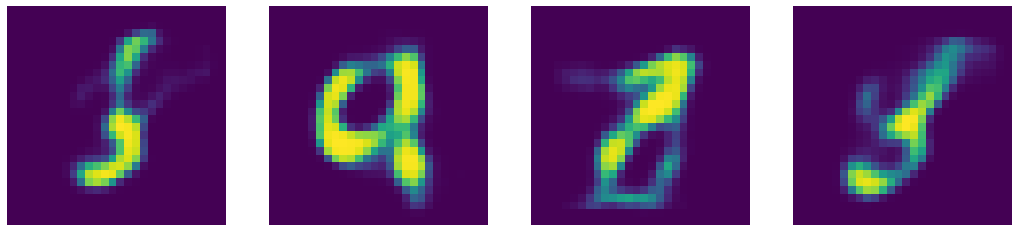

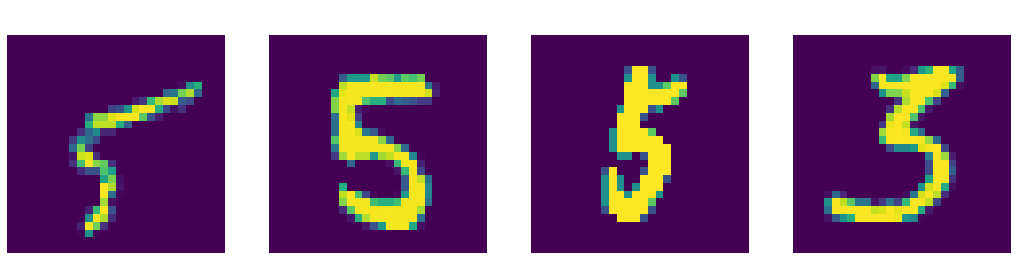

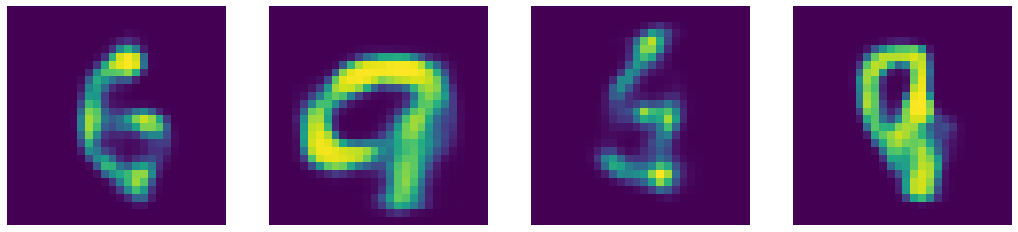

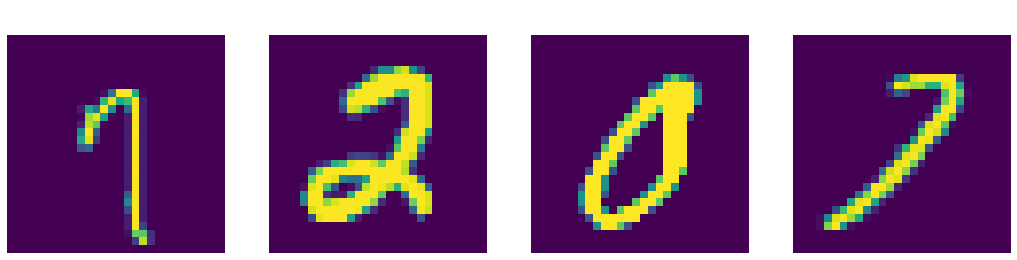

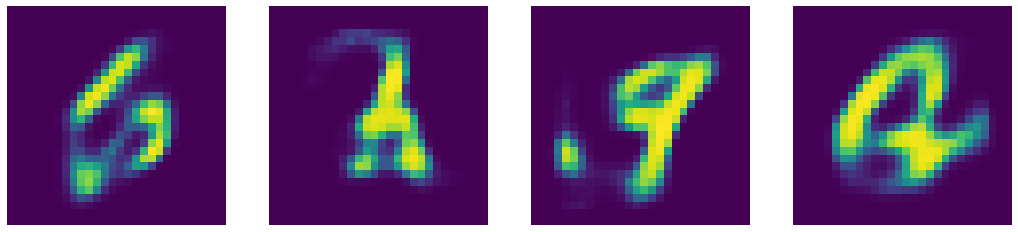

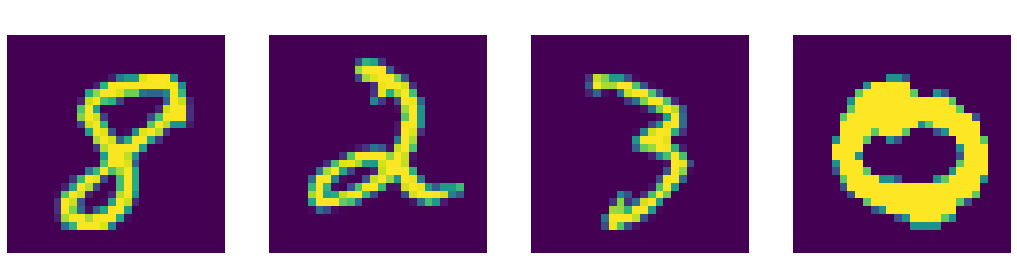

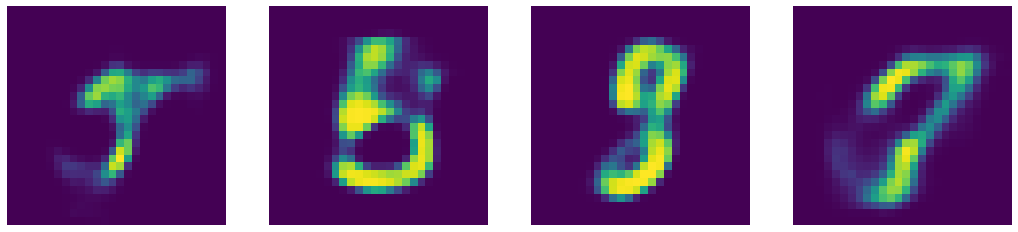

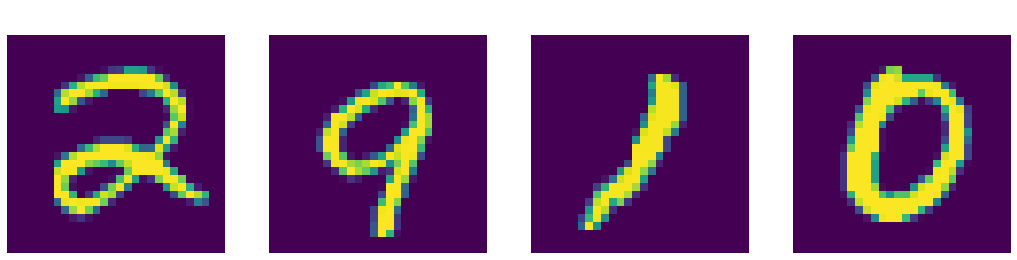

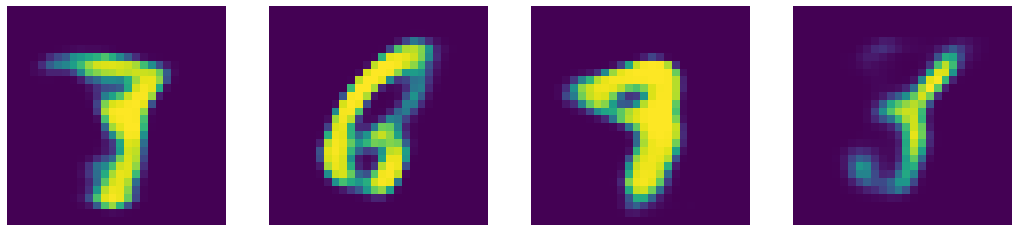

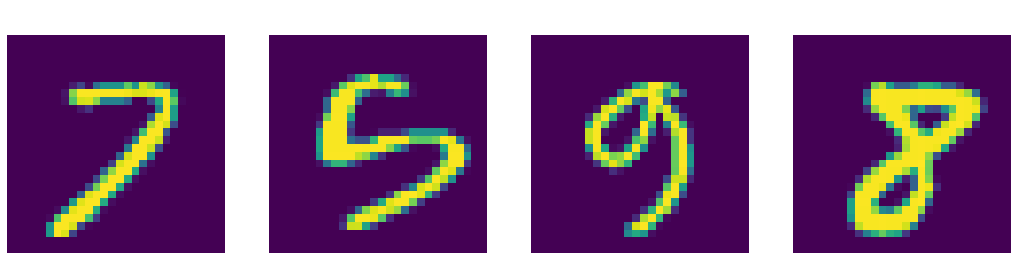

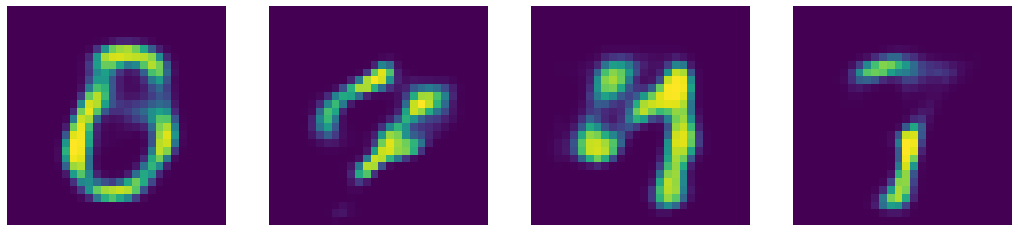

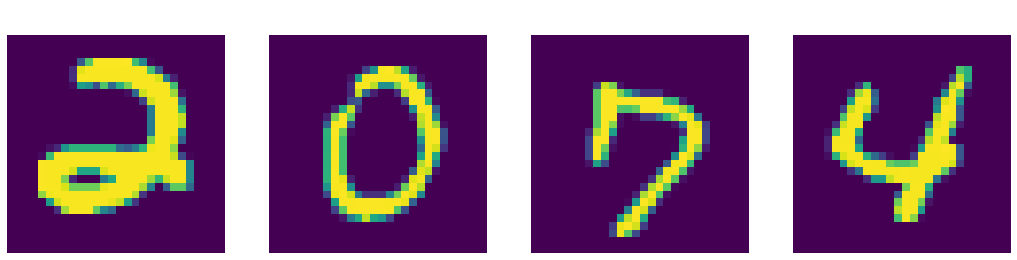

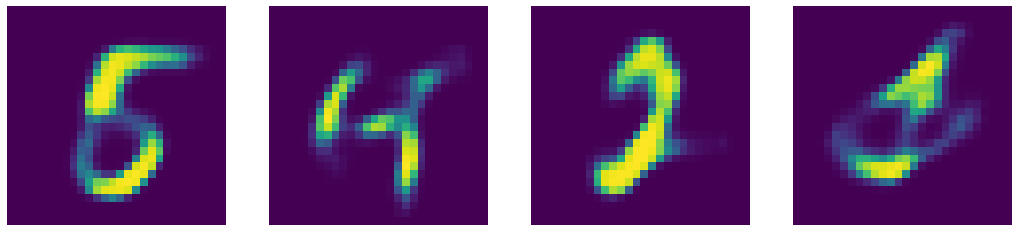

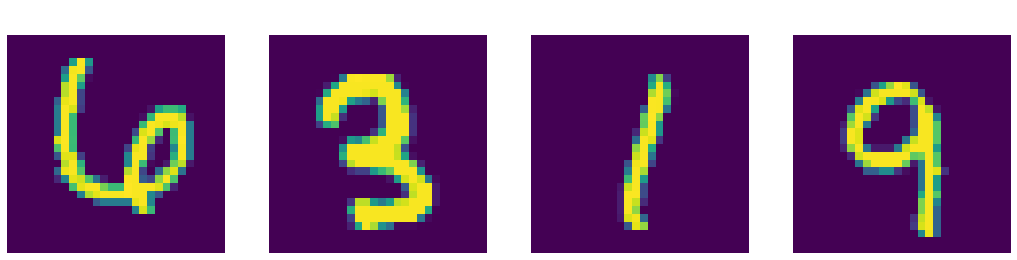

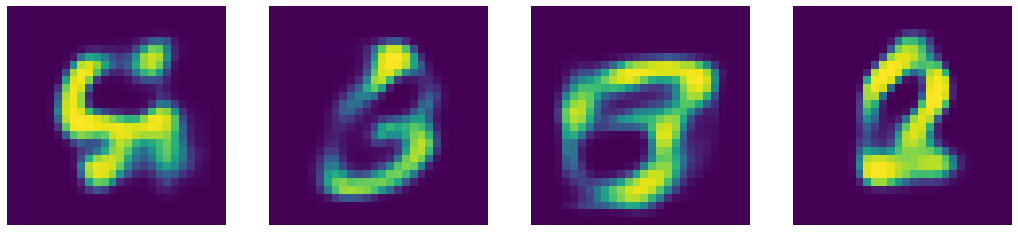

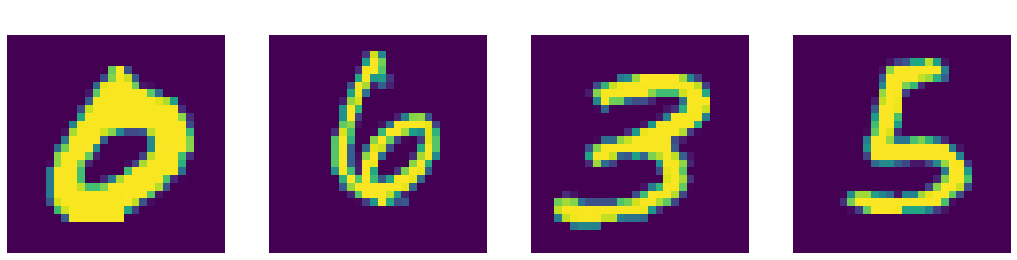

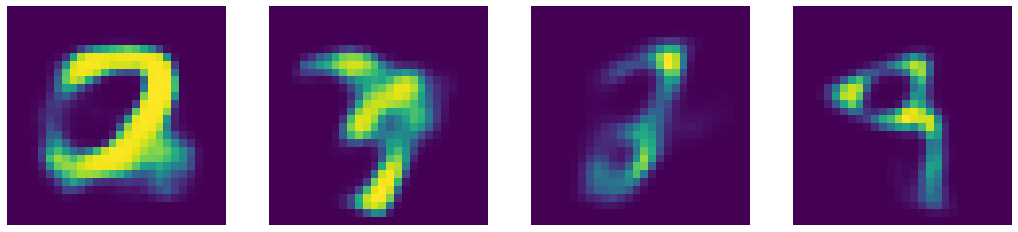

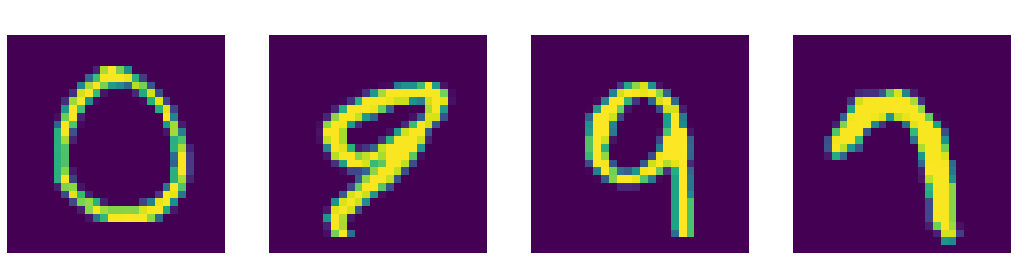

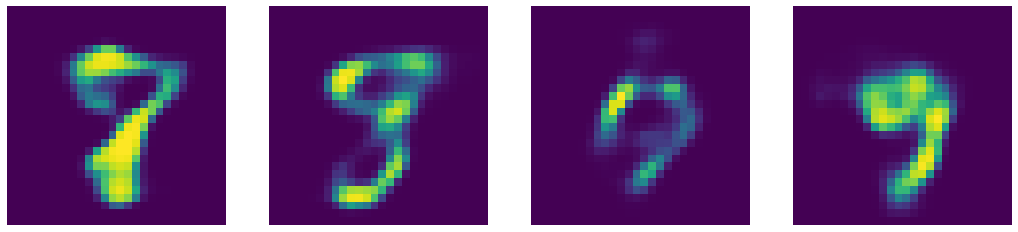

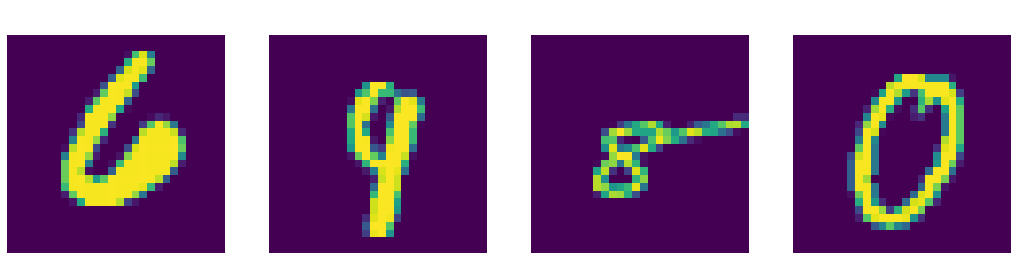

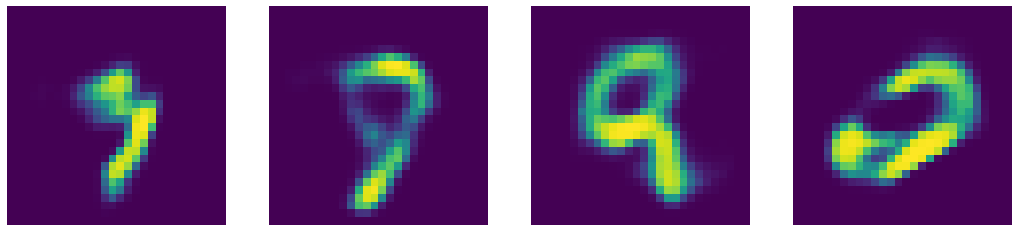

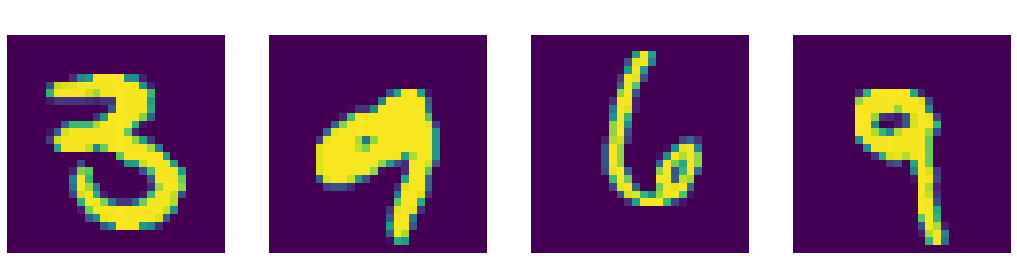

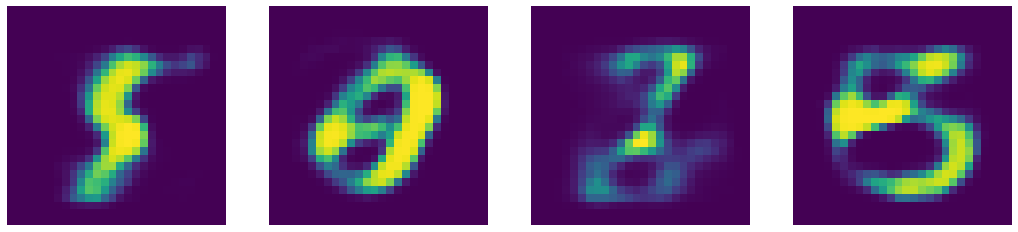

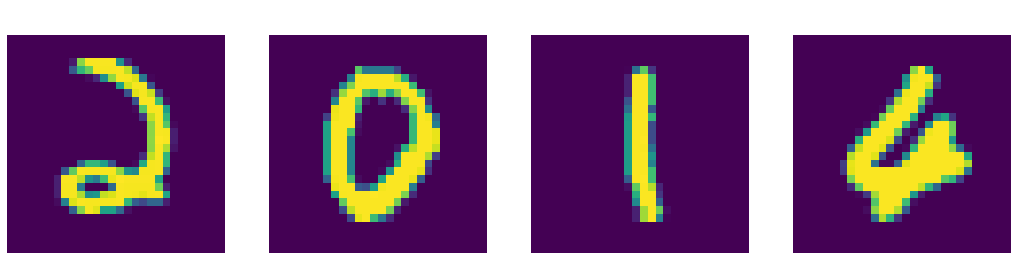

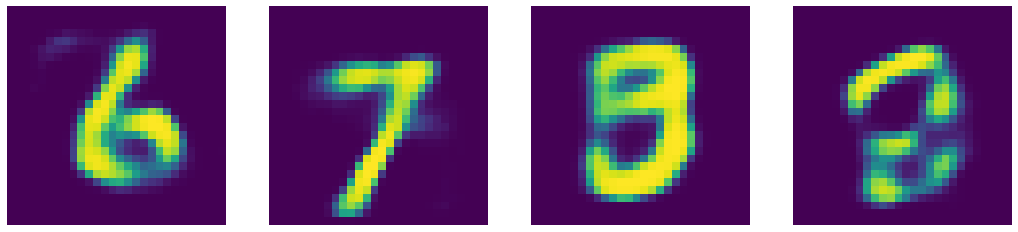

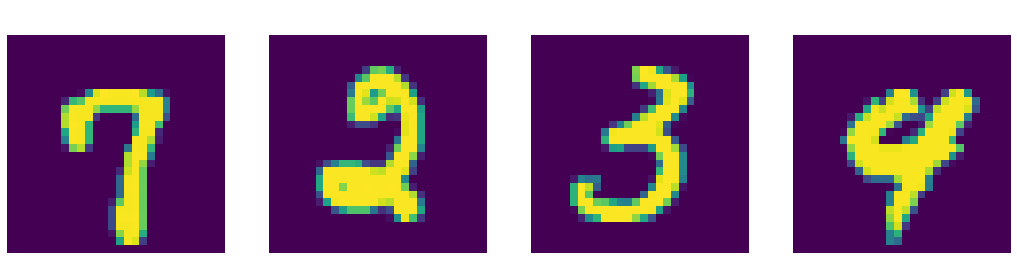

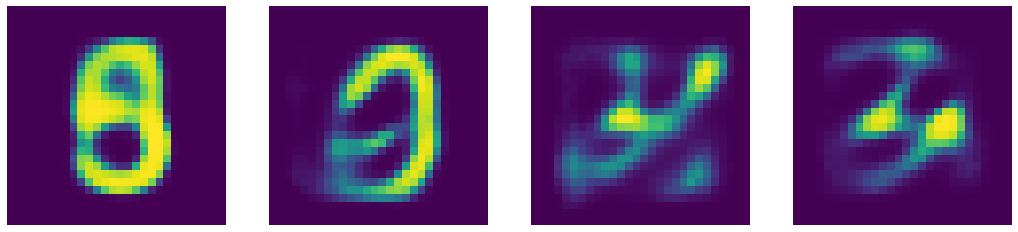

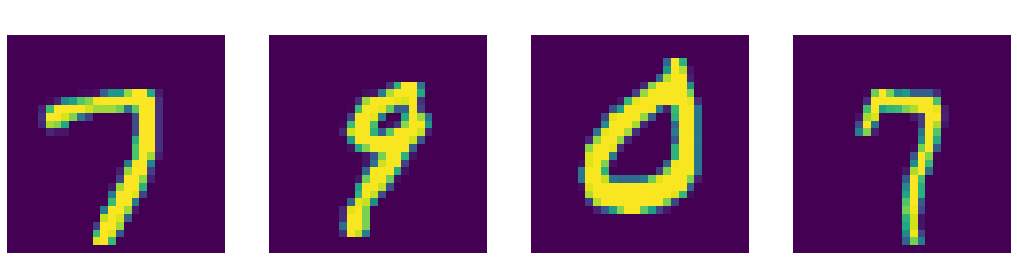

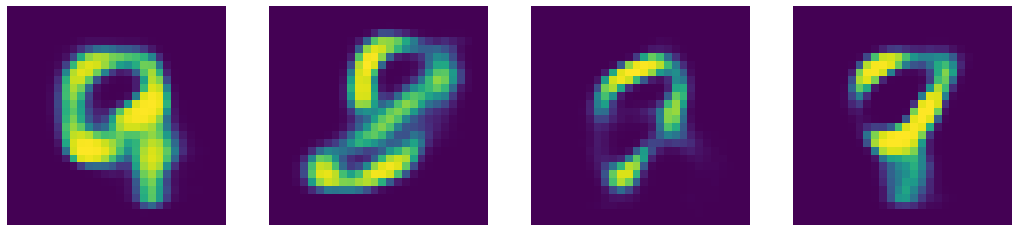

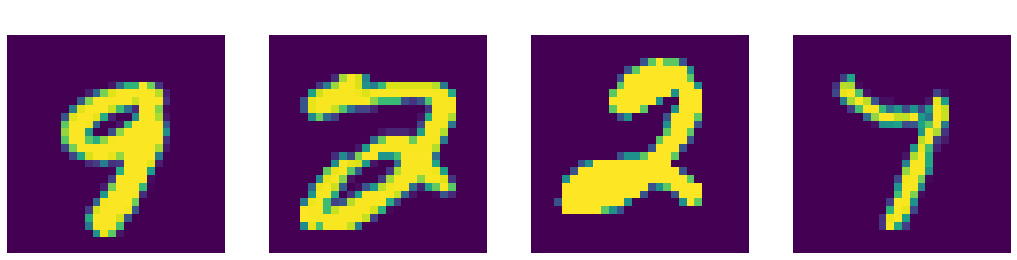

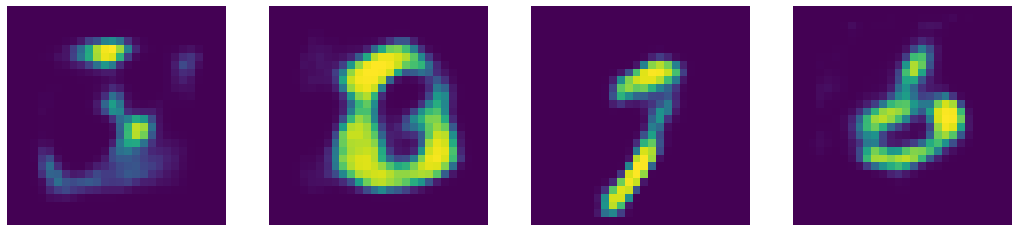

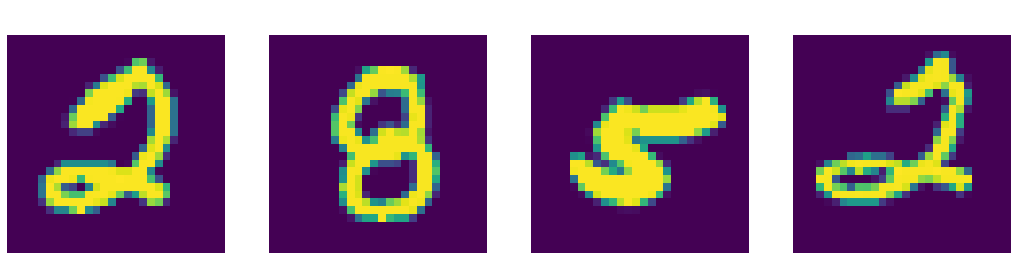

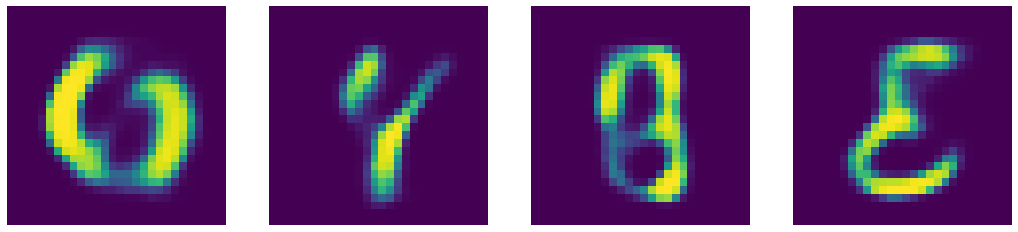

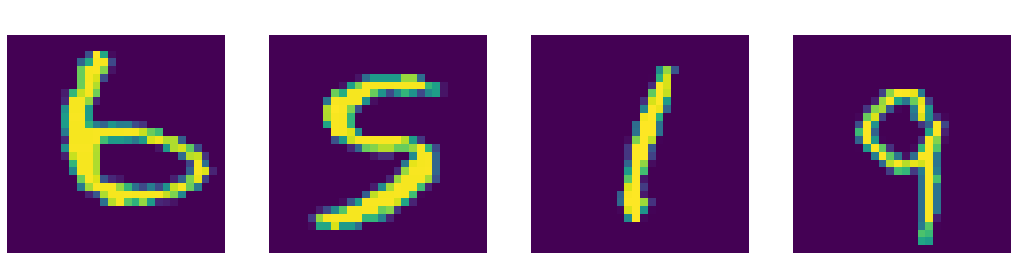

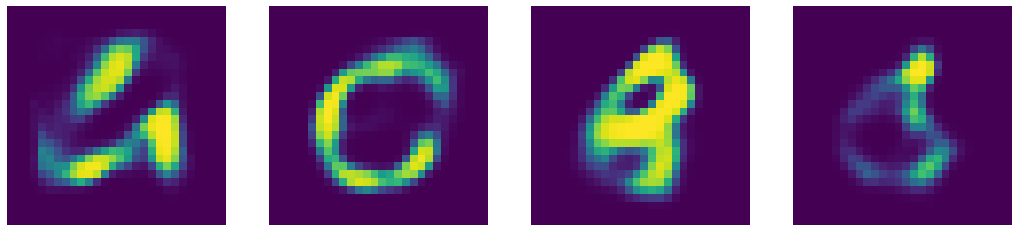

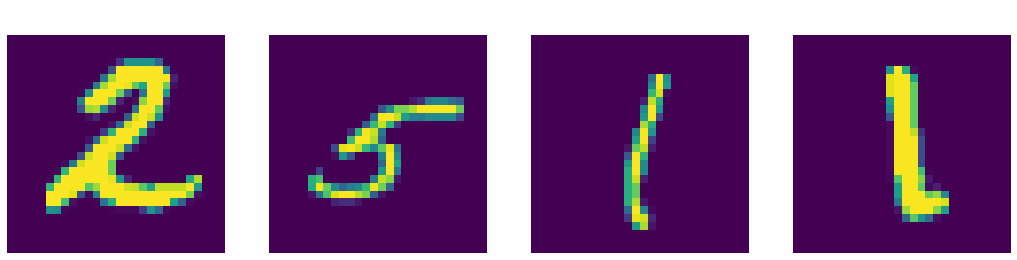

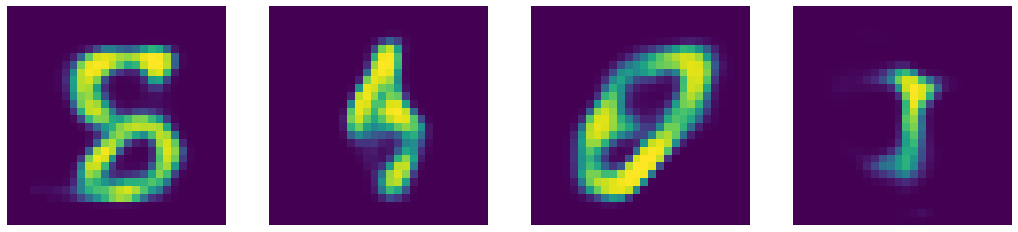

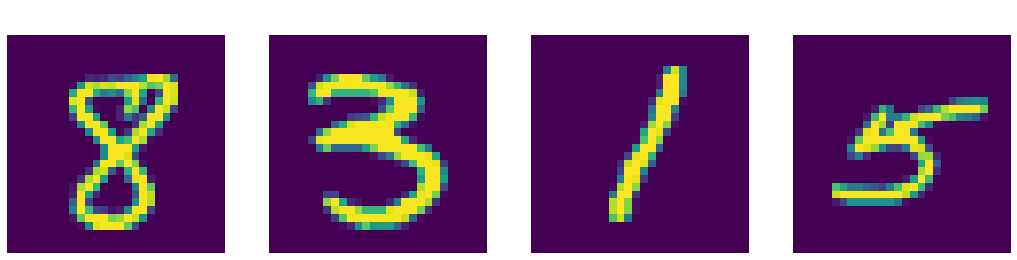

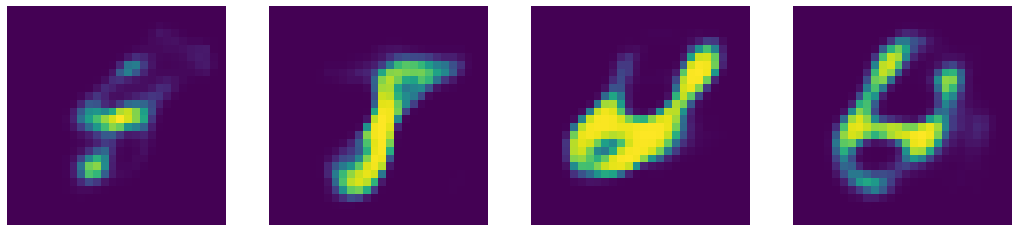

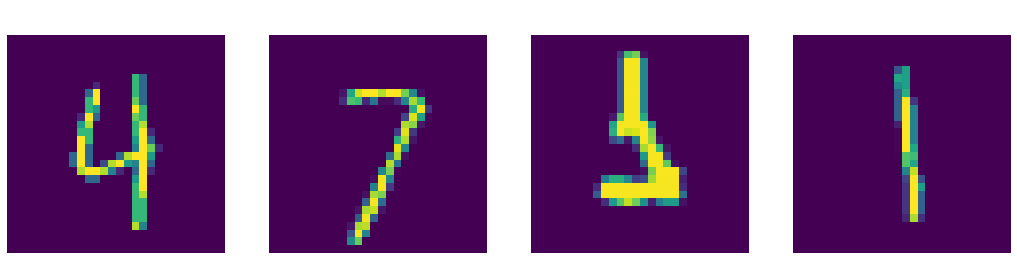

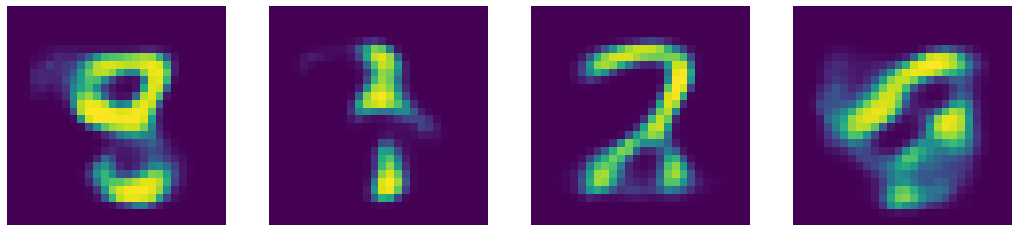

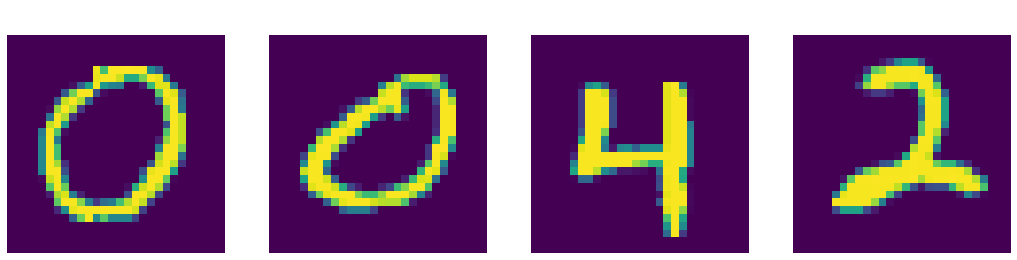

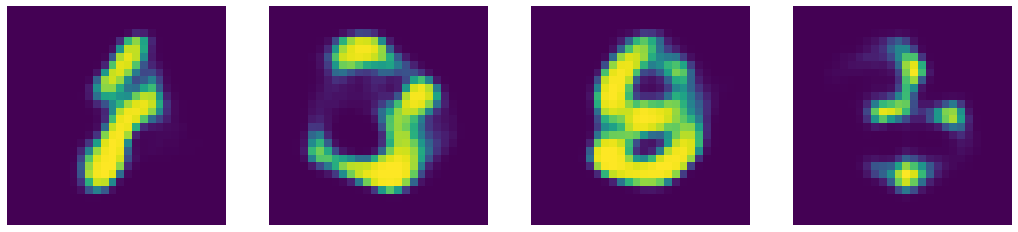

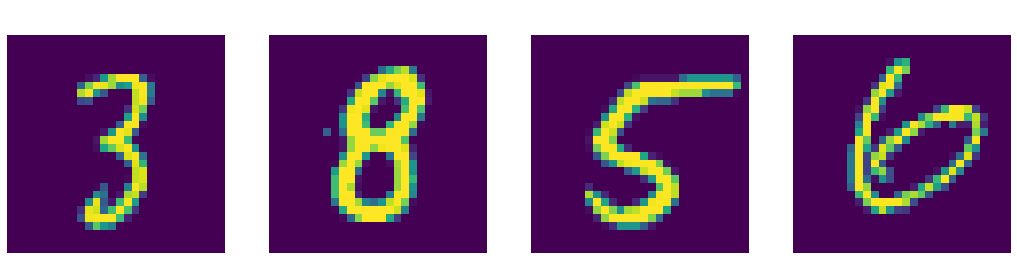

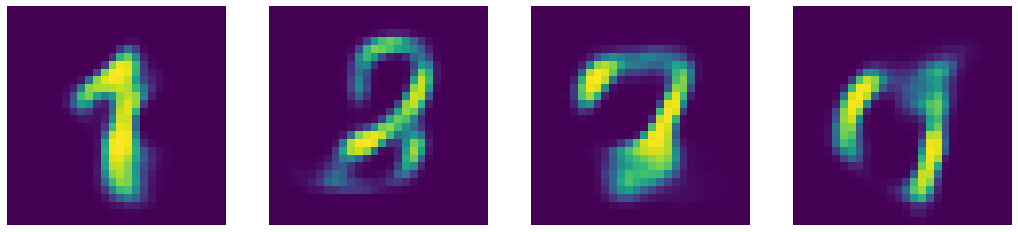

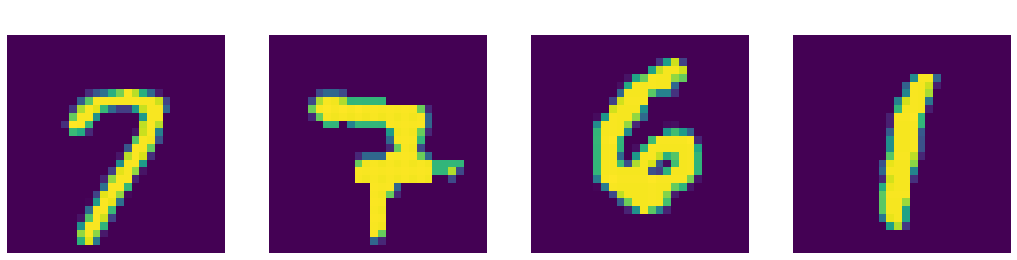

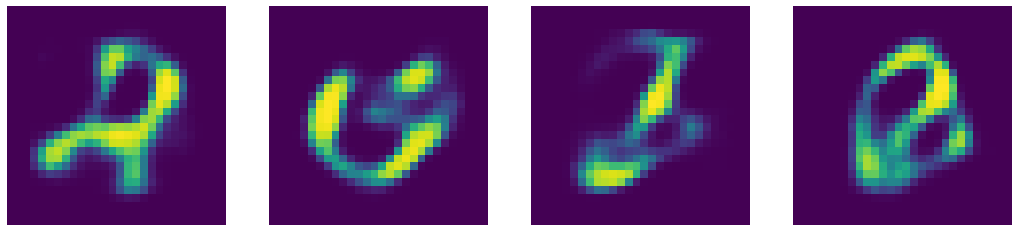

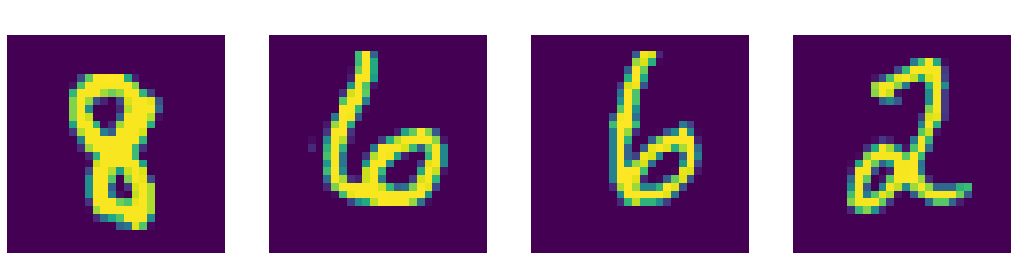

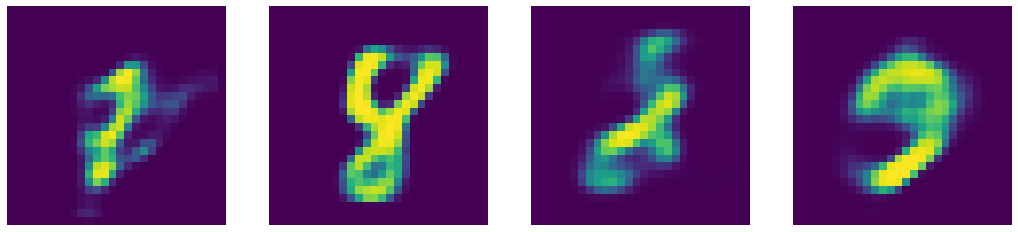

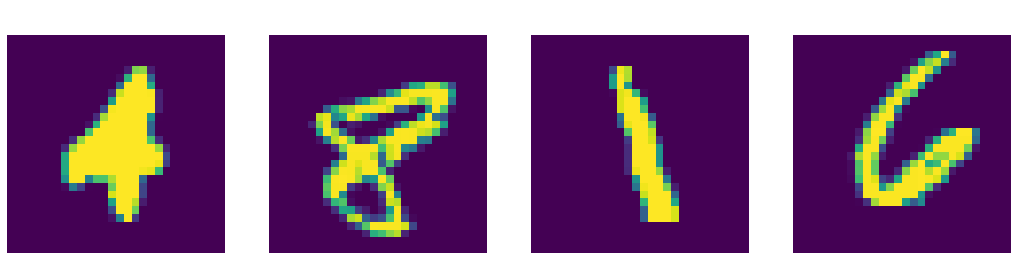

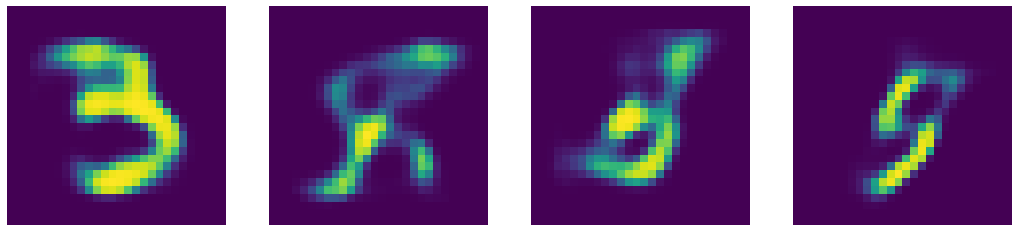

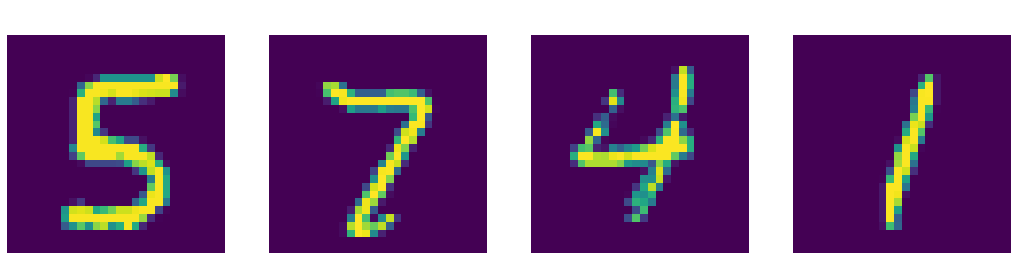

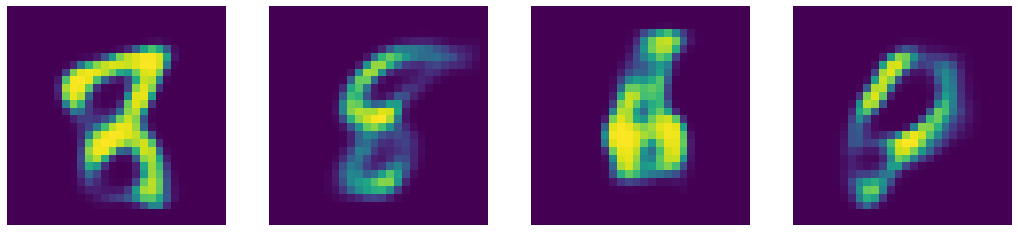

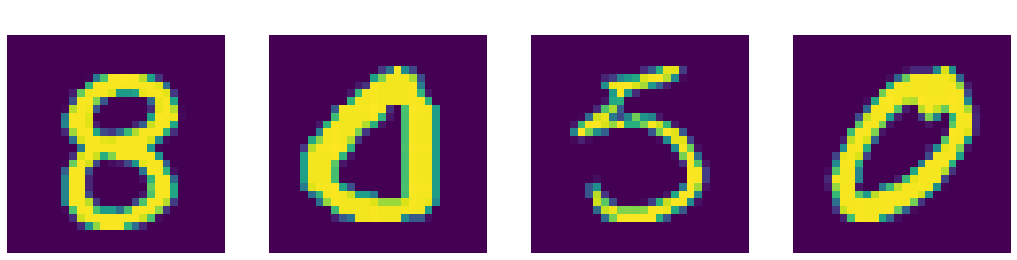

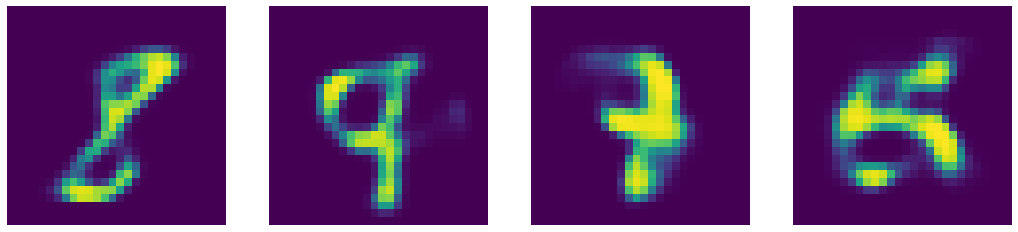

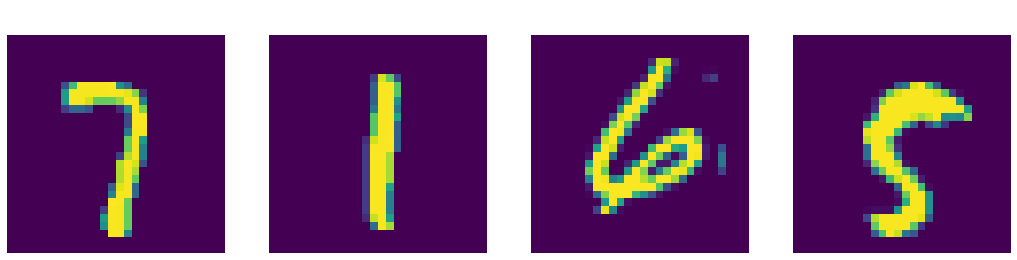

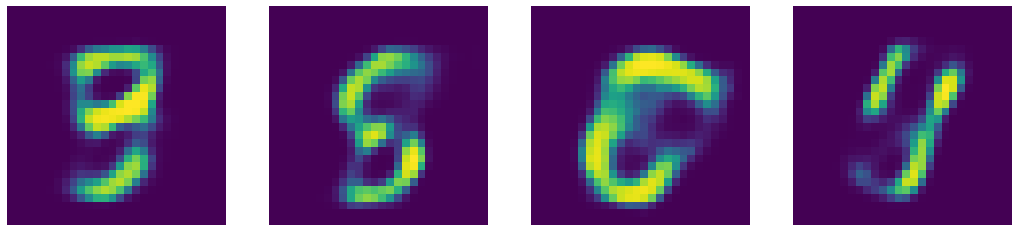

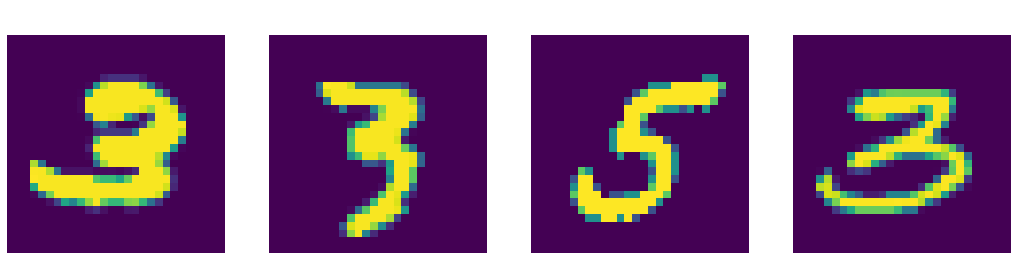

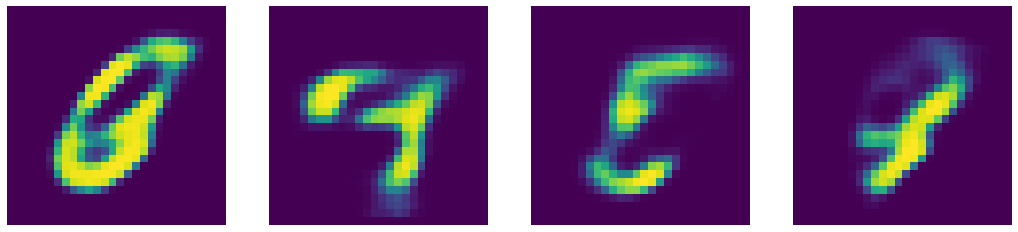

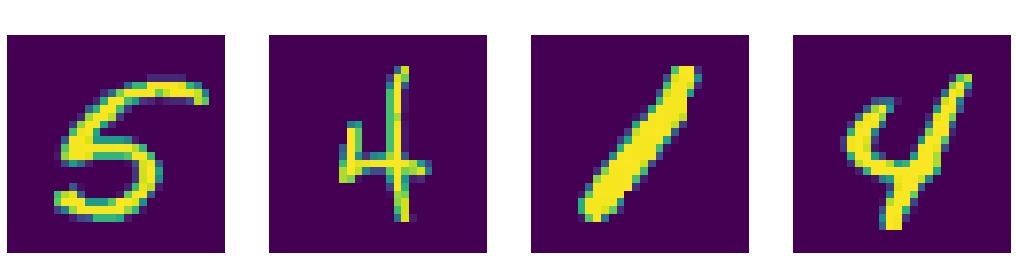

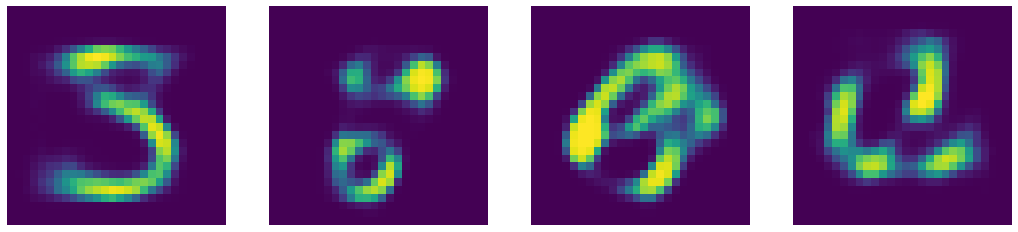

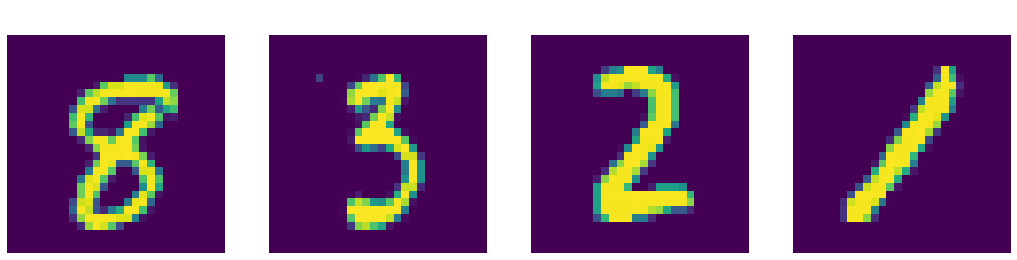

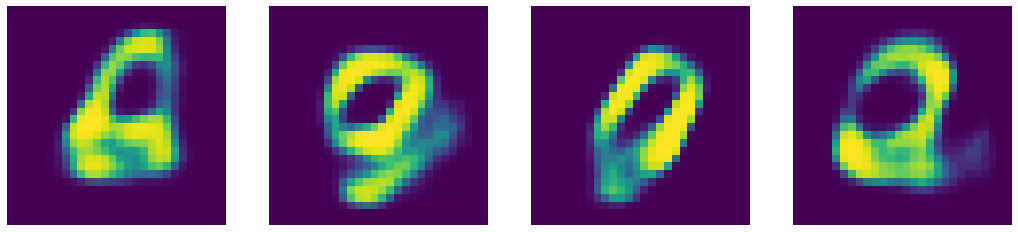

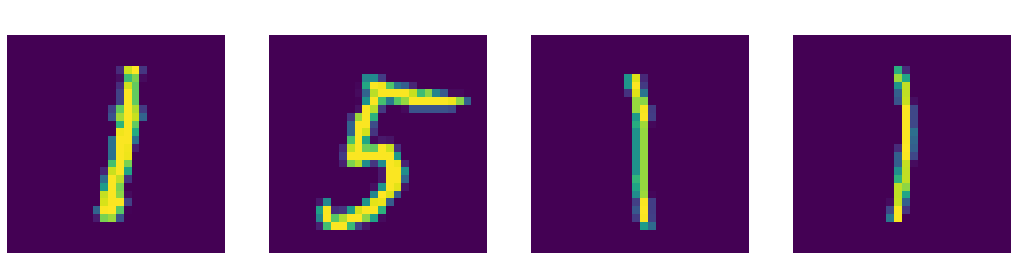

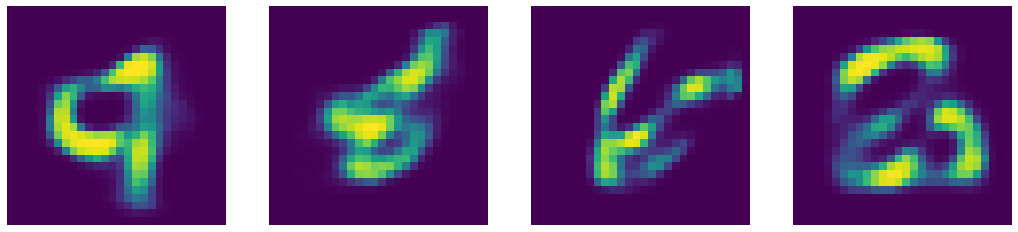

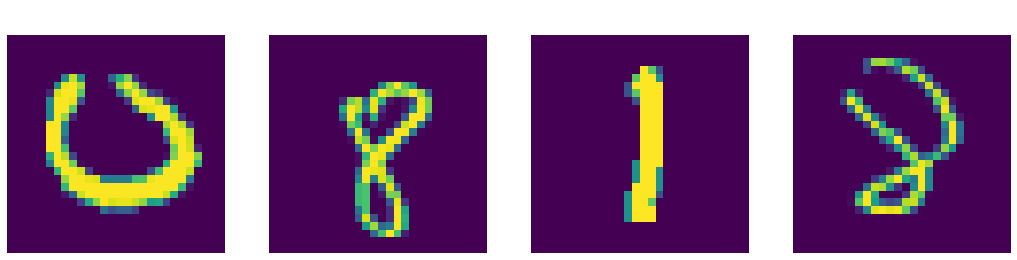

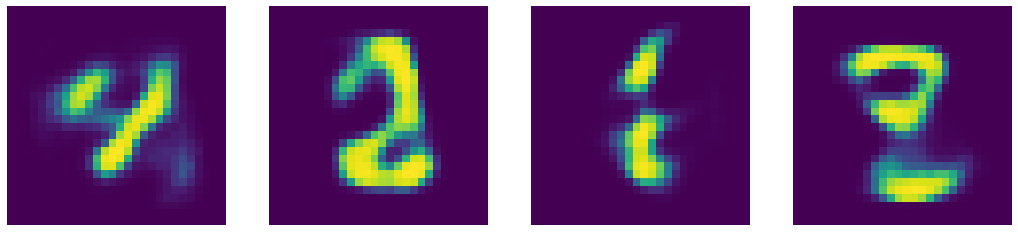

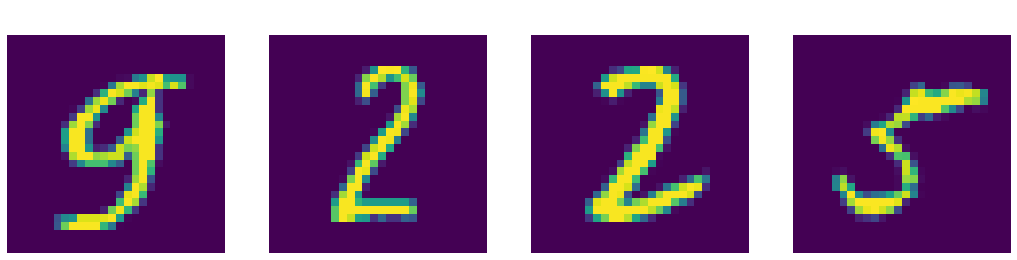

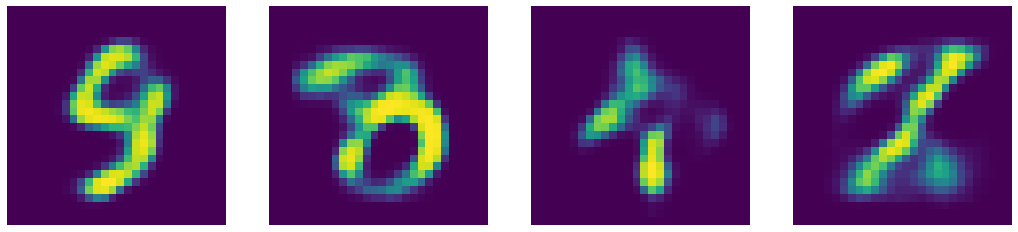

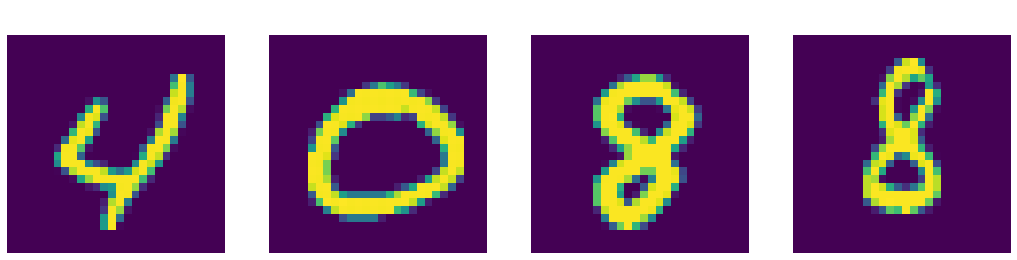

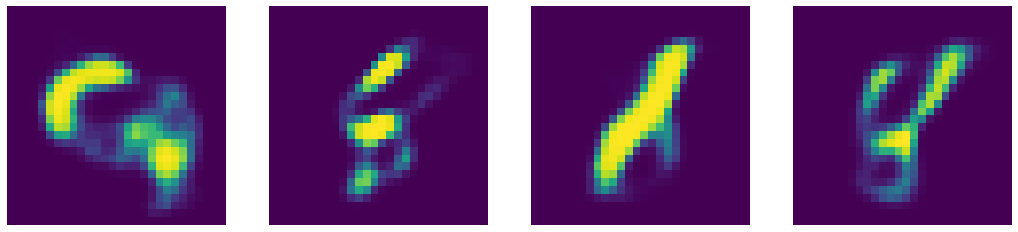

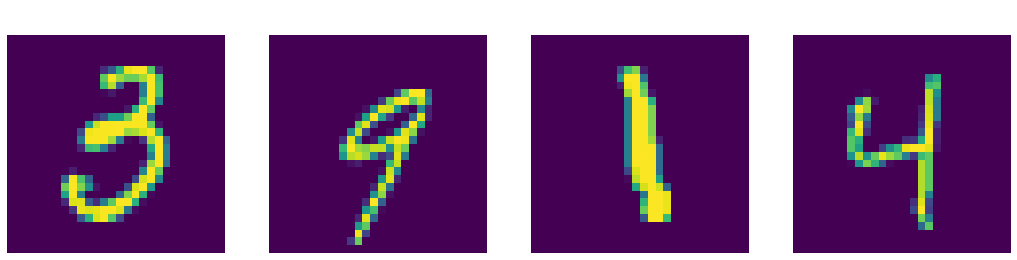

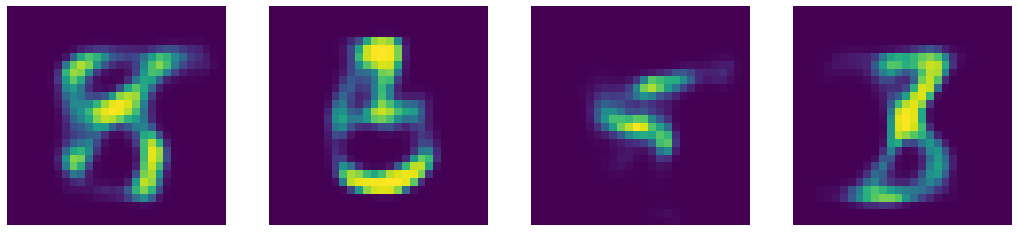

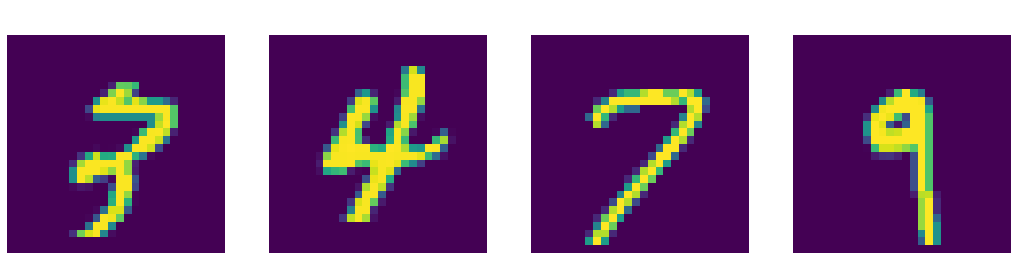

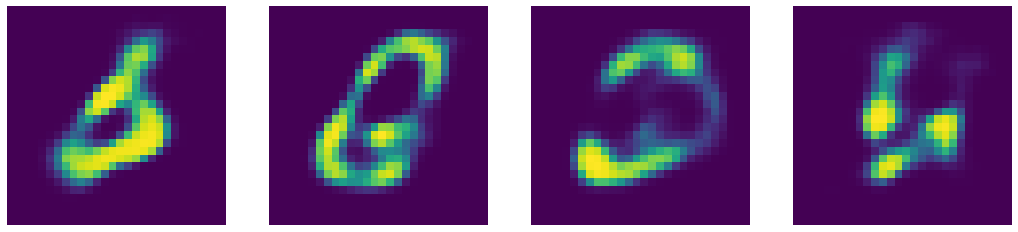

In [11]:
### Generated images from the decoder
with torch.no_grad():
    model.eval()
    for x, y in test_loader:
        # ===================forward=====================
        out, mu, logvar = model(x)
        new_image = model.decoder(torch.randn(128, 128))
        display_images(x , new_image , 1 , "images")